# Critical assessment of *E. coli* genome-scale metabolic model predictions with high-throughput mutant fitness data

This notebook assesses the accuracy of gene knockout phenotype predictions for *E. coli* genome-scale metabolic models (GEMs) using high-throughput mutant fitness data assayed across diverse carbon sources.  

The experimental gene fitness data used in this work is from *E. coli* BW25113 and is publicly available through Price et al Nature 2018 and the associated online fitness browser: https://fit.genomics.lbl.gov/cgi-bin/myFrontPage.cgi.

The four different *E. coli* GEMs used in this work are curated metabolic models for *E. Coli* MG1655 and are publicly available through the BIGG database: http://bigg.ucsd.edu/. Each model is a subsequent curated revision of the previous version. The models (publication year) are: iML1515 (2017), iJO1366 (2011), iAF1260 (2007), and iJR904 (2003).

To run this notebook start by running Part 0 and Part 1. Any individual subpart can then be run. For example Part 2a or Part 2b can be run independently. However, if the notebook is in a directory separate from the pre-processed data then certain subparts must be run prior to others to generate the necessary data. For example, if the data is not already generated Part 2a must be run before Part 2b.

The notebook is structured as follows:
* Part 0: Reset and Import
* Part 1: Defining Functions
* Part 2: Model version comparison. The accuracies of 4 different versions of the *E. coli* GEM are calculated and compared.
    * Part 2a: Running Flux Balance Analysis. Runs FBA on the different model versions to simulate gene knockout phenotypes and saves the results.
    * Part 2b: Plotting Performance of Each Model. Generates histogram, precision recall, and comparison plots.
* Part 3: iML1515 Adjustment Comparisons. In the latest model (iML1515) the impact of different adjustments that were made to the model are compared.
    * Part 3a: Running Flux Balance Analysis
    * Part 3b: Plotting Performance of Each Adjustment
* Part 4: Wild Type vs. Core Biomass. This section looks at the wild type and core biomass functions to compare results. It shows in the E. coli iML1515 model that there is no simulated growth when using the wild type biomass, hence the core biomass was used for all simulations in this work.
* Part 5: iML1515 Visualize Results. Generates visualizations of the simulated and experimental growth fitness data.
* Part 6: iML1515 Add Vitamins (False Negatives). This section addresses some false negative predictions of the latest model (the model did not grow but the experimental fitness was high) by making several vitamins available to the model.
    * Part 6a: Individual Vitamins (Run FBA)
    * Part 6b: Individual Vitamins (Plot Results)
    * Part 6c: All Vitamins (Run FBA)
    * Part 6d: All Vitamins (Plot Results)
* Part 7: iML1515 L-Serine Biosynthesis (False Positives). This section investigates incorrect false positive predictions (the model grew but the experimental fitness was low) for the growth phenotype of L-serine biosynthesis pathway knockouts.
    * Part 7a: Investigate Fluxes (L-serine)
    * Part 7b: Run FBA (L-serine)
    * Part 7c: Plot Results (L-serine)
* Part 8: iML1515 Isoenzymes (False Positives). This section addresses some false positive predictions of the latest model (the model grows but the experimental fitness was low) by adjusting several isoenzymes.
    * Part 8a: Explore Data (Isoenzymes)
    * Part 8b: Individual Isoenzymes (Run FBA)
    * Part 8c: Individual Isoenzymes (Plot Results)
    * Part 8d: All Isoenzymes (Run FBA)
    * Part 8e: All Isoenzymes (Plot Results)
* Part 9: iML1515 All Corrections (vitamins, L-serine, isoenzymes). This section updates the latest model to include all of the adjustments from the previous sections.
    * Part 9a: All Corrections (Run FBA )
    * Part 9c: All Corrections (Plot Results)
* Part 10: iML1515 Visualize Results (All Corrections)
* Part 11: Carbon Source Specific Predictions
* Part 12: iML1515 All Corrections Reaction Flux. Re-runs FBA as Parsimonious FBA for all simulations with growth and records the flux through each reaction. These fluxes are then used as the input for a machine learning model that predicts whether or not the simulated prediction was a true positive or a false positive.
    * Part 12a: Run pFBA and Record Flux
    * Part 12b: Run Wild Type (no-knockout) Flux
    * Part 12c: Visualize Flux Data
    * Part 12d: Machine Learning on Flux
* Part 13: Hydrogen Ion Exchange: Testing possible alterations to the model that could improve accuracy through tighter constraint of hydrogen ion exchange flux
    * Part 13a: Charge Balance (Run FBA)
    * Part 13b: Charge Balance (Plot Results)
    * Part 13c: H+ Fix Exchange (Run FBA)
    * Part 13d: H+ Fix Exchange (Plot Results)

## Part 0: Reset and Import

In [192]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [193]:
# import libraries
import cobra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve as pre_rec
from sklearn.metrics import confusion_matrix as confusion_matrix
from sklearn.metrics import auc as sk_auc
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from statsmodels.nonparametric.smoothers_lowess import lowess
import copy
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import shap
from scipy.sparse.csgraph import connected_components
from scipy.sparse.csgraph import shortest_path
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu, ttest_ind


### Set the base directory
This directory contains the "Models" and "Fitness_Data" folders. You can set it here for all parts.

In [194]:
base_directory = '/Users/david/Documents/GitHub/E_coli_GEM_validation/'

## Part 1: Defining Functions

In this section all of the functions that are necessary to set up and run the notebook are defined. These should all be run before any other part of the notebook is run.

### load_model
Load the curated metabolic model and adjusts the model by turning off all exchanges (no uptake) and optionally turning off the maintenance reaction. Here we will leave the maintenance on.

In [195]:
def load_model(active_model,base_directory):
# INPUT
# - active_model: the name of the E. coli genome-scale metabolic model .xml file to load (don't include .xml)
# - base_directory: the directory containing the data files/directories
# OUTPUT
# - model: cobrapy model object
    
    model = cobra.io.read_sbml_model(base_directory+'Models/'+active_model+'.xml')
    # turn off exchange reactions by setting lower and upper bounds to 0 and 1000 respectively
    for ex in model.exchanges:
        ex.lower_bound = 0
        ex.upper_bound = 1000
        
    # We leave the maintenance on here
    # turn off maintenance reactions by setting the lower bound to 0 (turning off maintenance can make results easier to interperet)
    # model.reactions.get_by_id("ATPM").lower_bound = 0
    
    return(model)

### load_environment
Load the base medium and environment (carbon sources) information and corresponding model IDs


In [196]:
def load_environment(base_directory):
# INPUT
# - base_directory: the directory containing the data files/directories
# OUTPUT
# - name_medium_model: the model's names of the media components
# - name_carbon_model: the model's name of the carbon sources
# - name_carbon_experiment: the name of the experiment corresponding to each carbon source

    # Loading the carbon sources
    fields = ['expName','media','BiGG Component']
    index_list = list(range(0,29))
    index_list.extend(list(range(31,51)))
    index_list.extend(list(range(53,59)))
    df_env = pd.read_table(base_directory+'/Fitness_Data/E_coli_BW25113/exp_organism_Keio_Mapped.txt', encoding='latin-1',usecols=fields,skiprows=lambda x: x not in index_list)
    name_carbon_model = df_env['BiGG Component'].tolist()
    name_carbon_experiment = df_env['expName'].tolist()

    # Loading the base medium
    df_med = pd.read_table(base_directory+'/Fitness_Data/E_coli_BW25113/exp_organism_Keio_Mapped_Media.txt', encoding='latin-1')    
    med = df_med.loc[1,'M9 minimal media_noCarbon']
    name_medium_model = med.split('; ')
    
    return (name_medium_model, name_carbon_model, name_carbon_experiment)

### load_data
Load and organizes the experimental fitness data

In [197]:
def load_data(base_directory):
# INPUT
# - base_directory: the directory containing the data files/directories
# OUTPUT
# - data_experiments: list of experiment IDs from fitness data
# - data_genes: list of gene IDs from fitness data
# - data_fitness: 2D array of fitness data [genes x experiments]

    # Loading the fitness data
    df_fit = pd.read_table(base_directory+'/Fitness_Data/E_coli_BW25113/fit_organism_Keio.tsv')
    
    data_genes = df_fit.loc[:,'sysName'].to_list()
    
    data_envs = df_fit.columns
    data_envs = data_envs[5:]
    data_experiments = []
    for e in range(len(data_envs)):
        tmp = data_envs[e].split(' ')
        data_experiments.append(tmp[0])

    data_fitness = df_fit.iloc[:,5:].to_numpy()
    
    return(data_experiments,data_genes,data_fitness)

### match_model_data
This function matches the active metabolic model genes and experiments with the data IDs. It also averages the fitness data for replicate carbon sources. This is done to reduce time/complexity, and was also found to improve the measured performance of the models.

In [198]:
def match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness):
# INPUT
# - model: cobrapy model object
# - name_carbon_model: the model's name of the carbon sources
# - name_carbon_experiment: the name of the experiment corresponding to each carbon source
# - data_experiments: list of experiment IDs from fitness data
# - data_genes: list of gene IDs from fitness data
# - data_fitness: 2D array of fitness data [genes x experiments]

# OUTPUT
# - name_genes_matched: gene names matched between model and data
# - name_carbon_experiment_matched_unique: experiment IDs matched between model and data (unique carbon sources only)
# - name_carbon_model_matched_unique: carbon source names matched between model and data (unique carbon sources only)
# - data_fitness_matched_unique: fitness data rearranged along axis of matched genes and carbon sources (average of unique carbon sources)
    
    name_genes_matched = []
    data_genes_matched_inds = []
    for f in range(len(data_genes)):
        for g in range(len(model.genes)):
            if data_genes[f] == model.genes[g].id:
                name_genes_matched.append(model.genes[g].id)
                data_genes_matched_inds.append(f)

    name_carbon_experiment_matched = []
    name_carbon_model_matched = []
    data_carbon_matched_inds = []
    for e in range(len(data_experiments)):
        for e2 in range(len(name_carbon_experiment)):
            if data_experiments[e] == name_carbon_experiment[e2]:
                name_carbon_experiment_matched.append(name_carbon_experiment[e2])
                name_carbon_model_matched.append(name_carbon_model[e2])
                data_carbon_matched_inds.append(e)
    data_fitness_matched = data_fitness[data_genes_matched_inds,:][:,data_carbon_matched_inds]
    
    # Average Data for Same Carbon Source (this is done to reduce time/complexity, and was also found to improve the measured performance of the models)
    [name_carbon_model_matched_unique,map1,map2]=np.unique(name_carbon_model_matched,return_index=True,return_inverse=True)
    name_carbon_experiment_matched_unique = np.array(name_carbon_experiment_matched)[map1]
    
    # Average fitness data across carbon source replicates
    data_fitness_matched_unique = np.zeros([data_fitness_matched.shape[0],len(name_carbon_model_matched_unique)])
    for i in range(len(name_carbon_model_matched_unique)):
        data_fitness_matched_unique[:,i]=np.transpose(np.mean(data_fitness_matched[:,np.argwhere(map2==i)],1))
    
    return(name_genes_matched,name_carbon_experiment_matched_unique,name_carbon_model_matched_unique,data_fitness_matched_unique)

    



### model_adjustments
This function is important for the analysis. It adjusts the comparison of the model with the experimental fitness data to account for several factors.

To account for strain variation between the experimental *E. Coli* strain that the fitness data comes from (BW25113) and the strain that the curated model is built off of (MG1655), genes have been identified that exist in the model but not the experimental strain and need to be removed. These genes are knocked out from the model. The genes were identified from [Grenier et al 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4200154/), and the associated [table](https://bioinfo.ccs.usherbrooke.ca/BW25113.html) outlining the genomic differences between BW25113 and MG1655.

This function also removes genes that are unconditionally essential in the metabolic model (required for growth when all exchanges are open). Knocking-out these genes theoretically leads to a growth defect across all media thus they may not have reliable fitness scores from tn-seq experiments as they will not be well represented in the initial library. We have chosen to remove these genes from our current analysis.

This function also removes two of the carbon sources from the analysis. The carbon sources sucrose and mannitol are known to have errors in the experimental fitness data set used in this work so they are removed from this analysis.

In [199]:
def model_adjustments(adj_strain, adj_essential, adj_carbon, model, names_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched):
# INPUT
# - adj_strain: boolean variable (whether to adjust the strain or not)
# - adj_essential: boolean variable (adjust the essential genes or not)
# - adj_carbon: boolean variable (adjust the carbon sources or not)
# - model: cobrapy model object
# - name_genes_matched: gene names matched between model and data
# - name_carbon_experiment_matched: experiment IDs matched between model and data
# - name_carbon_model_matched: carbon source names matched between model and data
# - data_fitness_matched: fitness data rearranged along axis of matched genes and carbon sources
# OUTPUT
# - model_adj: cobrapy model object (with adjustments)
# - name_genes_matched_adj: gene names matched between model and data (adjusted)
# - name_carbon_experiment_matched_adj: experiment IDs matched between model and data (adjusted)
# - name_carbon_model_matched_adj: carbon source names matched between model and data (adjusted)
# - data_fitness_matched_adj: fitness data rearranged along axis of matched genes and carbon sources (adjusted)

    model_adj = copy.deepcopy(model) #using deepcopy so that changes to model_adj are not propogated to model
    #model_adj = model #to shallow copy
    name_genes_matched_adj = name_genes_matched
    data_fitness_matched_adj = data_fitness_matched
    name_carbon_experiment_matched_adj = name_carbon_experiment_matched
    name_carbon_model_matched_adj = name_carbon_model_matched
    
    if adj_strain == 1:
        strain_gene_remove = ['araA','araB','valX','rhaA','rhaB','araD','lacZ','rhaD']
        # ID's of the genes to be removed were found through search at http://bigg.ucsd.edu/models/iML1515/genes
        # Genome variations from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4200154/ and https://bioinfo.ccs.usherbrooke.ca/BW25113.html
        strain_gene_remove_id = ['b0062','b0063','b3903','b3904','b0061','b0344','b3902']
        
        #Knocking out the genes from the model
        for i in range(len(strain_gene_remove_id)):
            model_adj.genes.get_by_id(strain_gene_remove_id[i]).knock_out()
        
        # Adjusting genes in data (in case some of these genes appear in the data set)
        # Strain variation genes
        # printout
        print('removing genes (strain):')
        tmp_inds = []
        for i in range(len(name_genes_matched_adj)):
            if names_genes_matched[i] in strain_gene_remove_id:
                tmp_inds.append(i)
                print(name_genes_matched_adj[i])
        
        # remove genes
        name_genes_matched_adj = np.delete(name_genes_matched_adj,tmp_inds,0)
        # remove corresponding data
        data_fitness_matched_adj = np.delete(data_fitness_matched_adj,tmp_inds,0)
        
    if adj_essential == 1:
        # Essential genes
        thresh = 0.001

        # turn all exchanges on
        for ex in model_adj.exchanges:
            ex.lower_bound = -1000
            ex.upper_bound = 1000

        tmp_inds = []
        # Looping through genes
        print('removing genes (essential):')
        for g in range(len(name_genes_matched_adj)):
            with model_adj:
                # Knocking out gene
                model_adj.genes.get_by_id(name_genes_matched_adj[g]).knock_out()
                solution = model_adj.slim_optimize() # Simulating growth
                if solution < thresh:
                    tmp_inds.append(g)
                    print(name_genes_matched_adj[g])
        
        # remove genes
        name_genes_matched_adj = np.delete(name_genes_matched_adj,tmp_inds,0)
        # remove corresponding data
        data_fitness_matched_adj = np.delete(data_fitness_matched_adj,tmp_inds,0)
        
        # Turn all exchanges back off
        for ex in model_adj.exchanges:
            ex.lower_bound = 0
            ex.upper_bound = 1000
        
    if adj_carbon == 1:
        # Removing sucrose and mannitol carbon sources
        print('removing carbon sources:')
        carbon_remove = ['man','sucr']
        tmp_inds = []
        for c in range(len(name_carbon_model_matched_adj)):
            if name_carbon_model_matched_adj[c] in carbon_remove:
                tmp_inds.append(c)
                print(name_carbon_model_matched_adj[c])
        
        # remove carbon sources
        name_carbon_model_matched_adj = np.delete(name_carbon_model_matched_adj,tmp_inds,0).tolist()
        name_carbon_experiment_matched_adj = np.delete(name_carbon_experiment_matched_adj,tmp_inds,0).tolist()
        # remove corresponding data
        data_fitness_matched_adj = np.delete(data_fitness_matched_adj,tmp_inds,1)
            
    return(model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_adj)

### check_environment
This function looks to see if each component in the medium and carbon sources is found within the active metabolic model. This is necessary because older models may not have all of the components defined and thus those components need to be omitted during test growth runs and during flux balance analysis. This function also returns the indices of the exchanges for the media and environmental components to be used for later model manipulations.

In [200]:
def check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj):
# INPUT
# - model_adj: cobrapy model object (with adjustments)
# - name_medium_model: the model's names of the media components
# - name_carbon_model_matched_adj: carbon source names matched between model and data (adjusted)
# OUTPUT
# - medium_ex_inds: the exchange indices in the model for the media components (-1 if not present)
# - carbon_ex_inds: the exchange indices in the model for the environment components (carbon sources) (-1 if not present)
    
    # Checking if media components are present in the model
    medium_ex_inds = np.ones(len(name_medium_model),dtype=int)*-1 #Initialize array with -1, this will then indicate that a match was not found
    for m in range(len(name_medium_model)):
        # Finding Exchange Index in Model
        probe = 'EX_'+name_medium_model[m]+'_e'
        for e in range(len(model_adj.exchanges)):
            if probe == model_adj.exchanges[e].id:
                medium_ex_inds[m] = e
    print('medium components not found in model:')
    for i in range(len(medium_ex_inds)):
        if medium_ex_inds[i] == -1:
            print(name_medium_model[i])
    
    # Match / Check For Exchanges (Note for now we are only using single carbon source examples)
    carbon_ex_inds = np.ones(len(name_carbon_model_matched_adj),dtype=int)*-1 #Initialize array with -1, this will then indicate that a match was not found
    for m in range(len(name_carbon_model_matched_adj)):
        # Find Exchange Index in Model
        probe = 'EX_'+name_carbon_model_matched_adj[m]+'_e'
        for e in range(len(model_adj.exchanges)):
            if probe == model_adj.exchanges[e].id:
                carbon_ex_inds[m] = e
    print('carbon components not found in model:')
    for i in range(len(carbon_ex_inds)):
        if carbon_ex_inds[i] == -1:
            print(name_carbon_model_matched_adj[i])
            
    return (medium_ex_inds, carbon_ex_inds)

### test_growth
The test_growth function is not necessary for the analysis done in this notebook. It serves as a sanity check to make sure that the "wild type" metabolic model was loaded and grows on all of the individual carbon sources but not on the base medium with no carbon. Once you run part 2 of the notebook the results from the test growth should be output, showing growth in all of the environments (with the iML1515 model sucrose may show no growth, this is a recent update that more accurately reflects the data). The test growth is essentially saying without any gene knockouts can I grow in each of the carbon sources, for which the answer should be yes since all genes are present in the model.

In [201]:
def test_growth(model_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds):
# INPUT
# - model_adj: cobrapy model object (adjusted)
# - name_medium_model: the model's names of the media components
# - name_carbon_model_matched_adj: carbon source names matched between model and data (adjusted)
        
    with model_adj: #don't save changes to model
        # add base media
        for e in range(len(medium_ex_inds)):
            if medium_ex_inds[e] != -1:
                model_adj.exchanges[medium_ex_inds[e]].lower_bound = -1000

        # Test growth with no carbon source
        thresh = 0.001 #growth/no-growth threshold for flux balance analysis simulations
        base_growth = -1
        solution = model_adj.optimize()
        if not solution.objective_value:
            solution.objective_value = 0
        if solution.objective_value > thresh:
            base_growth = 1
        print('Growth With No C Source:',base_growth)

        # add carbon sources and simulate growth/no-growth
        base_growth_C = np.ones(len(carbon_ex_inds),dtype=float)*-1
        for e in range(len(carbon_ex_inds)):
            if carbon_ex_inds[e] != -1:
                model_adj.exchanges[carbon_ex_inds[e]].lower_bound = -10

            # simulate growth with FBA
            solution = model_adj.slim_optimize() #simulate growth with flux balance anlaysis
            if solution > thresh:
                base_growth_C[e] = 1

            # Turn off carbon source
            if carbon_ex_inds[e] != -1:
                model_adj.exchanges[carbon_ex_inds[e]].lower_bound = 0

            print(e,'Growth With C Source:',name_carbon_model_matched_adj[e],base_growth_C[e])

### simulate_phenotype
This function runs flux balance analysis to simulate the growth/no-growth phenotypes. This function is the crux of this notebook as it performs the growth predictions for each gene and carbon source combination for each of the 4 metabolic models.

In [202]:
def simulate_phenotype(model_run,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds):
# INPUT
# - model_run: cobrapy model object for simulations (this should be model_adj, the model with adjustments)
# - name_genes_matched_adj: gene names matched between model and data (adjusted)
# - name_carbon_model_matched_adj: carbon source names matched between model and data (adjusted)
# OUTPUT
# - data_fitness_simulated_matched_adj: simulated data matching data_fitness_matched_adj

    # Initialize Simulation Data
    data_fitness_simulated_matched_adj = np.zeros([len(name_genes_matched_adj),len(name_carbon_model_matched_adj)],dtype=float) # Environments by Genes

    # add base media
    for e in range(len(medium_ex_inds)):
        if medium_ex_inds[e] != -1:
            model_run.exchanges[medium_ex_inds[e]].lower_bound = -1000

    # Loop through environments
    for e in range(len(name_carbon_model_matched_adj)):
        # print progress
        print(str.format('{0:.2f}',e/len(name_carbon_model_matched_adj)),end='\r')

        # This if statement is not necessary if running on unique carbon sources with pre-averaged fitness data
        if name_carbon_model_matched_adj[e] in name_carbon_model_matched_adj[:e]: #already ran this carbon source (just copy the result)
            e_found = name_carbon_model_matched_adj[:e].index(name_carbon_model_matched_adj[e])
            data_fitness_simulated_matched_adj[:,e] = data_fitness_simulated_matched_adj[:,e_found]
        else:
            # Add carbon source
            if carbon_ex_inds[e] != -1:
                model_run.exchanges[carbon_ex_inds[e]].lower_bound = -10 #we set the carbon uptake to -10 while all other uptakes are default -1000

                # Loop through genes
                for g in range(len(name_genes_matched_adj)):
                    with model_run:
                        # knock out gene
                        model_run.genes.get_by_id(name_genes_matched_adj[g]).knock_out()
                        solution = model_run.slim_optimize() # simulate growth
                        if np.isnan(solution): #slim_optimize gives nan solution for infeasible simulations
                            solution = 0
                        data_fitness_simulated_matched_adj[g,e] = solution

                # Turn off carbon source
                model_run.exchanges[carbon_ex_inds[e]].lower_bound = 0
        
    return (data_fitness_simulated_matched_adj)

### simulate_phenotype_flux
This function runs parsimonious flux balance analysis to simulate the growth/no-growth phenotypes and the fluxes through all reactions.

In [203]:
def simulate_phenotype_flux(model_run,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds):
# INPUT
# - model_run: cobrapy model object for simulations (this should be model_adj, the model with adjustments)
# - name_genes_matched_adj: gene names matched between model and data (adjusted)
# - name_carbon_model_matched_adj: carbon source names matched between model and data (adjusted)
# OUTPUT
# - data_fitness_simulated_flux_matched_adj: simulated fluxes matching data_fitness_matched_adj

    # Initialize Simulation Data
    data_fitness_simulated_flux_matched_adj = np.zeros([len(name_genes_matched_adj),len(name_carbon_model_matched_adj),len(model_run.reactions)],dtype=float) # Environments by Genes by Reactions

    # add base media
    for e in range(len(medium_ex_inds)):
        if medium_ex_inds[e] != -1:
            model_run.exchanges[medium_ex_inds[e]].lower_bound = -1000

    # Loop through environments
    for e in range(len(name_carbon_model_matched_adj)):
        # print progress
        print(str.format('{0:.2f}',e/len(name_carbon_model_matched_adj)),end='\r')

        # This if statement is not necessary if running on unique carbon sources with pre-averaged fitness data
        if name_carbon_model_matched_adj[e] in name_carbon_model_matched_adj[:e]: #already ran this carbon source (just copy the result)
            e_found = name_carbon_model_matched_adj[:e].index(name_carbon_model_matched_adj[e])
            data_fitness_simulated_flux_matched_adj[:,e,:] = data_fitness_simulated_flux_matched_adj[:,e_found,:]
        else:
            # Add carbon source
            if carbon_ex_inds[e] != -1:
                model_run.exchanges[carbon_ex_inds[e]].lower_bound = -10 #we set the carbon uptake to -10 while all other uptakes are default -1000

                # Loop through genes
                for g in range(len(name_genes_matched_adj)):
                    with model_run:
                        # knock out gene
                        model_run.genes.get_by_id(name_genes_matched_adj[g]).knock_out()
                        solution = model_run.slim_optimize() # simulate growth
                        if np.isnan(solution): #slim_optimize gives nan solution for infeasible simulations
                            solution = 0
                        if solution > 0.001: #only run for fluxes if growth above threshold 
                            # Run parsimonious flux balance analysis (pfba)
                            pfba_solution = cobra.flux_analysis.pfba(model_run)
                            data_fitness_simulated_flux_matched_adj[g,e,:] = np.array(pfba_solution.fluxes)
                            
                # Turn off carbon source
                model_run.exchanges[carbon_ex_inds[e]].lower_bound = 0
        
    return (data_fitness_simulated_flux_matched_adj)

### plot_histogram
The plot_histogram function plots the predictions for growth (red) and no growth (blue) made through FBA. Visual analysis of the plot will indicate that the less overlap there is between the two histograms, the more accurate the model's predictions were.

In [204]:
def plot_histogram(model_name,data_fitness_simulated_matched_adj,data_fitness_matched_adj,ylim):
# INPUT
# - model_name: name for the plot
# - data_fitness_simulated_matched_adj: simulated data matching data_fitness_matched_adj
# - data_fitness_matched_adj: fitness data rearranged along axis of matched genes and carbon sources (adjusted)
# OUTPUT
# fig,axs: figure and axis handles
# - BAC: balanced accuracy of the model
# - AC: overall accuracy of the model

    # Binarize simulate fitness based on a given threshold
    sim_thresh = 0.001
    data_sim_b = (data_fitness_simulated_matched_adj > sim_thresh).astype(int)

    # Binarize fitness data based on a given threshold
    fit_thresh = -2
    data_fit_b = (data_fitness_matched_adj > fit_thresh).astype(int)
    
    # Calculate metrics from binarized data (these metrics are not currently used in this work, we instead use the precision recall auc which is independent of the experimental fitness data thresholding)
    tn, fp, fn, tp = confusion_matrix(data_fit_b.flatten(),data_sim_b.flatten(),labels=[1,0]).ravel()    
    pre = tp/(tp+fp)
    # Recall
    rec = tp/(tp+fn)
    # F1 score
    f1s = 2*tp/(2*tp+fp+fn)
    # Balance Accuracy
    TPR = tp/(tp+fn)
    TNR = tn/(tn+fp)
    BAC = (TPR+TNR)/2
    AC = (tp+tn)/(tn+fn+tp+fp)

    # Plot figure
    fig, axs = plt.subplots(1,1)
    fig.set_figheight(5)
    fig.set_figwidth(8)

    axs.hist(data_fitness_matched_adj[data_sim_b==1],bins=100,range=(-10,10),color='r',alpha=0.5) #for different figures this alpha is switched between 1 and 0.5
    axs.hist(data_fitness_matched_adj[data_sim_b==0],bins=100,range=(-10,10),color='b',alpha=0.5)
    axs.set_ylim(ylim)
    #axs.title.set_text(model_name+' BAC: '+str(BAC)) # add balanced accuracy to title
    axs.title.set_text(model_name)
    axs.set_xlabel('experimental fitness')
    axs.set_ylabel('count')
    plt.rcParams['font.size'] = 12
    
    return(fig,axs,BAC,AC)

### plot_precision_recall_curve
The plot_recall_curve function will display the precision versus recall performance of each model. The closer the red plot is to the upper left corner the better the performance. Similarly, the larger the area under the curve (AUC) value, the better the performance of the model.

A precision recall curve is used here, as opposed to a ROC curve, because of the large imbalance in the data set (most gene knockouts are non-essential). Thus models can trivially achieve a high ROC AUC by predicting that all gene knockouts are non-essential. Additionally, we are most interested in when the model can correctly predict the effect of gene knockout that are essential (rather than correctly predicting that a gene knockout has no effect), and the precision recall curve that we calculate focuses on these predictions.

In [205]:
def plot_precision_recall_curve(model_name,data_fitness_simulated_matched_adj,data_fitness_matched_adj):
# INPUT
# - model_name: name for the plot
# - data_fitness_simulated_matched_adj: simulated data matching data_fitness_matched_adj
# - data_fitness_matched_adj: fitness data rearranged along axis of matched genes and carbon sources (adjusted)
# OUTPUT
# fig,axs: figure and axis handles
# - AUC: precision recall area under curve

    fig, axs = plt.subplots(1,1)
    fig.set_figheight(5)
    fig.set_figwidth(5)

    sim_thresh = 0.001
    data_sim_b = (data_fitness_simulated_matched_adj > sim_thresh).astype(int)
    data_fit_V = data_fitness_matched_adj.flatten()
    data_sim_b_V = data_sim_b.flatten()

    pre, rec, thresholds = pre_rec(data_sim_b_V,data_fit_V*-1,pos_label=0)
    axs.plot(rec,pre,'r')
    AUC = sk_auc(rec,pre)
    axs.set_ylim([0, 1])
    #axs.title.set_text('Precision Recall Curve:'+' '+str(model_name)+', AUC='+str(round(AUC,3)))
    axs.title.set_text('AUC='+str(round(AUC,3)))
    axs.set_xlabel('recall')
    axs.set_ylabel('precision')
    plt.rcParams['font.size'] = 12
    
    return fig,axs,AUC

## Part 2: Model Version Comparison

### Part 2a: Running Flux Balance Analysis

This section of the notebook loops through each of the 4 metabolic models and runs FBA for each of them. The FBA results after each run are all saved as numpy arrays so that they can be loaded in part 3 of the notebook for plotting performance and comparisons. This is helpful so that this part of the notebook only needs to be run one time and part 3 of the notebook can then be run over and over again as needed.

In [136]:
# Load environment
[name_medium_model, name_carbon_model, name_carbon_experiment] = load_environment(base_directory)

# Load Data
[data_experiments,data_genes,data_fitness] = load_data(base_directory)


In [152]:
# Note: this cell takes several hours to run
model_names = ['iJR904','iAF1260','iJO1366','iML1515']
num_genes = np.zeros(4)
for ind,model_name in enumerate(model_names):
    print(model_name)
    
    # load model
    print('loading model')
    model = load_model(model_name,base_directory)
    # optional printout check
    print(str(len(model.genes))+' total genes in model')
    
    # match model to data
    print('matching model and data')
    [name_genes_matched,name_carbon_experiment_matched,name_carbon_model_matched,data_fitness_matched] = match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness)
    # optional printout checks
    print(str(len(name_genes_matched))+' genes matched')
    print(str(len(name_carbon_model_matched))+' carbon matched')
    
    # adjust model
    print('adjusting model')
    adj_strain = 1
    adj_essential = 1
    adj_carbon = 1
    [model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
    # optional printout checks
    print(str(len(name_genes_matched_adj)),' adjusted genes matched')
    print(str(len(name_carbon_model_matched_adj)),' adjusted carbon matched')
    print(str(data_fitness_matched_adj.shape),' data shape')
    
    # get medium and carbon exchange indicies
    print('checking environment')
    [medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
    
    # test growth
    print('testing growth')
    test_growth(model_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)
    
    # simulate phenotype
    print('simulating phenotype')
    data_fitness_simulated_matched_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)
    
    # save data
    np.save(model_name+'_fitness_sim.npy',np.asarray(data_fitness_simulated_matched_adj,dtype=np.double))
    np.save(model_name+'_fitness.npy',np.asarray(data_fitness_matched_adj,dtype=np.double))
    # save ids
    np.save(model_name+'_names_genes.npy',np.asarray(name_genes_matched_adj))
    np.save(model_name+'_names_carbon_model.npy',np.asarray(name_carbon_model_matched_adj))
    np.save(model_name+'_names_carbon_experiment.npy',np.asarray(name_carbon_experiment_matched_adj))
    # save number of genes in array
    num_genes[ind] = len(name_genes_matched_adj)
    
    print(f'\n')

np.save('num_genes.npy', np.asarray(num_genes,dtype=np.intc))


iJR904
loading model
904 total genes in model
matching model and data


NameError: name 'name_carbon_model' is not defined

### Part 2b: Plotting Performance of Each Model

#### iJR904 (2003)

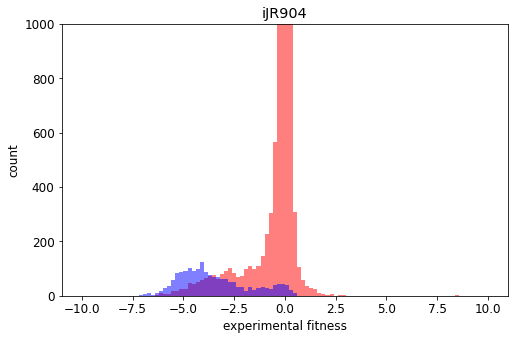

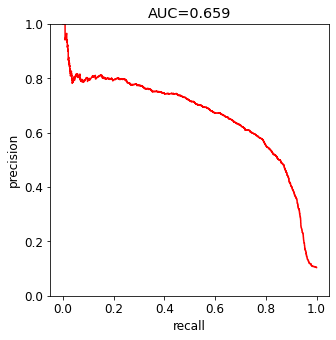

In [214]:
# load data
model_name = 'iJR904'
data_fitness_sim = np.load(model_name+'_fitness_sim.npy')
data_fitness = np.load(model_name+'_fitness.npy')

# plot histogram
ylim = [0,1000]
[fig,axs,BAC_iJR904,AC_iJR904] = plot_histogram(model_name,data_fitness_sim,data_fitness,ylim)
image_format = 'svg'
image_name = 'plots/'+model_name+'_histogram.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

# plot precision recall curve
[fig,axs,AUC_iJR904] = plot_precision_recall_curve(model_name,data_fitness_sim,data_fitness)
image_format = 'svg'
image_name = 'plots/'+model_name+'_pre_rec.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

In [215]:
# Calculate Accuracies for Null Model - Base iJR904 model with non-function gene additions

# Binarize simulate fitness based on a given threshold
sim_thresh = 0.001
data_sim_b = (data_fitness_sim > sim_thresh).astype(int)
# Binarize fitness data based on a given threshold
fit_thresh = -2
data_fit_b = (data_fitness > fit_thresh).astype(int)

num_genes = np.load('num_genes.npy')
num_genes_add = num_genes-num_genes[0]

AC_i = np.zeros(len(num_genes_add))
AUC_i = np.zeros(len(num_genes_add))

for i in range(len(num_genes_add)):
    # flatten data
    data_fit_b_V = data_fit_b.flatten()
    data_sim_b_V = data_sim_b.flatten()
    data_fit_V = data_fitness.flatten()
    
    # add non-functional genes
    data_fit_b_V = np.append(data_fit_b_V,np.ones(num_genes_add[i]*data_fit_b.shape[1]))
    data_sim_b_V = np.append(data_sim_b_V,np.ones(num_genes_add[i]*data_fit_b.shape[1]))
    data_fit_V = np.append(data_fit_V,np.zeros(num_genes_add[i]*data_fit_b.shape[1]))
    
    # Calculate metrics from binarized data (these metrics are not currently used in this work, we instead use the precision recall auc which is independent of the experimental fitness data thresholding)
    tn, fp, fn, tp = confusion_matrix(data_fit_b_V,data_sim_b_V,labels=[1,0]).ravel()    
    AC_i[i] = (tp+tn)/(tn+fn+tp+fp)

    pre, rec, thresholds = pre_rec(data_sim_b_V,data_fit_V*-1,pos_label=0)
    AUC_i[i] = sk_auc(rec,pre)



#### iAF1260 (2007)

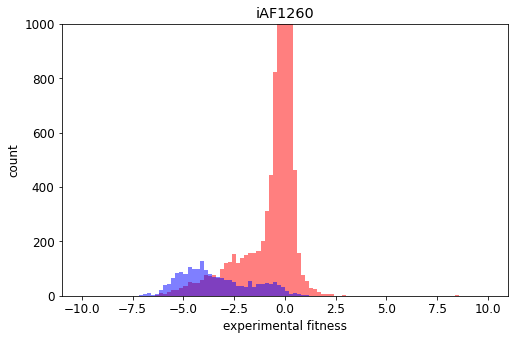

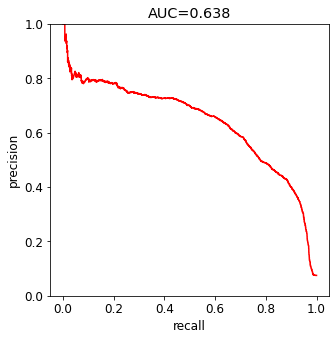

In [216]:
# load data
model_name = 'iAF1260'
data_fitness_sim = np.load(model_name+'_fitness_sim.npy')
data_fitness = np.load(model_name+'_fitness.npy')

# plot histogram
ylim = [0,1000]
[fig,axs,BAC_iAF1260,AC_iAF1260] = plot_histogram(model_name,data_fitness_sim,data_fitness,ylim)
image_format = 'svg'
image_name = 'plots/'+model_name+'_histogram.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

# plot precision recall curve
[fig,axs,AUC_iAF1260] = plot_precision_recall_curve(model_name,data_fitness_sim,data_fitness)
image_format = 'svg'
image_name = 'plots/'+model_name+'_pre_rec.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

#### iJO1366 (2011)

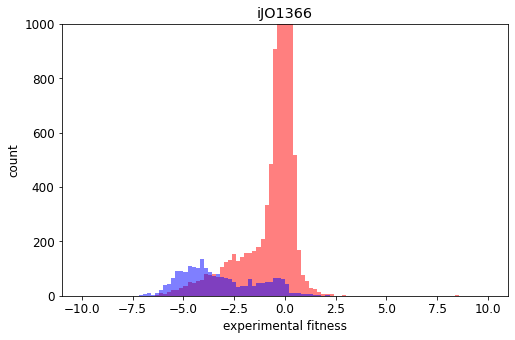

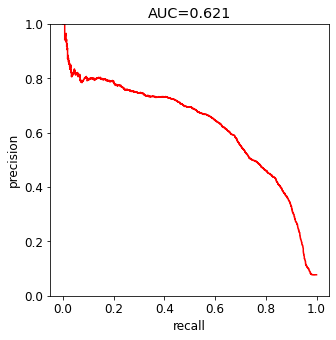

In [217]:
# load data
model_name = 'iJO1366'
data_fitness_sim = np.load(model_name+'_fitness_sim.npy')
data_fitness = np.load(model_name+'_fitness.npy')

# plot histogram
ylim = [0,1000]
[fig,axs,BAC_iJO1366,AC_iJO1366] = plot_histogram(model_name,data_fitness_sim,data_fitness,ylim)
image_format = 'svg'
image_name = 'plots/'+model_name+'_histogram.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

# plot precision recall curve
[fig,axs,AUC_iJO1366] = plot_precision_recall_curve(model_name,data_fitness_sim,data_fitness)
image_format = 'svg'
image_name = 'plots/'+model_name+'_pre_rec.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

#### iML1515 (2017)

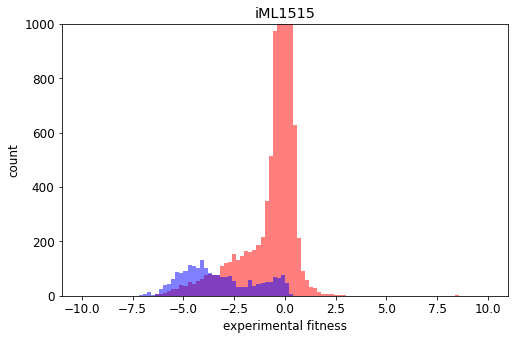

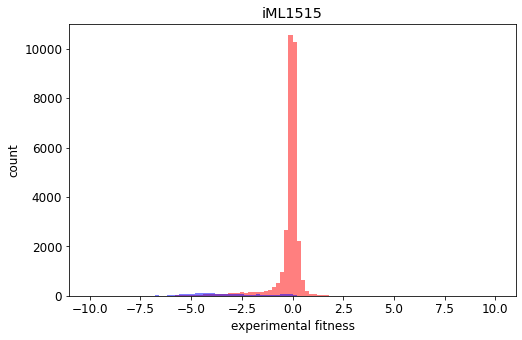

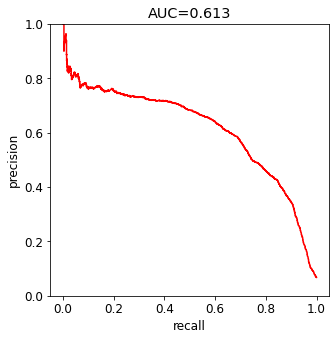

In [218]:
# load data
model_name = 'iML1515'
data_fitness_sim = np.load(model_name+'_fitness_sim.npy')
data_fitness = np.load(model_name+'_fitness.npy')

# plot histogram
ylim = [0,1000]
[fig,axs,BAC_iML1515,AC_iML1515] = plot_histogram(model_name,data_fitness_sim,data_fitness,ylim)
image_format = 'svg'
image_name = 'plots/'+model_name+'_histogram.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

ylim = [0,11000]
[fig,axs,BAC_iML1515,AC_iML1515] = plot_histogram(model_name,data_fitness_sim,data_fitness,ylim)
image_format = 'svg'
image_name = 'plots/'+model_name+'_histogram_full.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

# plot precision recall curve
[fig,axs,AUC_iML1515] = plot_precision_recall_curve(model_name,data_fitness_sim,data_fitness)
image_format = 'svg'
image_name = 'plots/'+model_name+'_pre_rec.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

#### Plotting Model Performance Comparisons

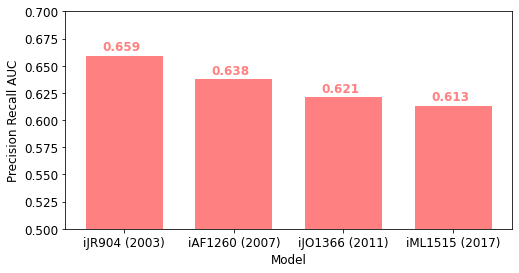

In [219]:
fig, axs = plt.subplots(1,1,figsize=[8,4])
axs.bar([1,2,3,4],[AUC_iJR904,AUC_iAF1260,AUC_iJO1366,AUC_iML1515],width=0.7,color=[1,0.5,0.5])
#plt.legend(loc="lower left")
axs.set_xlabel('Model');
axs.set_ylabel('Precision Recall AUC');
axs.set_xticks([1,2,3,4]);
axs.set_xticklabels(['iJR904 (2003)','iAF1260 (2007)','iJO1366 (2011)','iML1515 (2017)']);
axs.set_ylim([0.5,0.7]);
for i,v in enumerate([AUC_iJR904,AUC_iAF1260,AUC_iJO1366,AUC_iML1515]):
    axs.text(i+0.8,v+0.005,np.round(v,3),color=[1,0.5,0.5], fontweight='bold')

image_format = 'svg'
image_name = 'plots/precision_recall.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

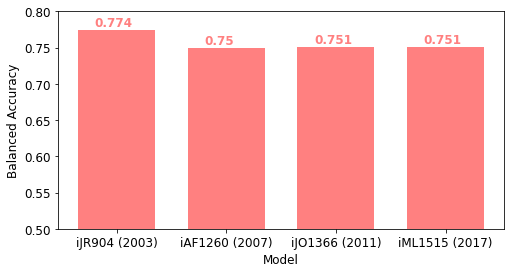

In [220]:
fig, axs = plt.subplots(1,1,figsize=[8,4])
axs.bar([1,2,3,4],[BAC_iJR904,BAC_iAF1260,BAC_iJO1366,BAC_iML1515],width=0.7,color=[1,0.5,0.5])
#plt.legend(loc="lower left")
axs.set_xlabel('Model');
axs.set_ylabel('Balanced Accuracy');
axs.set_xticks([1,2,3,4]);
axs.set_xticklabels(['iJR904 (2003)','iAF1260 (2007)','iJO1366 (2011)','iML1515 (2017)']);
axs.set_ylim([0.5,0.8]);
for i,v in enumerate([BAC_iJR904,BAC_iAF1260,BAC_iJO1366,BAC_iML1515]):
    axs.text(i+0.8,v+0.005,np.round(v,3),color=[1,0.5,0.5], fontweight='bold')

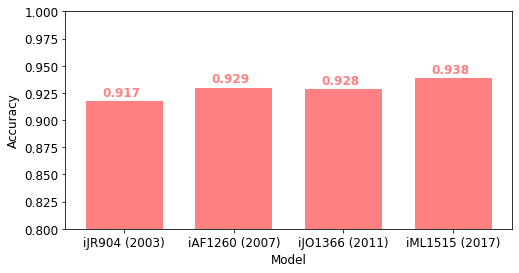

In [221]:
fig, axs = plt.subplots(1,1,figsize=[8,4])
axs.bar([1,2,3,4],[AC_iJR904,AC_iAF1260,AC_iJO1366,AC_iML1515],width=0.7,color=[1,0.5,0.5])
#plt.legend(loc="lower left")
axs.set_xlabel('Model');
axs.set_ylabel('Accuracy');
axs.set_xticks([1,2,3,4]);
axs.set_xticklabels(['iJR904 (2003)','iAF1260 (2007)','iJO1366 (2011)','iML1515 (2017)']);
axs.set_ylim([0.8,1]);
for i,v in enumerate([AC_iJR904,AC_iAF1260,AC_iJO1366,AC_iML1515]):
    axs.text(i+0.8,v+0.005,np.round(v,3),color=[1,0.5,0.5], fontweight='bold')

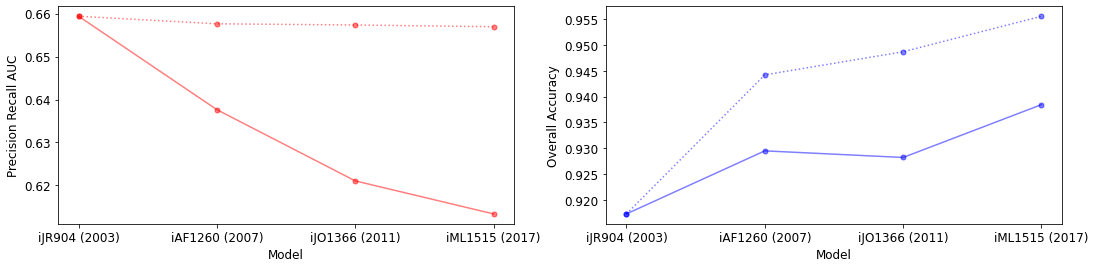

In [250]:
# Plot Precision recall AUC and Overall Accuracy Together with Null Model
fig, axs = plt.subplots(1,2,figsize=[18,4])
axs[0].plot([1,2,3,4],[AUC_iJR904,AUC_iAF1260,AUC_iJO1366,AUC_iML1515],'r.',markersize=10,alpha=0.5)
axs[0].plot([1,2,3,4],[AUC_iJR904,AUC_iAF1260,AUC_iJO1366,AUC_iML1515],'r',alpha=0.5)
axs[0].plot([1,2,3,4],AUC_i,'r.',markersize=10,alpha=0.5)
axs[0].plot([1,2,3,4],AUC_i,'r:',alpha=0.5)

axs[1].plot([1,2,3,4],[AC_iJR904,AC_iAF1260,AC_iJO1366,AC_iML1515],'b.',markersize=10,alpha=0.5)
axs[1].plot([1,2,3,4],[AC_iJR904,AC_iAF1260,AC_iJO1366,AC_iML1515],'b',alpha=0.5)
axs[1].plot([1,2,3,4],AC_i,'b.',markersize=10,alpha=0.5)
axs[1].plot([1,2,3,4],AC_i,'b:',alpha=0.5)

#plt.legend(loc="lower left")
axs[0].set_xlabel('Model');
axs[0].set_ylabel('Precision Recall AUC');
axs[0].set_xticks([1,2,3,4]);
axs[0].set_xticklabels(['iJR904 (2003)','iAF1260 (2007)','iJO1366 (2011)','iML1515 (2017)']);
#axs[0].set_ylim([0.5,0.7]);
#for i,v in enumerate([AUC_iJR904,AUC_iAF1260,AUC_iJO1366,AUC_iML1515]):
#    axs[0].text(i+0.86,v-0.015,np.round(v,3),color=[1,0.5,0.5], fontweight='bold')

axs[1].set_xlabel('Model');
axs[1].set_ylabel('Overall Accuracy');
axs[1].set_xticks([1,2,3,4]);
axs[1].set_xticklabels(['iJR904 (2003)','iAF1260 (2007)','iJO1366 (2011)','iML1515 (2017)']);
#axs[1].set_ylim([0.8,1]);
#for i,v in enumerate([AC_iJR904,AC_iAF1260,AC_iJO1366,AC_iML1515]):
#    axs[1].text(i+0.86,v-0.015,np.round(v,3),color=[0.5,0.5,1], fontweight='bold')

image_format = 'svg'
image_name = 'plots/null_performance.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

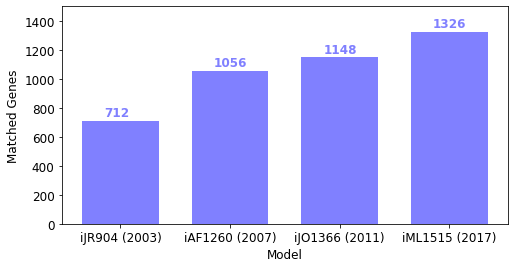

In [164]:
# loading gene_count data
num_genes = np.load('num_genes.npy')

fig, axs = plt.subplots(1,1,figsize=[8,4])
axs.bar([1,2,3,4],num_genes,width=0.7,color=[0.5,0.5,1]);
axs.set_xlabel('Model');
axs.set_ylabel('Matched Genes');
axs.set_xticks([1,2,3,4]);
axs.set_xticklabels(['iJR904 (2003)','iAF1260 (2007)','iJO1366 (2011)','iML1515 (2017)']);
axs.set_ylim([0,1500])
for i,v in enumerate(num_genes):
    axs.text(i+0.85,v+30,v,color=[0.5,0.5,1], fontweight='bold')

image_format = 'svg'
image_name = 'plots/num_genes.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

## Part 3: iML1515 Adjustment Comparisons
In this section the iML1515 model is analyzed while changing several different variables to demonstrate the impact of the choices that were made for the overall analysis. The variables that are examined are: the adjustment of the model to match the BW25113 strain, the exclusion of mannitol and sucrose from the analysis, and the exclusion of unconditionally essential genes from the analysis.

### Part 3a: Running Flux Balance Analysis

In [527]:
# Load environment
[name_medium_model, name_carbon_model, name_carbon_experiment] = load_environment(base_directory)

# Load Data
[data_experiments,data_genes,data_fitness] = load_data(base_directory)

In [528]:
model_name = 'iML1515'
# load model
print('loading model')
model = load_model(model_name,base_directory)

# match model to data
print('matching model and data')
[name_genes_matched,name_carbon_experiment_matched,name_carbon_model_matched,data_fitness_matched] = match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness)

# adjust model no (no adjustments)
print('no adjustment')
print('adjusting model')
adj_strain = 0
adj_essential = 0
adj_carbon = 0
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_no_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# check environment
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_matched_no_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)
# save data
np.save(model_name+'_fitness_sim_NoAdj.npy',np.asarray(data_fitness_simulated_matched_no_adj,dtype=np.double))
np.save(model_name+'_fitness_NoAdj.npy',np.asarray(data_fitness_matched_no_adj,dtype=np.double))
print(f'\n')

# adjust model strain (BW25113)
print('strain adjustment')
print('adjusting model')
adj_strain = 1
adj_essential = 0
adj_carbon = 0
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_strain_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# check environment
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_matched_strain_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)
# save data
np.save(model_name+'_fitness_sim_StrainAdj.npy',np.asarray(data_fitness_simulated_matched_strain_adj,dtype=np.double))
np.save(model_name+'_fitness_StrainAdj.npy',np.asarray(data_fitness_matched_strain_adj,dtype=np.double))
print(f'\n')

# adjust model essential (uncoditional essential gene exclusion)
print('essential genes adjustment')
print('adjusting model')
adj_strain = 0
adj_essential = 1
adj_carbon = 0
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_essential_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# check environment
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_matched_essential_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)
# save data
np.save(model_name+'_fitness_sim_EssentialAdj.npy',np.asarray(data_fitness_simulated_matched_essential_adj,dtype=np.double))
np.save(model_name+'_fitness_EssentialAdj.npy',np.asarray(data_fitness_matched_essential_adj,dtype=np.double))
print(f'\n')

# adjust model carbon (sucrose + manitol exclusion)
print('carbon adjustment')
print('adjusting model')
adj_strain = 0
adj_essential = 0
adj_carbon = 1
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_carbon_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# check environment
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_matched_carbon_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)
# save data
np.save(model_name+'_fitness_sim_CarbonAdj.npy',np.asarray(data_fitness_simulated_matched_carbon_adj,dtype=np.double))
np.save(model_name+'_fitness_CarbonAdj.npy',np.asarray(data_fitness_matched_carbon_adj,dtype=np.double))
print(f'\n')

# adjust model strain + essential
print('strain + essential adjustment')
print('adjusting model')
adj_strain = 1
adj_essential = 1
adj_carbon = 0
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_carbon_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# check environment
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_matched_carbon_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)
# save data
np.save(model_name+'_fitness_sim_StrainEssentialAdj.npy',np.asarray(data_fitness_simulated_matched_carbon_adj,dtype=np.double))
np.save(model_name+'_fitness_StrainEssentialAdj.npy',np.asarray(data_fitness_matched_carbon_adj,dtype=np.double))
print(f'\n')

# adjust model strain + carbon
print('strain + carbon adjustment')
print('adjusting model')
adj_strain = 1
adj_essential = 0
adj_carbon = 1
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_carbon_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# check environment
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_matched_carbon_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)
# save data
np.save(model_name+'_fitness_sim_StrainCarbonAdj.npy',np.asarray(data_fitness_simulated_matched_carbon_adj,dtype=np.double))
np.save(model_name+'_fitness_StrainCarbonAdj.npy',np.asarray(data_fitness_matched_carbon_adj,dtype=np.double))
print(f'\n')

# adjust model essential + carbon
print('essential + carbon adjustment')
print('adjusting model')
adj_strain = 0
adj_essential = 1
adj_carbon = 1
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_carbon_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# check environment
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_matched_carbon_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)
# save data
np.save(model_name+'_fitness_sim_EssentialCarbonAdj.npy',np.asarray(data_fitness_simulated_matched_carbon_adj,dtype=np.double))
np.save(model_name+'_fitness_EssentialCarbonAdj.npy',np.asarray(data_fitness_matched_carbon_adj,dtype=np.double))
print(f'\n')


loading model
matching model and data
no adjustment
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmp41u0sx2s.lp
Reading time = 0.03 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
checking environment
medium components not found in model:
carbon components not found in model:
simulating phenotype
0.96

strain adjustment
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmplea7i2a8.lp
Reading time = 0.03 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
removing genes (strain):
b0061
b0344
b3902
checking environment
medium components not found in model:
carbon components not found in model:
simulating phenotype
0.96

essential genes adjustment
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmplubu_xof.lp
Reading time = 0.03 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
removing genes (essential):
b0142
b0641
b0908
b2329
b2687
b3040
b3196

### Part 3b: Plotting Performance of Each Adjustment

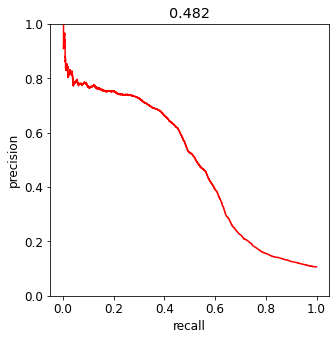

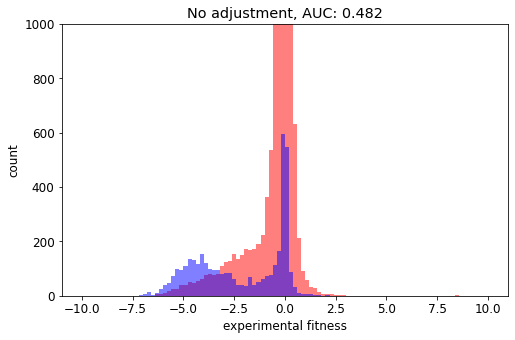

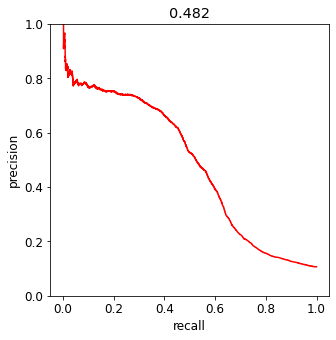

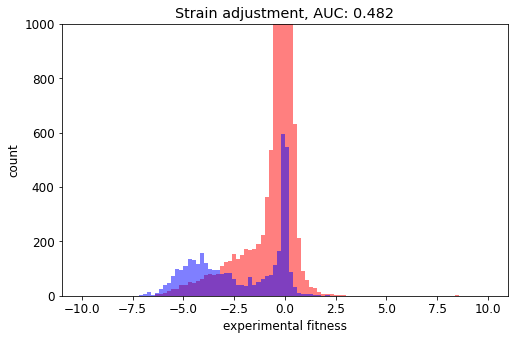

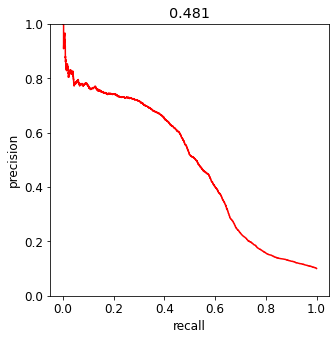

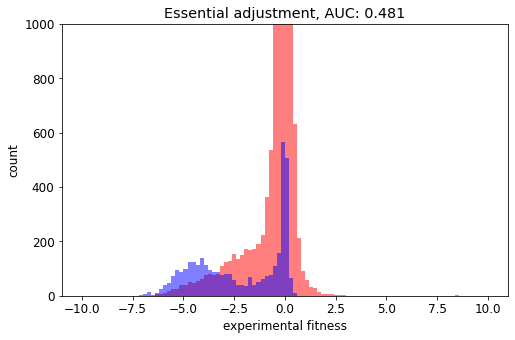

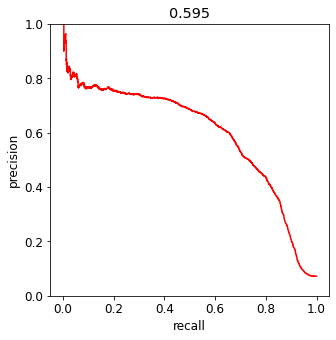

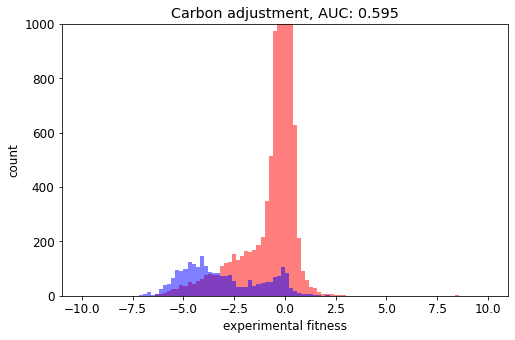

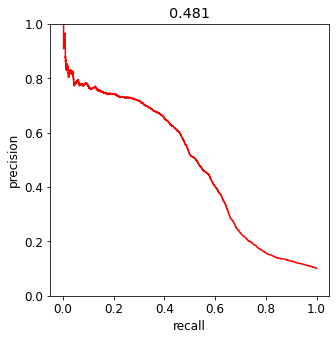

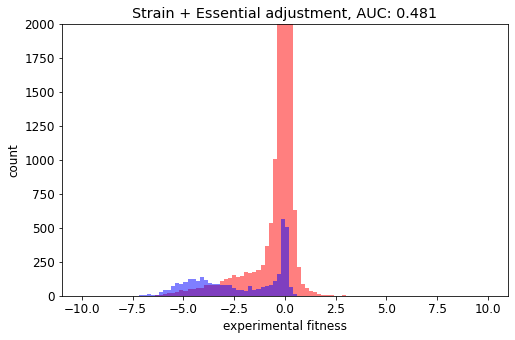

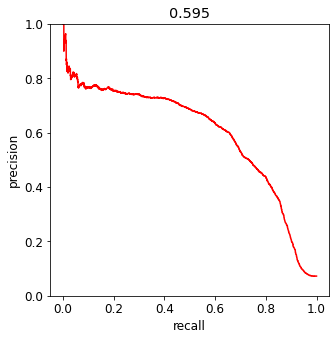

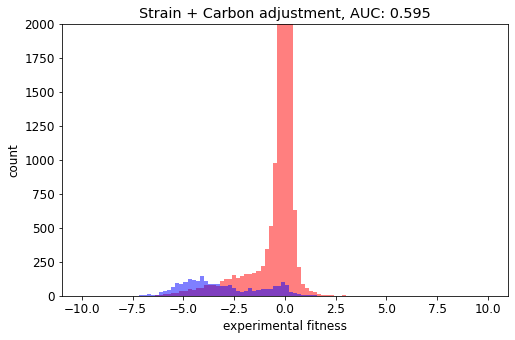

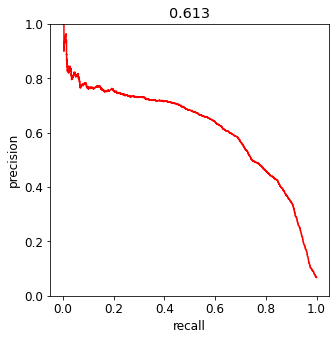

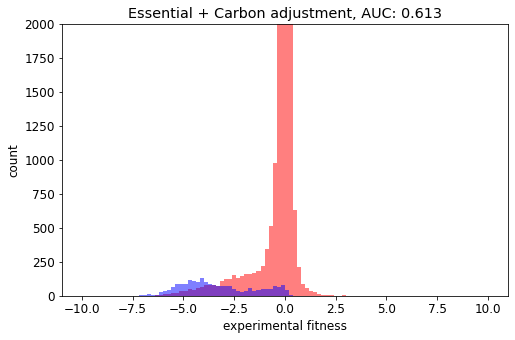

In [103]:
# load data
model_name = 'iML1515'

# Individual adjustments
adjustments = ['No','Strain','Essential','Carbon']
            
for adjustment in adjustments:
    data_fitness_sim = np.load(model_name+'_fitness_sim_'+adjustment+'Adj.npy')
    data_fitness = np.load(model_name+'_fitness_'+adjustment+'Adj.npy')
    # plot precision recall curve
    [fig,axs,AUC] = plot_precision_recall_curve(model_name,data_fitness_sim,data_fitness)
    axs.set_title(np.round(AUC,3))
    # plot histogram
    ylim = [0,1000]
    [fig,axs,_,_] = plot_histogram(model_name,data_fitness_sim,data_fitness,ylim)
    axs.set_title(adjustment+' adjustment, AUC: '+str(np.round(AUC,3)))

    image_format = 'svg'
    image_name = 'plots/'+model_name+'_adj_histogram_'+adjustment+'.svg'
    fig.savefig(image_name, format=image_format, dpi=1200)
    
for i in range(1,len(adjustments)):
    for j in range(i+1,len(adjustments)):
        adjustment = adjustments[i]+'_'+adjustments[j]
        adjustment_load = adjustments[i]+adjustments[j]
        data_fitness_sim = np.load(model_name+'_fitness_sim_'+adjustment_load+'Adj.npy')
        data_fitness = np.load(model_name+'_fitness_'+adjustment_load+'Adj.npy')
        
        # plot precision recall curve
        [fig,axs,AUC] = plot_precision_recall_curve(model_name,data_fitness_sim,data_fitness)
        axs.set_title(np.round(AUC,3))
        # plot histogram
        ylim = [0,2000]
        [fig,axs,_,_] = plot_histogram(model_name,data_fitness_sim,data_fitness,ylim)
        tmp = str.split(adjustment,'_')
        axs.set_title(tmp[0]+' + '+tmp[1]+' adjustment, AUC: '+str(np.round(AUC,3)))
        
        image_format = 'svg'
        image_name = 'plots/'+model_name+'_adj_histogram_'+adjustment+'.svg'
        fig.savefig(image_name, format=image_format, dpi=1200)

## Part 4: Wild Type vs Core Biomass

Check the model biomass function. For the most recent models (iJO1366 and iML1515) there is a core and wild type (WT) biomass. This section was intended to check the performance of the model when using the WT biomass. The wild type biomass was first tested for growth on all carbon sources (without any gene knockouts). The models could not simulate growth in this scenario, and will thus not simulate growth in any gene knockout scenarios, so the full analysis of simulated growth was not conducted with the wild type flux, and the use of the core biomass is justified throughout this analysis.

In [261]:
# Load models and check for biomass reactions
# we check by looking at what the objective function is and then printing out the top 5 reactions involving the most metabolites
# iJR904 and iAF1260 have one biomass equations
# iJO1366 and iML1515 both have a core and WT biomass with the objective set to the core
model_names = ['iJR904','iAF1260','iJO1366','iML1515']

for active_model in model_names:
    model = cobra.io.read_sbml_model(base_directory+'/Models/'+active_model+'.xml')
    print(active_model)
    print(model.objective)
    r_id = []
    r_name = []
    r_num_mets = []
    for reaction in model.reactions:
        r_id.append(reaction.id)
        r_name.append(reaction.name)
        r_num_mets.append(len(reaction.metabolites))
        
    ind_sort = np.argsort(np.array(r_num_mets)*-1)
    for i in range(5):
        print(r_id[ind_sort[i]],r_num_mets[ind_sort[i]])
    print(f'\n')


iJR904
Maximize
1.0*BIOMASS_Ecoli - 1.0*BIOMASS_Ecoli_reverse_bf7a1
BIOMASS_Ecoli 53
FAO1 12
THZPSN 12
FAO2 12
FAO3 12


iAF1260
Maximize
1.0*BIOMASS_Ec_iAF1260_core_59p81M - 1.0*BIOMASS_Ec_iAF1260_core_59p81M_reverse_3925e
BIOMASS_Ec_iAF1260_core_59p81M 67
THZPSN 12
PDX5PS 9
OMPHHX3 9
OPHHX3 9


iJO1366
Maximize
1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
BIOMASS_Ec_iJO1366_WT_53p95M 106
BIOMASS_Ec_iJO1366_core_53p95M 72
THZPSN3 13
S2FE2SS 12
S2FE2SS2 12


iML1515
Maximize
1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
BIOMASS_Ec_iML1515_WT_75p37M 99
BIOMASS_Ec_iML1515_core_75p37M 70
THZPSN3 13
S2FE2SS2 12
S2FE2SS 12




In [262]:
# Re-run FBA with iML1515 WT Biomass
# The model doesn't grow even with no gene knock-outs when using the WT biomass so this is not an option
# This cell was stopped short of running due to this.

# Load environment
[name_medium_model, name_carbon_model, name_carbon_experiment] = load_environment(base_directory)

# Load Data
[data_experiments,data_genes,data_fitness] = load_data(base_directory)

model_names = ['iML1515']
for ind,model_name in enumerate(model_names):
    print(model_name)
    
    # load model
    print('loading model')
    model = load_model(model_name,base_directory)
    # optional printout check
    print(str(len(model.genes))+' total genes in model')
    
    # match model to data
    print('matching model and data')
    [name_genes_matched,name_carbon_experiment_matched,name_carbon_model_matched,data_fitness_matched] = match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness)
    # optional printout checks
    print(str(len(name_genes_matched))+' genes matched')
    print(str(len(name_carbon_model_matched))+' carbon matched')
    
    # adjust model
    print('adjusting model')
    adj_strain = 1
    adj_essential = 1
    adj_carbon = 1
    [model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
    # optional printout checks
    print(str(len(name_genes_matched_adj)),' adjusted genes matched')
    print(str(len(name_carbon_model_matched_adj)),' adjusted carbon matched')
    print(str(data_fitness_matched_adj.shape),' data shape')
    
    # change objective to wild type
    model_adj.objective = 'BIOMASS_Ec_iML1515_WT_75p37M'
    
    # get medium and carbon exchange indicies
    print('checking environment')
    [medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
    
    # test growth
    print('testing growth')
    test_growth(model_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)
    
    # simulate phenotype
    #print('simulating phenotype')
    #data_fitness_simulated_matched_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)
    
    # save data
    #np.save('data_fitness_simulated_matched_adj_WTobj'+'_'+model_name+'.npy',np.asarray(data_fitness_simulated_matched_adj,dtype=np.double))
    
    print(f'\n')


iML1515
loading model
1516 total genes in model
matching model and data
1339 genes matched
27 carbon matched
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmpyo8esakq.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
removing genes (strain):
b0061
b0344
b3902
removing genes (essential):
b0142
b0641
b0908
b2329
b2687
b3040
b3196
b3198
b3199
b3368
removing carbon sources:
man
sucr
1326  adjusted genes matched
25  adjusted carbon matched
(1326, 25)  data shape
checking environment
medium components not found in model:
carbon components not found in model:
testing growth


/Users/david/opt/anaconda3/envs/ML_MM_4/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Growth With No C Source: -1
0 Growth With C Source: ac -1.0
1 Growth With C Source: acgam -1.0
2 Growth With C Source: akg -1.0
3 Growth With C Source: fru -1.0
4 Growth With C Source: fuc__L -1.0
5 Growth With C Source: g6p -1.0
6 Growth With C Source: gal -1.0
7 Growth With C Source: galur -1.0
8 Growth With C Source: gam -1.0
9 Growth With C Source: glc__D -1.0
10 Growth With C Source: glcn -1.0
11 Growth With C Source: glcur -1.0
12 Growth With C Source: glyc -1.0
13 Growth With C Source: glyclt -1.0
14 Growth With C Source: lac__D -1.0
15 Growth With C Source: mal__L -1.0
16 Growth With C Source: malt -1.0
17 Growth With C Source: mnl -1.0
18 Growth With C Source: pyr -1.0
19 Growth With C Source: rib__D -1.0
20 Growth With C Source: sbt__D -1.0
21 Growth With C Source: ser__D -1.0
22 Growth With C Source: succ -1.0
23 Growth With C Source: tre -1.0
24 Growth With C Source: xyl__D -1.0




## Part 5: iML1515 Visualize Results

In [284]:
# load data
model_name = 'iML1515'
model = cobra.io.read_sbml_model(base_directory+'/Models/'+model_name+'.xml')
data_fitness_sim_unique = np.load(model_name+'_fitness_sim.npy')
data_fitness_unique = np.load(model_name+'_fitness.npy')
name_carbon_unique = np.load(model_name+'_names_carbon_model.npy')
name_genes_data = np.load(model_name+'_names_genes.npy')

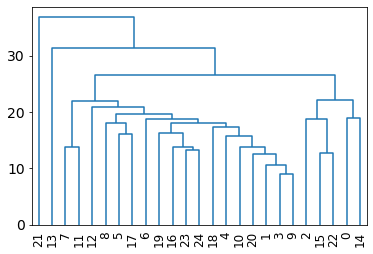

In [285]:
# Visualize the data
g_mean_data_f = np.mean(data_fitness_unique,1)
g_sortinds = np.argsort(g_mean_data_f)

#c_mean_data_f = np.mean(data_fitness_unique,0)
#c_mean_data_f_sortinds = np.argsort(c_mean_data_f)
Z = linkage(np.transpose(data_fitness_unique),'average')
D = dendrogram(Z,leaf_rotation=90,leaf_font_size=12,color_threshold=0)
D_inds = D['leaves']
c_sortinds = D_inds

data_fitness_sort = data_fitness_unique[g_sortinds,:][:,c_sortinds]
data_fitness_sim_sort = data_fitness_sim_unique[g_sortinds,:][:,c_sortinds]

name_genes_data_sort = name_genes_data[g_sortinds]
name_carbon_sort = np.array(name_carbon_unique)[c_sortinds]

name_genes_model_sort = []
for i in range(len(name_genes_data_sort)):
    name_genes_model_sort.append(model.genes.get_by_id(name_genes_data_sort[i]).name)

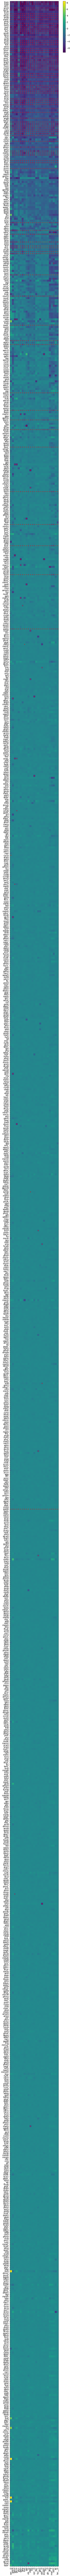

In [286]:
fig, ax = plt.subplots(figsize = [10,300])
vma = np.max(data_fitness_sort)
vmi = np.min(data_fitness_sort)
p=ax.imshow(data_fitness_sort,vmin=vmi,vmax=vma,cmap='viridis')
ax.set_yticks(range(len(name_genes_data_sort)));
ax.set_yticklabels(np.array(name_genes_model_sort));
ax.set_xticks(range(len(name_carbon_sort)));
ax.set_xticklabels(name_carbon_sort);
plt.xticks(rotation=90);
for i in range(data_fitness_sim_sort.shape[0]):
    for j in range(data_fitness_sim_sort.shape[1]):
        if data_fitness_sim_sort[i,j]<=0.001:
            ax.plot(j,i,'r.')
fig.colorbar(p,location='right',anchor=(0,1),shrink=0.02);

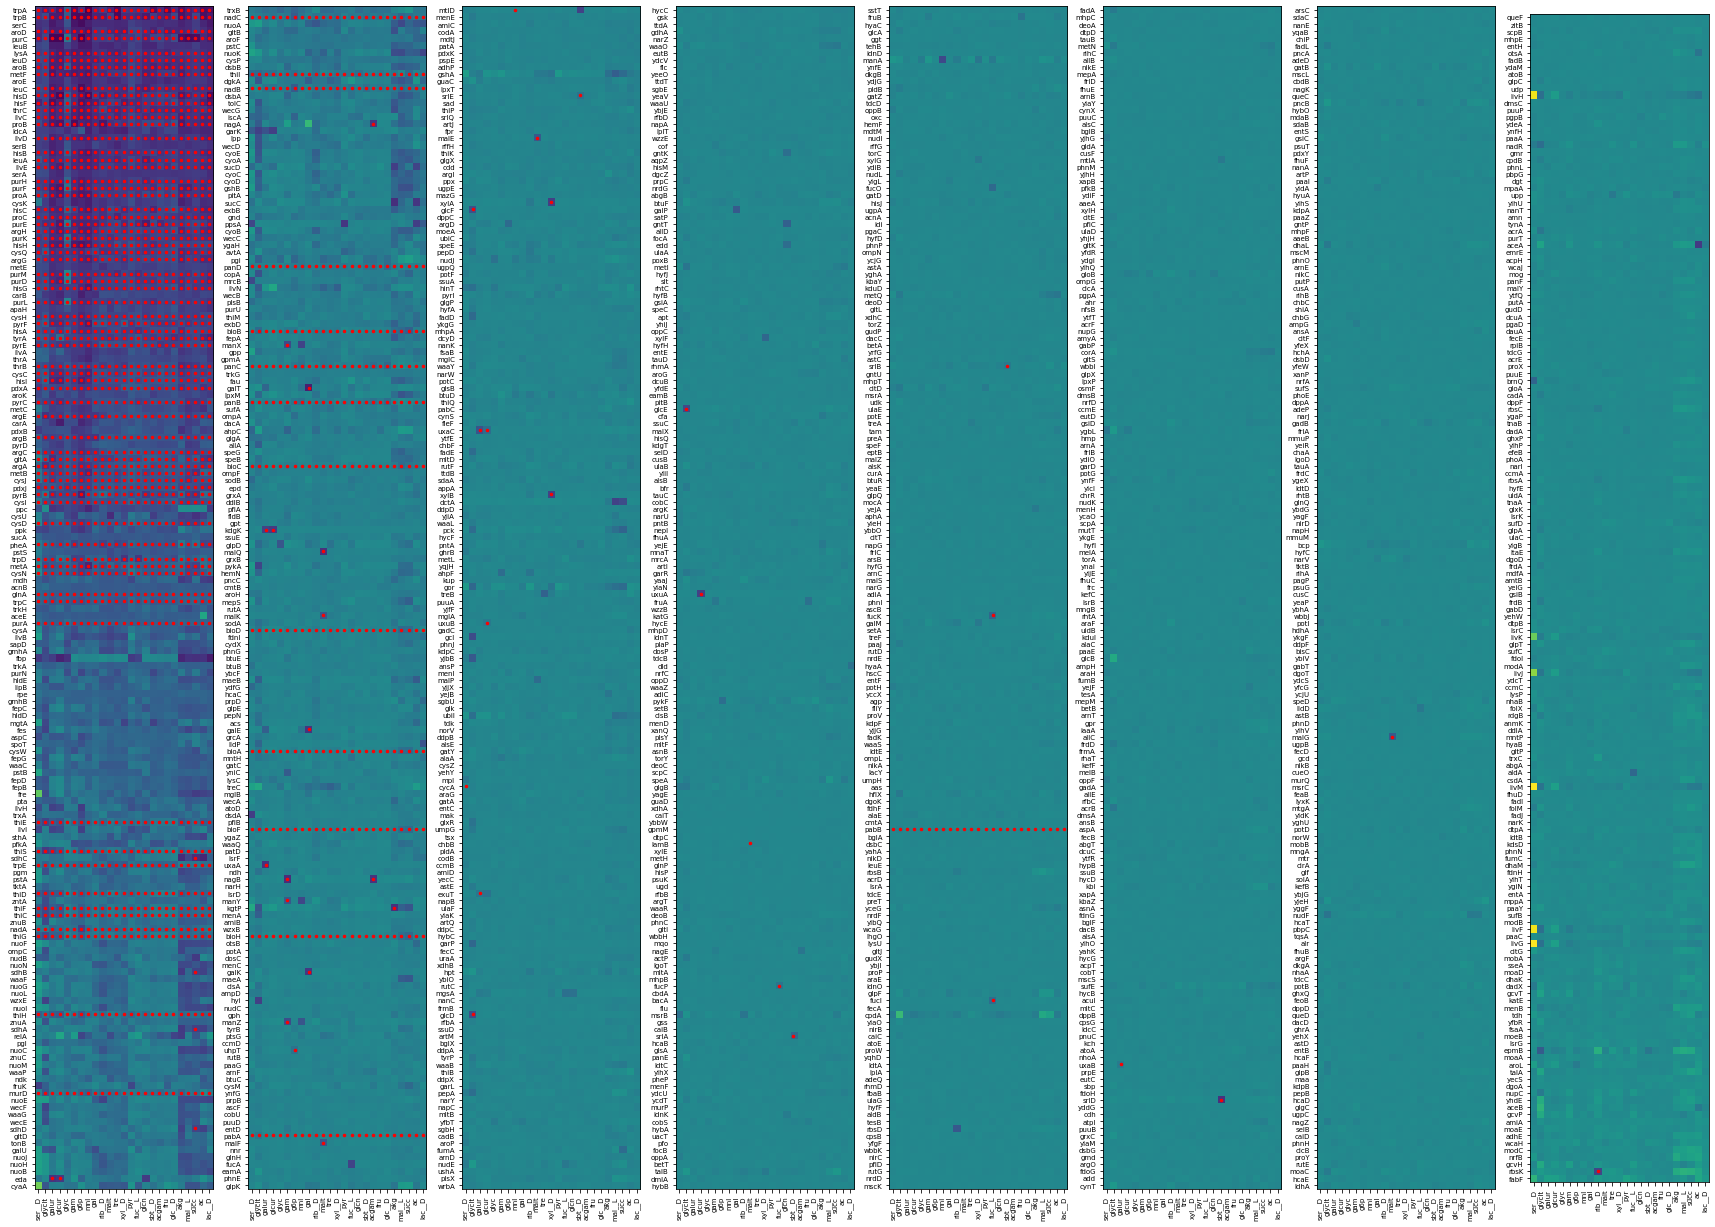

In [287]:
fig, axs = plt.subplots(1,8,figsize = [30,30])
for a in range(len(axs)):
    i1 = a
    i2 = a+1
    n = 166
    inds = np.arange(n*i1,n*i2)
    if n*i2 > data_fitness_sim_sort.shape[0]:
        inds = np.arange(n*i1,data_fitness_sim_sort.shape[0])
    p=axs[a].imshow(data_fitness_sort[inds,:],vmin=vmi,vmax=vma,cmap='viridis')
    axs[a].set_yticks(range(len(name_genes_data_sort[inds])));
    axs[a].set_yticklabels(np.array(name_genes_model_sort)[inds],fontsize=7);
    axs[a].set_xticks(range(len(name_carbon_sort)));
    axs[a].set_xticklabels(name_carbon_sort,rotation=90,fontsize=7);
    for i in inds:
        for j in range(data_fitness_sim_sort.shape[1]):
            if data_fitness_sim_sort[i,j]<=0.001:
                axs[a].plot(j,i-n*i1,'r.',markersize=5)
#fig.colorbar(p,location='right',anchor=(0,1),shrink=0.06);
# save figure
image_format = 'svg'
image_name = 'plots/'+model_name+'_results_matrix.svg'
fig.savefig(image_name, format=image_format, dpi=900)

In [303]:
name_genes_model_sort.index('gshA')

341

## Part 6: iML1515 Add Vitamins (False Negatives)
Analysis of the largest errors in the iML1515 model predictions revealed that a large number of false negatives (model predicted no growth, fitness was high) where in genes related to vitamin metabolism. We hypothesize that these vitamins may be present in the growth environment (either due to remnants from the rich library preparation medium or spill-over from the metabolism of the mutant library) and thus the genes involved in vitamin biosynthesis are not essential. Here we add select vitamins to the medium and re-calculate the accuracy of the model predictions.

The genes in the following vitamin/cofactor biosynthesis pathways had no simulated growth despite high fitness:
* tetrahydropholate, model name: thf, model exchange: no exchange
    * pabB
    * pabA
* biotin, model name: btn, model exchange: EX_btn_e
    * bioH
    * bioF
    * bioA
    * bioD
    * bioC
    * bioB
* pantothenate, model name: pnt__R, model exchange: EX_pnto__R_e
    * panB
    * panC
* NAD+, model name: nad, model exchange: no exchange
    * nadB
    * nadC
    * nadA
* thiamine, model name: thm, model exchange: EX_thm_e
    * thiL
    * thiH
    * thiG
    * thiC
    * thiF
    * thiD
    * thiS
    * thiE

### Part 6a: Individual Vitamins (Run FBA)

In [576]:
# Re run FBA (each vitamin individually)
vitamins = ['btn','pnto__R','thm','thf','nad']

model_names = ['iML1515']

# Load environment
[name_medium_model, name_carbon_model, name_carbon_experiment] = load_environment(base_directory)

# Load Data
[data_experiments,data_genes,data_fitness] = load_data(base_directory)

model_name = 'iML1515'
print(model_name)

# load model
print('loading model')
model = load_model(model_name,base_directory)
# optional printout check
print(str(len(model.genes))+' total genes in model')

# match model to data
print('matching model and data')
[name_genes_matched,name_carbon_experiment_matched,name_carbon_model_matched,data_fitness_matched] = match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness)
# optional printout checks
print(str(len(name_genes_matched))+' genes matched')
print(str(len(name_carbon_model_matched))+' carbon matched')

# adjust model
print('adjusting model')
adj_strain = 1
adj_essential = 1
adj_carbon = 1
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# optional printout checks
print(str(len(name_genes_matched_adj)),' adjusted genes matched')
print(str(len(name_carbon_model_matched_adj)),' adjusted carbon matched')
print(str(data_fitness_matched_adj.shape),' data shape')

# get medium and carbon exchange indicies
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
print(f'\n')

for i in range(5):
    print(vitamins[i])
    # Reset model exchanges
    # turn off all exchange reactions
    for ex in model_adj.exchanges:
        ex.lower_bound = 0
        ex.upper_bound = 1000
    
    # add vitamin
    if i in range(3): #exchange exists
        #turn on exchange
        model_adj.exchanges.get_by_id('EX_'+vitamins[i]+'_e').lower_bound = -1000
    else: #exchange does not exist
        # add exchange directly to intracellular metabolite
        rxn = cobra.Reaction('EX_'+vitamins[i]+'_c')
        rxn.name = 'EX_'+vitamins[i]+'_c'
        rxn.lower_bound = -1000
        rxn.upper_bound = 1000
        rxn.add_metabolites({model_adj.metabolites.get_by_id(vitamins[i]+'_c'): -1.0})
        model_adj.add_reactions([rxn])
    
    # simulate phenotype
    print('simulating phenotype')
    data_fitness_simulated_matched_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)

    # save data
    np.save(model_name+'_fitness_sim_vitamins_'+vitamins[i]+'.npy',np.asarray(data_fitness_simulated_matched_adj,dtype=np.double))
    
    if i in range(3,5):
        # remove added reaction
        model_adj.reactions.get_by_id(rxn.id).delete()
        
    print(f'\n')

iML1515
loading model
1516 total genes in model
matching model and data
1339 genes matched
27 carbon matched
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmp_m1xp8t6.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
removing genes (strain):
b0061
b0344
b3902
removing genes (essential):
b0142
b0641
b0908
b2329
b2687
b3040
b3196
b3198
b3199
b3368
removing carbon sources:
man
sucr
1326  adjusted genes matched
25  adjusted carbon matched
(1326, 25)  data shape
checking environment
medium components not found in model:
carbon components not found in model:


btn
simulating phenotype
0.96

pnto__R
simulating phenotype
0.96

thm
simulating phenotype
0.96

thf
simulating phenotype
0.96

nad
simulating phenotype
0.96



### Part 6b: Individual Vitamins (Plot Results)

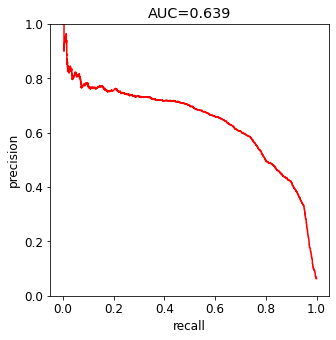

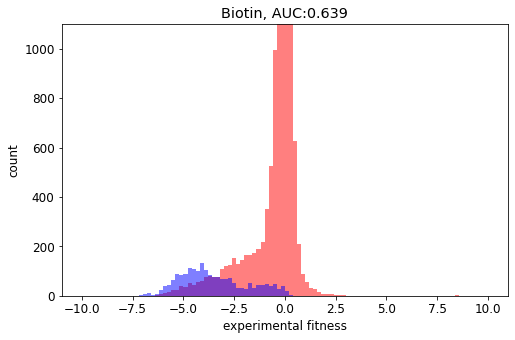

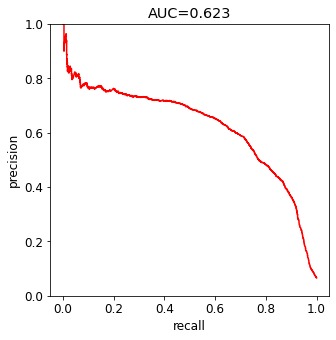

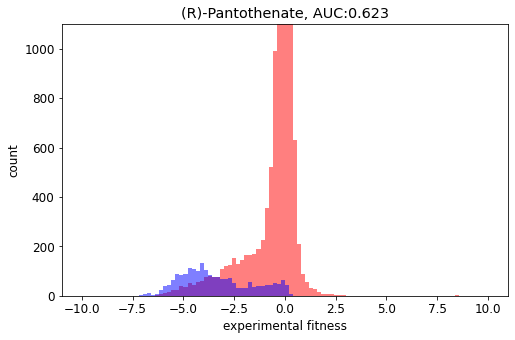

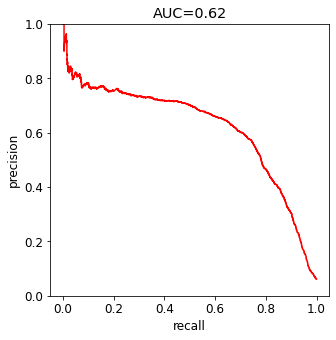

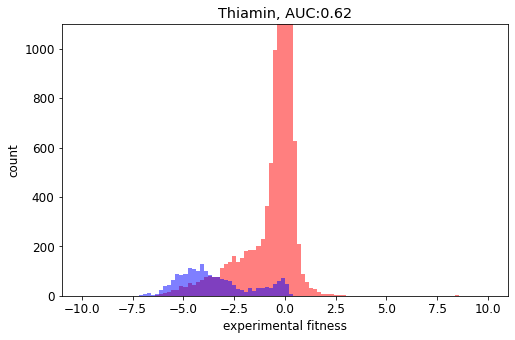

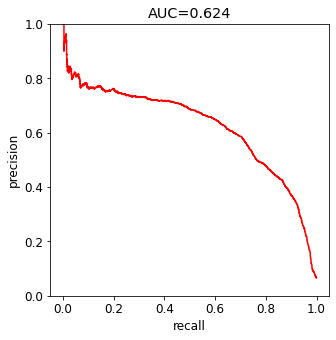

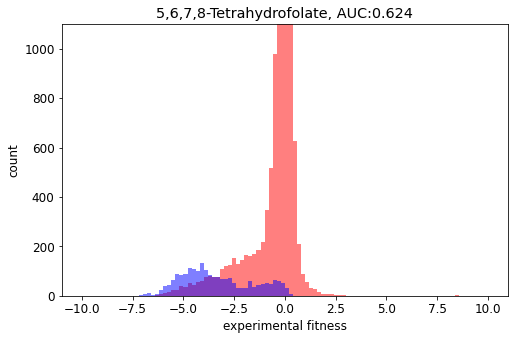

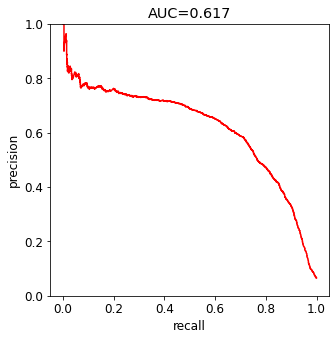

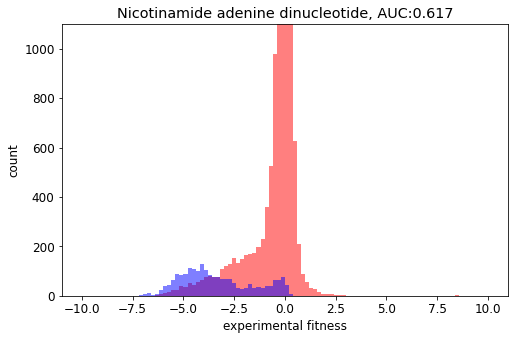

In [241]:
# Load data and visualize results
# load data
vitamins = ['btn','pnto__R','thm','thf','nad']
vitamin_names = ['Biotin','(R)-Pantothenate','Thiamin','5,6,7,8-Tetrahydrofolate','Nicotinamide adenine dinucleotide']
model_name = 'iML1515'

# load fitness data
data_fitness_unique = np.load(model_name+'_fitness.npy')
    
for v in range(len(vitamins)):
    data_fitness_sim_unique = np.load(model_name+'_fitness_sim_vitamins_'+vitamins[v]+'.npy')
    
    # plot precision recall curve
    [fig,axs,AUC] = plot_precision_recall_curve(model_name,data_fitness_sim_unique,data_fitness_unique)
    
    # plot histogram
    ylim = [0,1100]
    [fig,axs,_,_] = plot_histogram(model_name,data_fitness_sim_unique,data_fitness_unique,ylim)
    axs.set_title(vitamin_names[v]+', AUC:'+str(np.round(AUC,3)))
    image_format = 'svg'
    image_name = 'plots/'+model_name+'_vitamins_hist_'+vitamins[v]+'.svg'
    fig.savefig(image_name, format=image_format, dpi=900)

### Part 6c: All Vitamins (Run FBA)

In [593]:
# Re run FBA (each vitamin individually)
vitamins = ['btn','pnto__R','thm','thf','nad']

model_names = ['iML1515']

# Load environment
[name_medium_model, name_carbon_model, name_carbon_experiment] = load_environment(base_directory)

# Load Data
[data_experiments,data_genes,data_fitness] = load_data(base_directory)

model_name = 'iML1515'
print(model_name)

# load model
print('loading model')
model = load_model(model_name,base_directory)
# optional printout check
print(str(len(model.genes))+' total genes in model')

# match model to data
print('matching model and data')
[name_genes_matched,name_carbon_experiment_matched,name_carbon_model_matched,data_fitness_matched] = match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness)
# optional printout checks
print(str(len(name_genes_matched))+' genes matched')
print(str(len(name_carbon_model_matched))+' carbon matched')

# adjust model
print('adjusting model')
adj_strain = 1
adj_essential = 1
adj_carbon = 1
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# optional printout checks
print(str(len(name_genes_matched_adj)),' adjusted genes matched')
print(str(len(name_carbon_model_matched_adj)),' adjusted carbon matched')
print(str(data_fitness_matched_adj.shape),' data shape')

# get medium and carbon exchange indicies
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
print(f'\n')

print('exchanged vitamins')

# Reset model exchanges
# turn off all exchange reactions (these should be off but just to make sure)
for ex in model_adj.exchanges:
    ex.lower_bound = 0
    ex.upper_bound = 1000
    
for i in range(3):
    # add vitamin
    #turn on exchange
    model_adj.exchanges.get_by_id('EX_'+vitamins[i]+'_e').lower_bound = -1000
    
# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_matched_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)

# save data
np.save(model_name+'_fitness_sim_vitamins_exchanged.npy',np.asarray(data_fitness_simulated_matched_adj,dtype=np.double))

print(f'\n')

print('all vitamins')

for i in range(3,5):
    # add vitamin
    # add exchange directly to intracellular metabolite
    rxn = cobra.Reaction('EX_'+vitamins[i]+'_c')
    rxn.name = 'EX_'+vitamins[i]+'_c'
    rxn.lower_bound = -1000
    rxn.upper_bound = 1000
    rxn.add_metabolites({model_adj.metabolites.get_by_id(vitamins[i]+'_c'): -1.0})
    model_adj.add_reactions([rxn])    

# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_matched_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)

# save data
np.save(model_name+'_fitness_sim_vitamins_all.npy',np.asarray(data_fitness_simulated_matched_adj,dtype=np.double))


iML1515
loading model
1516 total genes in model
matching model and data
1339 genes matched
27 carbon matched
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmpthwx556q.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
removing genes (strain):
b0061
b0344
b3902
removing genes (essential):
b0142
b0641
b0908
b2329
b2687
b3040
b3196
b3198
b3199
b3368
removing carbon sources:
man
sucr
1326  adjusted genes matched
25  adjusted carbon matched
(1326, 25)  data shape
checking environment
medium components not found in model:
carbon components not found in model:


simulating phenotype
simulating phenotype


### Part 6d: All Vitamins (Plot Results)

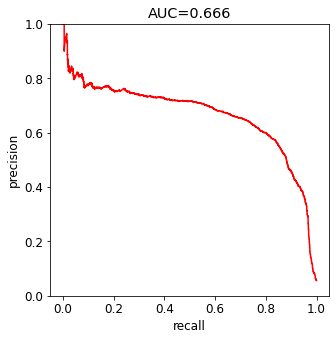

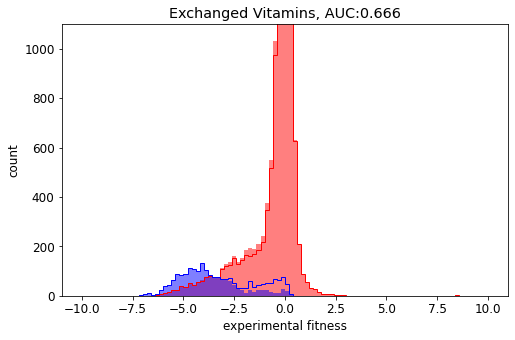

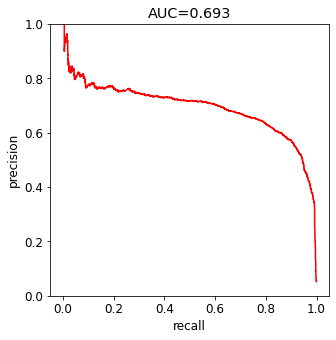

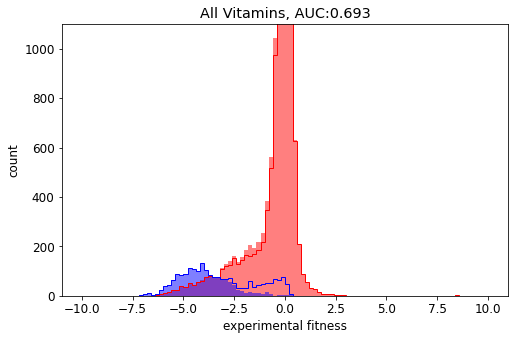

In [242]:
# Load data and visualize results
# load data
vitamins = ['btn','pnto__R','thm','thf','nad']

model_name = 'iML1515'
    
data_fitness_unique = np.load(model_name+'_fitness.npy')

# Exchanged Vitamins
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_vitamins_exchanged.npy')

# plot precision recall curve
[fig,axs,AUC] = plot_precision_recall_curve(model_name,data_fitness_sim_unique,data_fitness_unique)

# plot histogram
ylim = [0,1100]
[fig,axs,_,_] = plot_histogram(model_name,data_fitness_sim_unique,data_fitness_unique,ylim)

# add old data outline to plot
data_fitness_sim_unique_orig = np.load(model_name+'_fitness_sim.npy')
sim_thresh = 0.001
data_sim_b = (data_fitness_sim_unique_orig > sim_thresh).astype(int)

# plot old histogram
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==1],bins=100,range=(-10,10),histtype=u'step',edgecolor='r',facecolor=[1,1,1,0],lw=1)
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==0],bins=100,range=(-10,10),histtype=u'step',edgecolor='b',facecolor=[1,1,1,0],lw=1)
axs.set_ylim(ylim)
axs.set_title('Exchanged Vitamins'+', AUC:'+str(np.round(AUC,3)))
image_format = 'svg'
image_name = 'plots/'+model_name+'_vitamins_hist_exchanged.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

# All Vitamins
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_vitamins_all.npy')

# plot precision recall curve
[fig,axs,AUC] = plot_precision_recall_curve(model_name,data_fitness_sim_unique,data_fitness_unique)

# plot histogram
ylim = [0,1100]
[fig,axs,_,_] = plot_histogram(model_name,data_fitness_sim_unique,data_fitness_unique,ylim)

# add old data outline to plot
# plot old histogram
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==1],bins=100,range=(-10,10),histtype=u'step',edgecolor='r',lw=1)
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==0],bins=100,range=(-10,10),histtype=u'step',edgecolor='b',lw=1)
axs.set_ylim(ylim)
axs.set_title('All Vitamins'+', AUC:'+str(np.round(AUC,3)))
image_format = 'svg'
image_name = 'plots/'+model_name+'_vitamins_hist_all.svg'
fig.savefig(image_name, format=image_format, dpi=1200)

## Part 7: iML1515 L-Serine Biosynthesis (False Positives)

Genes in the L-serine biosynthesis pathway (serA, serB, and serC) have low fitness across all carbon sources but are non-essential in simulations. Here we will look into how the model is producing L-serine when these genes are knocked out.

### Part 7a: Investigate Fluxes (L-serine)

In [169]:
# load model
model_name = 'iML1515'
model = cobra.io.read_sbml_model(base_directory+'Models/'+model_name+'.xml')
# set up model
# turn off exchange reactions by setting lower and upper bounds to 0/1000 respectively
for ex in model.exchanges:
    ex.lower_bound = 0
    ex.upper_bound = 1000

# Adjust Model for Strain BW25113
strain_gene_remove = ['araA','araB','valX','rhaA','rhaB','araD','lacZ','rhaD']
# ID's of the genes to be removed were found through search at http://bigg.ucsd.edu/models/iML1515/genes
# Genome variations from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4200154/ and https://bioinfo.ccs.usherbrooke.ca/BW25113.html
strain_gene_remove_id = ['b0062','b0063','b3903','b3904','b0061','b0344','b3902']
model_adj = copy.deepcopy(model)
#Knocking out the genes from the model
for i in range(len(strain_gene_remove_id)):
    model_adj.genes.get_by_id(strain_gene_remove_id[i]).knock_out()

# Loading the base medium
df_med = pd.read_table(base_directory+'Fitness_Data/E_coli_BW25113/exp_organism_Keio_Mapped_Media.txt', encoding='latin-1')    
med = df_med.loc[1,'M9 minimal media_noCarbon']
name_medium_model = med.split('; ')

# add base media
for e in range(len(name_medium_model)):
    model_adj.exchanges.get_by_id('EX_'+name_medium_model[e]+'_e').lower_bound = -1000

# add glucose
model_adj.exchanges.get_by_id('EX_glc__D_e').lower_bound = -10
#model_adj.exchanges.get_by_id('EX_ser__D_e').lower_bound = -10 #L-serine is produced through a different mechanism from D-serine

# No knockout
WT_sol = cobra.flux_analysis.pfba(model_adj) # simulate growth

#serC
with model_adj:
    model_adj.genes.get_by_id('b0907').knock_out()
    KO_serC_sol = cobra.flux_analysis.pfba(model_adj)

#serA
with model_adj:
    model_adj.genes.get_by_id('b2913').knock_out()
    KO_serA_sol = cobra.flux_analysis.pfba(model_adj)

#serB
with model_adj:
    model_adj.genes.get_by_id('b4388').knock_out()
    KO_serB_sol = cobra.flux_analysis.pfba(model_adj)

Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmphs8goxjk.lp
Reading time = 0.03 seconds
: 1877 rows, 5424 columns, 21150 nonzeros


In [170]:
print('wild type biomass flux',WT_sol.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])
print('KO serA biomass flux',KO_serA_sol.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])
print('KO serB biomass flux',KO_serB_sol.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])
print('KO serC biomass flux',KO_serC_sol.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])

# We see that the flux is slightly lower in the knockouts. Where is L-serine coming from?

wild type biomass flux 0.8769972144269647
KO serA biomass flux 0.859390784926027
KO serB biomass flux 0.8593907849260272
KO serC biomass flux 0.8593895486743902


In [171]:
# wild type
sol = WT_sol
met = 'ser__L_c'
for reaction in  model_adj.metabolites.get_by_id(met).reactions:
    if reaction.metabolites[model_adj.metabolites.get_by_id(met)] * sol.fluxes[reaction.id] > 0: #L-serine produced by this reaction
        print(reaction.id,reaction.name,reaction._gene_reaction_rule,sol.fluxes[reaction.id])
        
# KO SerA
sol = KO_serA_sol
met = 'ser__L_c'
for reaction in  model_adj.metabolites.get_by_id(met).reactions:
    if reaction.metabolites[model_adj.metabolites.get_by_id(met)] * sol.fluxes[reaction.id] > 0: #L-serine produced by this reaction
        print(reaction.id,reaction.name,reaction._gene_reaction_rule,sol.fluxes[reaction.id])
        
# KO SerB
sol = KO_serB_sol
met = 'ser__L_c'
for reaction in  model_adj.metabolites.get_by_id(met).reactions:
    if reaction.metabolites[model_adj.metabolites.get_by_id(met)] * sol.fluxes[reaction.id] > 0: #L-serine produced by this reaction
        print(reaction.id,reaction.name,reaction._gene_reaction_rule,sol.fluxes[reaction.id])
        
# KO SerC
sol = KO_serC_sol
met = 'ser__L_c'
for reaction in  model_adj.metabolites.get_by_id(met).reactions:
    if reaction.metabolites[model_adj.metabolites.get_by_id(met)] * sol.fluxes[reaction.id] > 0: #L-serine produced by this reaction
        print(reaction.id,reaction.name,reaction._gene_reaction_rule,sol.fluxes[reaction.id])

PSP_L Phosphoserine phosphatase (L-serine) b4388 1.5065360713446956
GHMT2r Glycine hydroxymethyltransferase, reversible b2551 -0.5176127885425152
GHMT2r Glycine hydroxymethyltransferase, reversible b2551 -0.5176127885425157
GHMT2r Glycine hydroxymethyltransferase, reversible b2551 -0.5176120439456827


In [172]:
# KOs are using GHMT2r in reverse. Let's try making it irreversible and see if that fixes the erroneous L-serine production

model_adj.reactions.get_by_id('GHMT2r').lower_bound = 0

# No knockout
WT_sol_ir = cobra.flux_analysis.pfba(model_adj) # simulate growth

#serC
with model_adj:
    model_adj.genes.get_by_id('b0907').knock_out()
    KO_serC_sol_ir = cobra.flux_analysis.pfba(model_adj)

#serA
with model_adj:
    model_adj.genes.get_by_id('b2913').knock_out()
    KO_serA_sol_ir = cobra.flux_analysis.pfba(model_adj)

#serB
with model_adj:
    model_adj.genes.get_by_id('b4388').knock_out()
    KO_serB_sol_ir = cobra.flux_analysis.pfba(model_adj)

In [173]:
print('wild type biomass flux',WT_sol_ir.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])
print('KO serA biomass flux',KO_serA_sol_ir.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])
print('KO serB biomass flux',KO_serB_sol_ir.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])
print('KO serC biomass flux',KO_serC_sol_ir.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])

wild type biomass flux 0.8769972144269674
KO serA biomass flux 0.0
KO serB biomass flux 0.0
KO serC biomass flux 0.0


In [174]:
model_adj.reactions.get_by_id('GHMT2r')

<Reaction GHMT2r at 0x7f9619e01af0>

In [176]:
model_adj.reactions.get_by_id('PSP_L')

<Reaction PSP_L at 0x7f96136b5c10>

### Part 7b: Run FBA (L-serine)

In [655]:
# Re run FBA (making GHMT2r reaction irreversible)
ir_reaction = 'GHMT2r'

model_names = ['iML1515']

# Load environment
[name_medium_model, name_carbon_model, name_carbon_experiment] = load_environment(base_directory)

# Load Data
[data_experiments,data_genes,data_fitness] = load_data(base_directory)

model_name = 'iML1515'
print(model_name)

# load model
print('loading model')
model = load_model(model_name,base_directory)
# optional printout check
print(str(len(model.genes))+' total genes in model')

# match model to data
print('matching model and data')
[name_genes_matched,name_carbon_experiment_matched,name_carbon_model_matched,data_fitness_matched] = match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness)
# optional printout checks
print(str(len(name_genes_matched))+' genes matched')
print(str(len(name_carbon_model_matched))+' carbon matched')

# adjust model
print('adjusting model')
adj_strain = 1
adj_essential = 1
adj_carbon = 1
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# optional printout checks
print(str(len(name_genes_matched_adj)),' adjusted genes matched')
print(str(len(name_carbon_model_matched_adj)),' adjusted carbon matched')
print(str(data_fitness_matched_adj.shape),' data shape')

# get medium and carbon exchange indicies
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)

# make reaction irreversible
model_adj.reactions.get_by_id(ir_reaction).lower_bound = 0

# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_matched_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)

np.save(model_name+'_fitness_sim_L-serine.npy',np.asarray(data_fitness_simulated_matched_adj,dtype=np.double))


iML1515
loading model
1516 total genes in model
matching model and data
1339 genes matched
27 carbon matched
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmph8dw95yr.lp
Reading time = 0.03 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
removing genes (strain):
b0061
b0344
b3902
removing genes (essential):
b0142
b0641
b0908
b2329
b2687
b3040
b3196
b3198
b3199
b3368
removing carbon sources:
man
sucr
1326  adjusted genes matched
25  adjusted carbon matched
(1326, 25)  data shape
checking environment
medium components not found in model:
carbon components not found in model:


simulating phenotype


### Part 7c: Plot Results (L-serine)

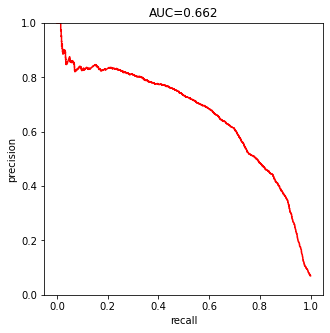

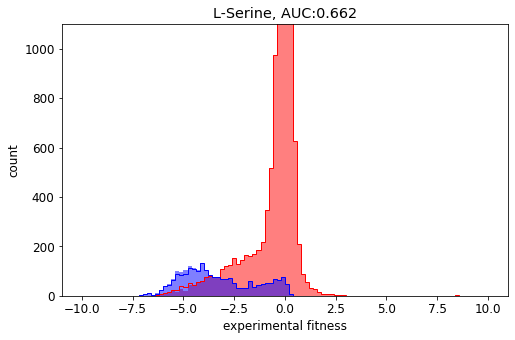

In [14]:
# Load data and visualize results
# load data
model_name = 'iML1515'

# load fitness data
data_fitness_unique = np.load(model_name+'_fitness.npy')

# load simulated fitness data
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_L-serine.npy')
    
# plot precision recall curve
[fig,axs,AUC] = plot_precision_recall_curve(model_name,data_fitness_sim_unique,data_fitness_unique)

# plot histogram
ylim = [0,1100]
[fig,axs,_,_] = plot_histogram(model_name,data_fitness_sim_unique,data_fitness_unique,ylim)
axs.set_title('L-Serine, AUC:'+str(np.round(AUC,3)))

# add old data outline to plot
data_fitness_sim_unique_orig = np.load(model_name+'_fitness_sim.npy')
sim_thresh = 0.001
data_sim_b = (data_fitness_sim_unique_orig > sim_thresh).astype(int)
# plot histogram
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==1],bins=100,range=(-10,10),histtype=u'step',edgecolor='r',lw=1)
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==0],bins=100,range=(-10,10),histtype=u'step',edgecolor='b',lw=1);

# save image
image_format = 'svg'
image_name = 'plots/'+model_name+'_serine_hist.svg'
fig.savefig(image_name, format=image_format, dpi=900)

## Part 8: iML1515 Isoenzymes (False Positives)

### Part 8a: Explore Data (Isoenzymes)

In [695]:
# load data
model_name = 'iML1515'
model = cobra.io.read_sbml_model(base_directory+'Models/'+model_name+'.xml')
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_L-serine.npy') #load the L-serine corrected data because we allready addressed those genes
data_fitness_unique = np.load(model_name+'_fitness.npy')
name_carbon_unique = np.load(model_name+'_names_carbon_model.npy')
name_genes_data = np.load(model_name+'_names_genes.npy')

In [698]:
# find top FP genes
# genes with the lowest average fitness that grew across all carbon sources
fitness_thresh = -3.5
sim_thresh = 0.001
data_fitness_sim_unique_b = data_fitness_sim_unique >= sim_thresh
FP_genes = []
FP_genes_m_fitness = []
# Visualize the data
g_mean_data_f = np.mean(data_fitness_unique,1)
g_sortinds = np.argsort(g_mean_data_f)
for i in range(len(g_sortinds)):
    if g_mean_data_f[g_sortinds[i]] <= fitness_thresh:
        if np.sum(data_fitness_sim_unique_b[g_sortinds[i],:])==data_fitness_sim_unique_b.shape[1]:
            FP_genes.append(name_genes_data[g_sortinds[i]])
            FP_genes_m_fitness.append(g_mean_data_f[g_sortinds[i]])
FP_genes_model = []
for i in range(len(FP_genes)):
    FP_genes_model.append(model.genes.get_by_id(FP_genes[i]).name)

In [699]:
# Print top FP genes and check for isoenzyme reactions
# Evaluate gene names as true
for gene in model.genes:
    exec(gene.id+'=True')
for i in range(len(FP_genes)):
    print_text = FP_genes[i]+' | '+FP_genes_model[i] + ' | ' + str(np.round(FP_genes_m_fitness[i],3))
    gene = FP_genes[i]
    # eval gene off
    exec(gene+'=False')
    for reaction in model.genes.get_by_id(FP_genes[i]).reactions:
        #if 'or' in reaction._gene_reaction_rule:
        if eval(reaction._gene_reaction_rule) == True:
            print_text = print_text+' | isoenzyme '+reaction.id + ' | ' + reaction._gene_reaction_rule 
    print(print_text)

b0073 | leuB | -5.166 | isoenzyme IPMD | b0073 or b1800
b3281 | aroE | -5.082 | isoenzyme SHK3Dr | b3281 or b1692
b1192 | ldcA | -4.928
b2414 | cysK | -4.665 | isoenzyme CYSS | b2421 or b2414
b3829 | metE | -4.409 | isoenzyme METS | b4019 or b3829
b0033 | carB | -4.262
b0049 | apaH | -4.199
b3772 | ilvA | -3.96 | isoenzyme THRD_L | b3772 or b3117
b0002 | thrA | -3.936 | isoenzyme HSDy | b3940 or b0002 | isoenzyme ASPK | b0002 or b3940 or b4024
b3390 | aroK | -3.813 | isoenzyme SHKK | b3390 or b0388
b3008 | metC | -3.781 | isoenzyme CYSDS | b3008 or b3708 | isoenzyme CYSTL | b3008 or b1622
b0032 | carA | -3.732
b2320 | pdxB | -3.633


### Part 8b: Individual Isoenzymes (Run FBA)

In [700]:
# adjust isoenzymes and re-run FBA
# change the gene-reaction-rule to rely on the gene of interest only with no alternative isoenzymes
# b0073 | leuB | -5.166 | isoenzyme IPMD | b0073 or b1800
# b3281 | aroE | -5.082 | isoenzyme SHK3Dr | b3281 or b1692
# b2414 | cysK | -4.665 | isoenzyme CYSS | b2421 or b2414
# b3829 | metE | -4.409 | isoenzyme METS | b4019 or b3829
# b3772 | ilvA | -3.96 | isoenzyme THRD_L | b3772 or b3117
# b0002 | thrA | -3.936 | isoenzyme ASPK | b0002 or b3940 or b4024 | isoenzyme HSDy | b3940 or b0002
# b3390 | aroK | -3.813 | isoenzyme SHKK | b3390 or b0388
# b3008 | metC | -3.781 | isoenzyme CYSDS | b3008 or b3708 | isoenzyme CYSTL | b3008 or b1622

In [701]:
iso_genes = ['b0073','b3281','b2414','b3829','b3772','b0002','b0002','b3390','b3008','b3008']
iso_reactions = ['IPMD','SHK3Dr','CYSS','METS','THRD_L','ASPK','HSDy','SHKK','CYSDS','CYSTL']

# Re run FBA (each isoenzyme individually)

model_names = ['iML1515']

# Load environment
[name_medium_model, name_carbon_model, name_carbon_experiment] = load_environment(base_directory)

# Load Data
[data_experiments,data_genes,data_fitness] = load_data(base_directory)

model_name = 'iML1515'
print(model_name)

# load model
print('loading model')
model = load_model(model_name,base_directory)
# optional printout check
print(str(len(model.genes))+' total genes in model')

# match model to data
print('matching model and data')
[name_genes_matched,name_carbon_experiment_matched,name_carbon_model_matched,data_fitness_matched] = match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness)
# optional printout checks
print(str(len(name_genes_matched))+' genes matched')
print(str(len(name_carbon_model_matched))+' carbon matched')

# adjust model
print('adjusting model')
adj_strain = 1
adj_essential = 1
adj_carbon = 1
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# optional printout checks
print(str(len(name_genes_matched_adj)),' adjusted genes matched')
print(str(len(name_carbon_model_matched_adj)),' adjusted carbon matched')
print(str(data_fitness_matched_adj.shape),' data shape')

# get medium and carbon exchange indicies
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
print(f'\n')

for i in range(len(iso_genes)):
    print(iso_genes[i],iso_reactions[i])
    
    # Reset model exchanges
    # turn off all exchange reactions (these should be off but just to make sure)
    for ex in model_adj.exchanges:
        ex.lower_bound = 0
        ex.upper_bound = 1000
    
    # adjust isoenzyme reaction
    tmp_gpr = model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule
    model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule = iso_genes[i]
    
    # simulate phenotype
    print('simulating phenotype')
    data_fitness_simulated_matched_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)

    # save data
    np.save(model_name+'_fitness_sim_'+'isoenzymes_'+iso_genes[i]+'_'+iso_reactions[i]+'.npy',np.asarray(data_fitness_simulated_matched_adj,dtype=np.double))
    
    # reset isoenzyme reaction
    model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule = tmp_gpr

    print(f'\n')

iML1515
loading model
1516 total genes in model
matching model and data
1339 genes matched
27 carbon matched
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmpxdqivwit.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
removing genes (strain):
b0061
b0344
b3902
removing genes (essential):
b0142
b0641
b0908
b2329
b2687
b3040
b3196
b3198
b3199
b3368
removing carbon sources:
man
sucr
1326  adjusted genes matched
25  adjusted carbon matched
(1326, 25)  data shape
checking environment
medium components not found in model:
carbon components not found in model:


b0073 IPMD
simulating phenotype
0.96

b3281 SHK3Dr
simulating phenotype
0.96

b2414 CYSS
simulating phenotype
0.96

b3829 METS
simulating phenotype
0.96

b3772 THRD_L
simulating phenotype
0.96

b0002 ASPK
simulating phenotype
0.96

b0002 HSDy
simulating phenotype
0.96

b3390 SHKK
simulating phenotype
0.96

b3008 CYSDS
simulating phenotype
0.96

b3008 CYSTL
simulat

### Part 8c: Individual Isoenzymes (Plot Results)

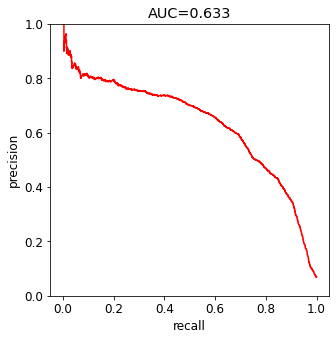

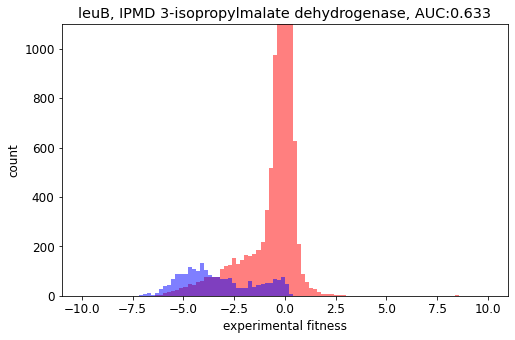

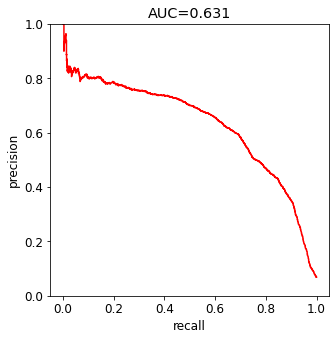

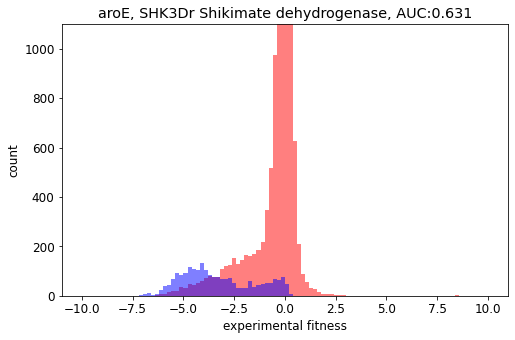

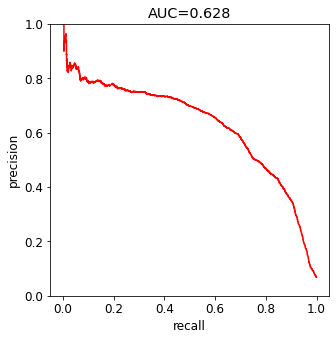

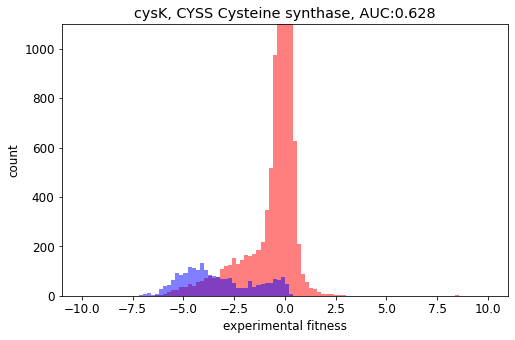

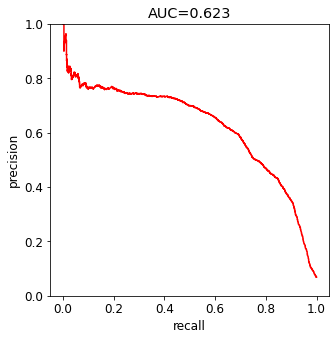

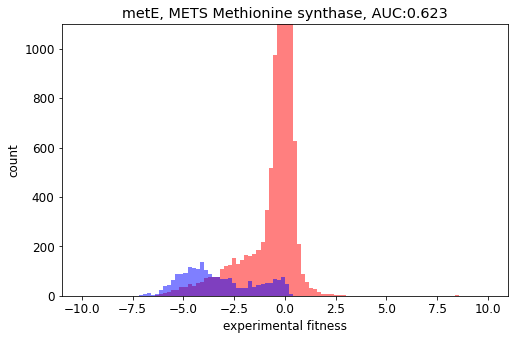

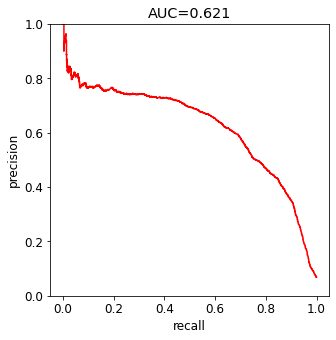

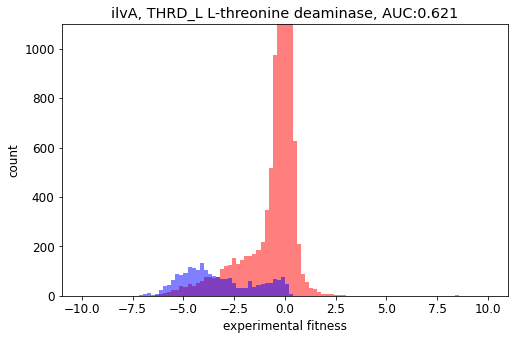

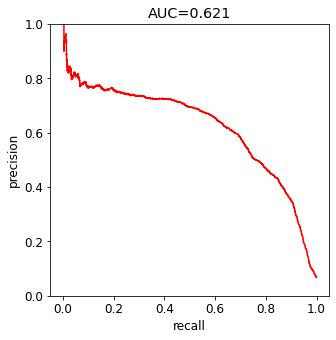

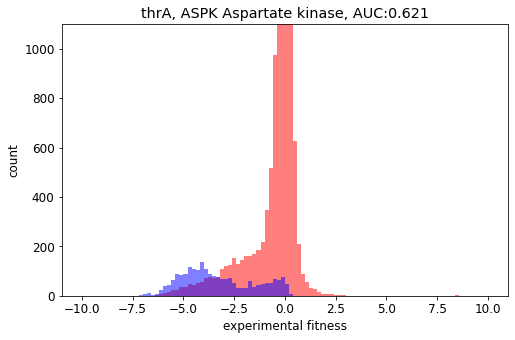

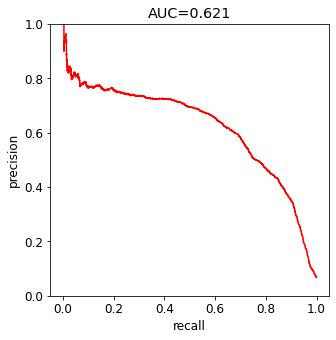

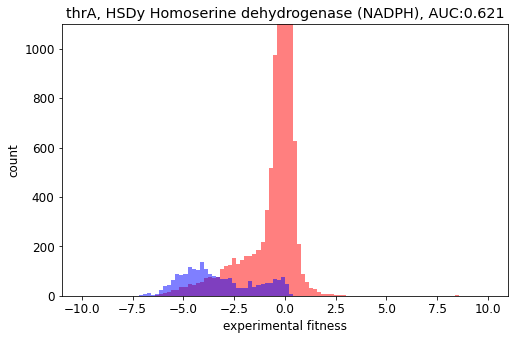

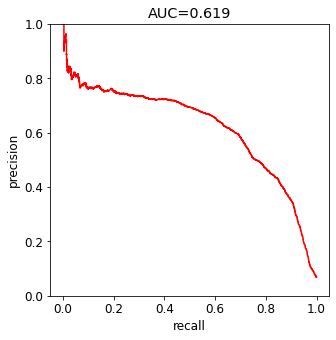

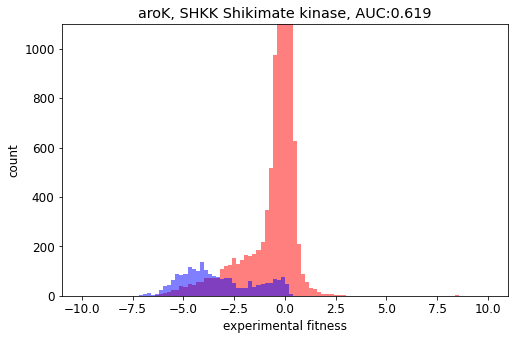

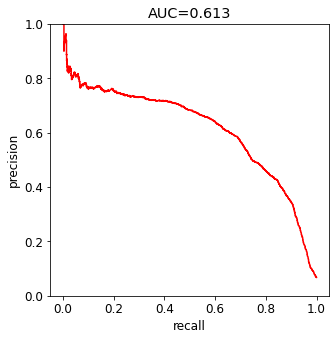

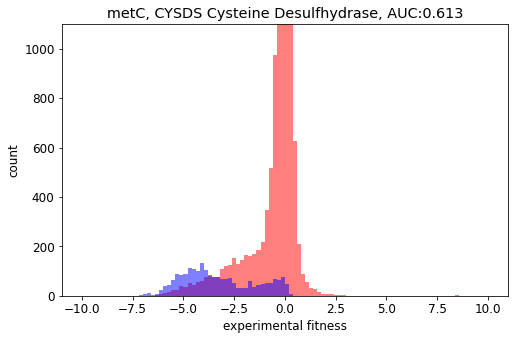

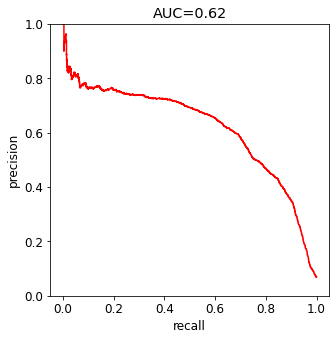

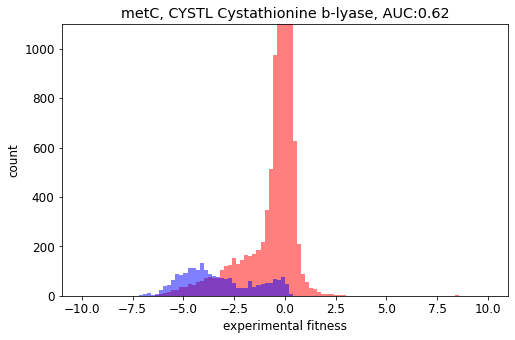

In [256]:
# Load data and visualize results
# load data
iso_genes = ['b0073','b3281','b2414','b3829','b3772','b0002','b0002','b3390','b3008','b3008']
iso_reactions = ['IPMD','SHK3Dr','CYSS','METS','THRD_L','ASPK','HSDy','SHKK','CYSDS','CYSTL']
model_name = 'iML1515'
model = cobra.io.read_sbml_model(base_directory+'Models/'+model_name+'.xml')

# load fitness
data_fitness_unique = np.load(model_name+'_fitness.npy')

for v in range(len(iso_genes)):
    data_fitness_sim_unique = np.load(model_name+'_fitness_sim_isoenzymes_'+iso_genes[v]+'_'+iso_reactions[v]+'.npy')

    # plot precision recall curve
    [fig,axs,AUC] = plot_precision_recall_curve(model_name,data_fitness_sim_unique,data_fitness_unique)
    
    # plot histogram
    ylim = [0,1100]
    [fig,axs,_,_] = plot_histogram(model_name,data_fitness_sim_unique,data_fitness_unique,ylim)
    axs.set_title(model.genes.get_by_id(iso_genes[v]).name+', '+model.reactions.get_by_id(iso_reactions[v]).id+' '+model.reactions.get_by_id(iso_reactions[v]).name+', AUC:'+str(np.round(AUC,3)))
    image_format = 'svg'
    image_name = 'plots/'+model_name+'_iso_hist_'+iso_genes[v]+'_'+iso_reactions[v]+'.svg'
    fig.savefig(image_name, format=image_format, dpi=1200)

### Part 8d: All Isoenzymes (Run FBA)

In [731]:
# List of all isoenzymes and associated reactions that had an impact on the prediction AUC (b3008, CYSDS was not included because it did not have an individual fitness effect)
iso_genes = ['b0073','b3281','b2414','b3829','b3772','b0002','b0002','b3390','b3008']
iso_reactions = ['IPMD','SHK3Dr','CYSS','METS','THRD_L','ASPK','HSDy','SHKK','CYSTL']

# Re run FBA (all isoenzymes)
model_names = ['iML1515']

# Load environment
[name_medium_model, name_carbon_model, name_carbon_experiment] = load_environment(base_directory)

# Load Data
[data_experiments,data_genes,data_fitness] = load_data(base_directory)

model_name = 'iML1515'
print(model_name)

# load model
print('loading model')
model = load_model(model_name,base_directory)
# optional printout check
print(str(len(model.genes))+' total genes in model')

# match model to data
print('matching model and data')
[name_genes_matched,name_carbon_experiment_matched,name_carbon_model_matched,data_fitness_matched] = match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness)
# optional printout checks
print(str(len(name_genes_matched))+' genes matched')
print(str(len(name_carbon_model_matched))+' carbon matched')

# adjust model
print('adjusting model')
adj_strain = 1
adj_essential = 1
adj_carbon = 1
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# optional printout checks
print(str(len(name_genes_matched_adj)),' adjusted genes matched')
print(str(len(name_carbon_model_matched_adj)),' adjusted carbon matched')
print(str(data_fitness_matched_adj.shape),' data shape')

# get medium and carbon exchange indicies
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
print(f'\n')

# Reset model exchanges
# turn off all exchange reactions (these should be off but just to make sure)
for ex in model_adj.exchanges:
    ex.lower_bound = 0
    ex.upper_bound = 1000

for i in range(len(iso_genes)):
    print(iso_genes[i],iso_reactions[i])
    
    # adjust isoenzyme reaction
    tmp_gpr = model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule
    model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule = iso_genes[i]
    
# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_matched_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)

# save data
np.save(model_name+'_fitness_sim_isoenzymes_all.npy',np.asarray(data_fitness_simulated_matched_adj,dtype=np.double))

print(f'\n')

iML1515
loading model
1516 total genes in model
matching model and data
1339 genes matched
27 carbon matched
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmplvvuoet4.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
removing genes (strain):
b0061
b0344
b3902
removing genes (essential):
b0142
b0641
b0908
b2329
b2687
b3040
b3196
b3198
b3199
b3368
removing carbon sources:
man
sucr
1326  adjusted genes matched
25  adjusted carbon matched
(1326, 25)  data shape
checking environment
medium components not found in model:
carbon components not found in model:


b0073 IPMD
b3281 SHK3Dr
b2414 CYSS
b3829 METS
b3772 THRD_L
b0002 ASPK
b0002 HSDy
b3390 SHKK
b3008 CYSTL
simulating phenotype
0.96



### Part 8e: All Isoenzymes (Plot Results)

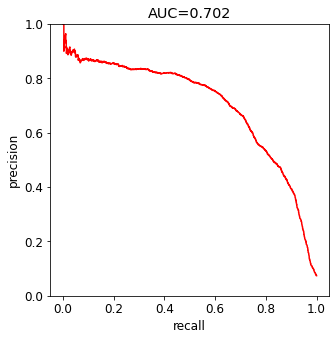

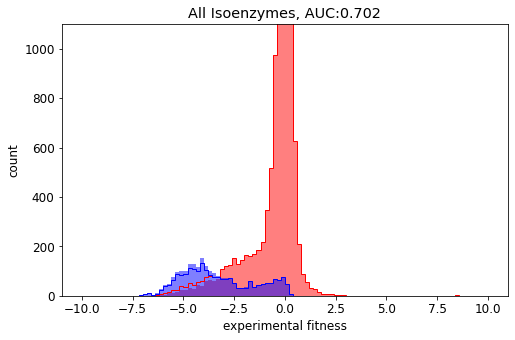

In [191]:
# Load data and visualize results
# List of all isoenzymes and associated reactions that had an impact on the prediction AUC (b3008, CYSDS was not included)
iso_genes = ['b0073','b3281','b2414','b3829','b3772','b0002','b0002','b3390','b3008']
iso_reactions = ['IPMD','SHK3Dr','CYSS','METS','THRD_L','ASPK','HSDy','SHKK','CYSTL']

model_name = 'iML1515'

data_fitness_unique = np.load(model_name+'_fitness.npy')
    
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_isoenzymes_all.npy')

# plot precision recall curve
[fig,axs,AUC] = plot_precision_recall_curve(model_name,data_fitness_sim_unique,data_fitness_unique)
# plot histogram
ylim = [0,1100]
[fig,axs,_,_] = plot_histogram(model_name,data_fitness_sim_unique,data_fitness_unique,ylim)
axs.set_title('All Isoenzymes'+', AUC:'+str(np.round(AUC,3)))

# add old data outline to plot
data_fitness_sim_unique_orig = np.load(model_name+'_fitness_sim.npy')
sim_thresh = 0.001
data_sim_b = (data_fitness_sim_unique_orig > sim_thresh).astype(int)
# plot histogram
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==1],bins=100,range=(-10,10),histtype=u'step',edgecolor='r',lw=1)
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==0],bins=100,range=(-10,10),histtype=u'step',edgecolor='b',lw=1)
axs.set_ylim(ylim)

image_format = 'svg'
image_name = 'plots/'+model_name+'_iso_hist_all.svg'
fig.savefig(image_name, format=image_format, dpi=900)



## Part 9: iML1515 All Corrections (vitamins, L-serine, isoenzymes)

Add all vitamins and correct all isoenzymes and re-run FBA

### Part 9a: All Corrections (Run FBA)

In [764]:
# Re run FBA (each vitamin individually)
vitamins = ['btn','pnto__R','thm','thf','nad']

# List of all isoenzymes and associated reactions that had an impact on the prediction AUC (b3008, CYSDS was not included)
iso_genes = ['b0073','b3281','b2414','b3829','b3772','b0002','b0002','b3390','b3008']
iso_reactions = ['IPMD','SHK3Dr','CYSS','METS','THRD_L','ASPK','HSDy','SHKK','CYSTL']

# Load environment
[name_medium_model, name_carbon_model, name_carbon_experiment] = load_environment(base_directory)

# Load Data
[data_experiments,data_genes,data_fitness] = load_data(base_directory)

model_name = 'iML1515'
print(model_name)

# load model
print('loading model')
model = load_model(model_name,base_directory)
# optional printout check
print(str(len(model.genes))+' total genes in model')

# match model to data
print('matching model and data')
[name_genes_matched,name_carbon_experiment_matched,name_carbon_model_matched,data_fitness_matched] = match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness)
# optional printout checks
print(str(len(name_genes_matched))+' genes matched')
print(str(len(name_carbon_model_matched))+' carbon matched')

# adjust model
print('adjusting model')
adj_strain = 1
adj_essential = 1
adj_carbon = 1
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# optional printout checks
print(str(len(name_genes_matched_adj)),' adjusted genes matched')
print(str(len(name_carbon_model_matched_adj)),' adjusted carbon matched')
print(str(data_fitness_matched_adj.shape),' data shape')

# get medium and carbon exchange indicies
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
print(f'\n')

# Reset model exchanges
# turn off all exchange reactions (these should be off but just to make sure)
for ex in model_adj.exchanges:
    ex.lower_bound = 0
    ex.upper_bound = 1000
    
# Add vitamins
for i in range(3):
    # add vitamin
    #turn on exchange
    model_adj.exchanges.get_by_id('EX_'+vitamins[i]+'_e').lower_bound = -1000
for i in range(3,5):
    # add vitamin
    # add exchange directly to intracellular metabolite
    rxn = cobra.Reaction('EX_'+vitamins[i]+'_c')
    rxn.name = 'EX_'+vitamins[i]+'_c'
    rxn.lower_bound = -1000
    rxn.upper_bound = 1000
    rxn.add_metabolites({model_adj.metabolites.get_by_id(vitamins[i]+'_c'): -1.0})
    model_adj.add_reactions([rxn])    

# Adjust L-serine reaction reversibility
model_adj.reactions.get_by_id('GHMT2r').lower_bound = 0
    
# Adjust isoenzymes
for i in range(len(iso_genes)):
    # adjust isoenzyme reaction
    tmp_gpr = model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule
    model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule = iso_genes[i]

# save adjusted model (for reference to flux data)
cobra.io.write_sbml_model(model_adj,model_name+'model_adjusted_all_corrections.xml')

# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_matched_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)

# save data
np.save(model_name+'_fitness_sim_all_corrections.npy',np.asarray(data_fitness_simulated_matched_adj,dtype=np.double))

iML1515
loading model
1516 total genes in model
matching model and data
1339 genes matched
27 carbon matched
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmpt6dk2896.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
removing genes (strain):
b0061
b0344
b3902
removing genes (essential):
b0142
b0641
b0908
b2329
b2687
b3040
b3196
b3198
b3199
b3368
removing carbon sources:
man
sucr
1326  adjusted genes matched
25  adjusted carbon matched
(1326, 25)  data shape
checking environment
medium components not found in model:
carbon components not found in model:


simulating phenotype


### Part 9b: All Corrections (Plot Results)

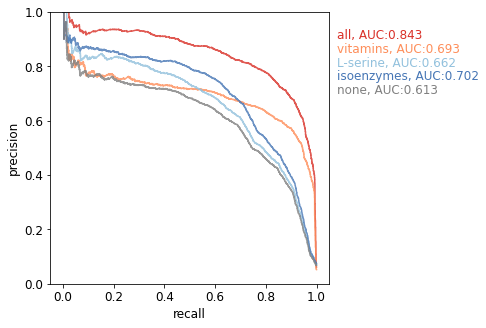

In [84]:
# Load Data# Load data and visualize results

# Precision recall curves
fig, axs = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(5)

# Load fitness data
data_fitness_unique = np.load(model_name+'_fitness.npy')
data_fit_V = data_fitness_unique.flatten()
sim_thresh = 0.001

model_name = 'iML1515'

p1 = -0.02
p2 = 0
alph = 0.8

# All corrections
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_all_corrections.npy')
# Precision Recall Curve
data_sim_b = (data_fitness_sim_unique > sim_thresh).astype(int)
data_sim_b_V = data_sim_b.flatten()
pre, rec, thresholds = pre_rec(data_sim_b_V*-1,data_fit_V*-1,pos_label=0)
c = np.array([215,48,39])/253
axs.plot(rec,pre,color=c,alpha=alph)
AUC = sk_auc(rec,pre)
AUC1 = AUC
axs.text(1.1+p1,0.9+p2,'all, AUC:'+str(np.round(AUC,3)),color=c)

# Vitamins
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_vitamins_all.npy')
# Precision Recall Curve
data_sim_b = (data_fitness_sim_unique > sim_thresh).astype(int)
data_sim_b_V = data_sim_b.flatten()
pre, rec, thresholds = pre_rec(data_sim_b_V*-1,data_fit_V*-1,pos_label=0)
c = np.array([252,141,89])/253
axs.plot(rec,pre,color=c,alpha=alph)
AUC = sk_auc(rec,pre)
axs.text(1.1+p1,0.85+p2,'vitamins, AUC:'+str(np.round(AUC,3)),color=c)

# L-serine
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_L-serine.npy')
# Precision Recall Curve
data_sim_b = (data_fitness_sim_unique > sim_thresh).astype(int)
data_sim_b_V = data_sim_b.flatten()
pre, rec, thresholds = pre_rec(data_sim_b_V*-1,data_fit_V*-1,pos_label=0)
c = np.array([145,191,219])/253
axs.plot(rec,pre,color=c,alpha=alph)
AUC = sk_auc(rec,pre)
axs.text(1.1+p1,0.8+p2,'L-serine, AUC:'+str(np.round(AUC,3)),color=c)

# Isoenzymes
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_isoenzymes_all.npy')
# Precision Recall Curve
data_sim_b = (data_fitness_sim_unique > sim_thresh).astype(int)
data_sim_b_V = data_sim_b.flatten()
pre, rec, thresholds = pre_rec(data_sim_b_V*-1,data_fit_V*-1,pos_label=0)
c = np.array([69,117,180])/253
axs.plot(rec,pre,color=c,alpha=alph)
AUC = sk_auc(rec,pre)
axs.text(1.1+p1,0.75+p2,'isoenzymes, AUC:'+str(np.round(AUC,3)),color=c)

# No corrections
data_fitness_sim_unique = np.load(model_name+'_fitness_sim.npy')
# Precision Recall Curve
data_sim_b = (data_fitness_sim_unique > sim_thresh).astype(int)
data_sim_b_V = data_sim_b.flatten()
pre, rec, thresholds = pre_rec(data_sim_b_V*-1,data_fit_V*-1,pos_label=0)
c = np.array([1,1,1])*0.5
axs.plot(rec,pre,color=c,alpha=alph)
AUC = sk_auc(rec,pre)
axs.text(1.1+p1,0.70+p2,'none, AUC:'+str(np.round(AUC,3)),color=c)

# Format plot
axs.set_ylim([0, 1])
axs.set_xlabel('recall')
axs.set_ylabel('precision')
plt.rcParams['font.size'] = 12

# Save plot
image_format = 'svg'
image_name = 'plots/'+model_name+'_all_corrections_prerec.svg'
fig.savefig(image_name, format=image_format, dpi=1200)



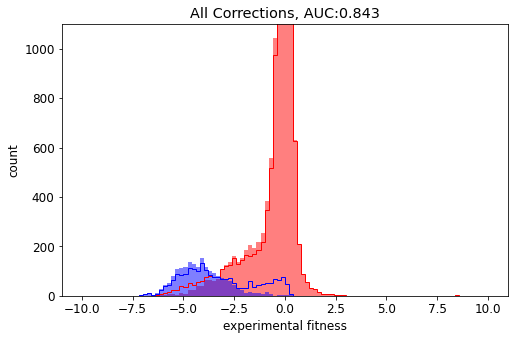

In [69]:
# plot histogram
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_all_corrections.npy')

ylim = [0,1100]

[fig,axs,_,_] = plot_histogram(model_name,data_fitness_sim_unique,data_fitness_unique,ylim)
axs.set_title('All Corrections, AUC:'+str(np.round(AUC1,3)))

# add old data outline to plot
data_fitness_sim_unique_orig = np.load(model_name+'_fitness_sim.npy')
sim_thresh = 0.001
data_sim_b = (data_fitness_sim_unique_orig > sim_thresh).astype(int)
# plot histogram
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==1],bins=100,range=(-10,10),histtype=u'step',edgecolor='r',lw=1)
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==0],bins=100,range=(-10,10),histtype=u'step',edgecolor='b',lw=1)
axs.set_ylim(ylim)

image_format = 'svg'
image_name = 'plots/'+model_name+'_all_corrections_hist.svg'
fig.savefig(image_name, format=image_format, dpi=900)


## Part 10: iML1515 Visualize Results (All Corrections)

In [15]:
# load data
model_name = 'iML1515'
model = cobra.io.read_sbml_model(model_name+'_model_adjusted_all_corrections.xml')
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_all_corrections.npy')
data_fitness_unique = np.load(model_name+'_fitness.npy')
name_carbon_unique = np.load(model_name+'_names_carbon_model.npy')
name_genes_data = np.load(model_name+'_names_genes.npy')

Academic license - for non-commercial use only - expires 2023-09-03
Using license file /Users/david/gurobi.lic


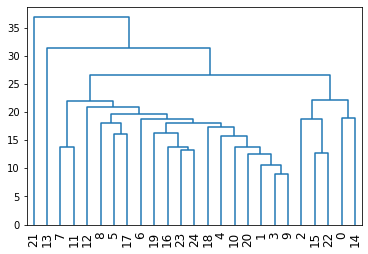

In [16]:
# Visualize the data
g_mean_data_f = np.mean(data_fitness_unique,1)
g_sortinds = np.argsort(g_mean_data_f)

#c_mean_data_f = np.mean(data_fitness_unique,0)
#c_mean_data_f_sortinds = np.argsort(c_mean_data_f)
Z = linkage(np.transpose(data_fitness_unique),'average')
D = dendrogram(Z,leaf_rotation=90,leaf_font_size=12,color_threshold=0)
D_inds = D['leaves']
c_sortinds = D_inds

data_fitness_sort = data_fitness_unique[g_sortinds,:][:,c_sortinds]
data_fitness_sim_sort = data_fitness_sim_unique[g_sortinds,:][:,c_sortinds]

name_genes_data_sort = name_genes_data[g_sortinds]
name_carbon_sort = np.array(name_carbon_unique)[c_sortinds]

name_genes_model_sort = []
for i in range(len(name_genes_data_sort)):
    name_genes_model_sort.append(model.genes.get_by_id(name_genes_data_sort[i]).name)

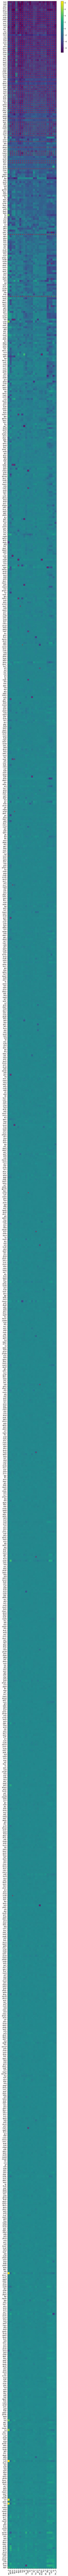

In [17]:
fig, ax = plt.subplots(figsize = [10,300])
vma = np.max(data_fitness_sort)
vmi = np.min(data_fitness_sort)
p=ax.imshow(data_fitness_sort,vmin=vmi,vmax=vma,cmap='viridis')
ax.set_yticks(range(len(name_genes_data_sort)));
ax.set_yticklabels(np.array(name_genes_model_sort));
ax.set_xticks(range(len(name_carbon_sort)));
ax.set_xticklabels(name_carbon_sort);
plt.xticks(rotation=90);
for i in range(data_fitness_sim_sort.shape[0]):
    for j in range(data_fitness_sim_sort.shape[1]):
        if data_fitness_sim_sort[i,j]<=0.001:
            ax.plot(j,i,'r.')
fig.colorbar(p,location='right',anchor=(0,1),shrink=0.02);

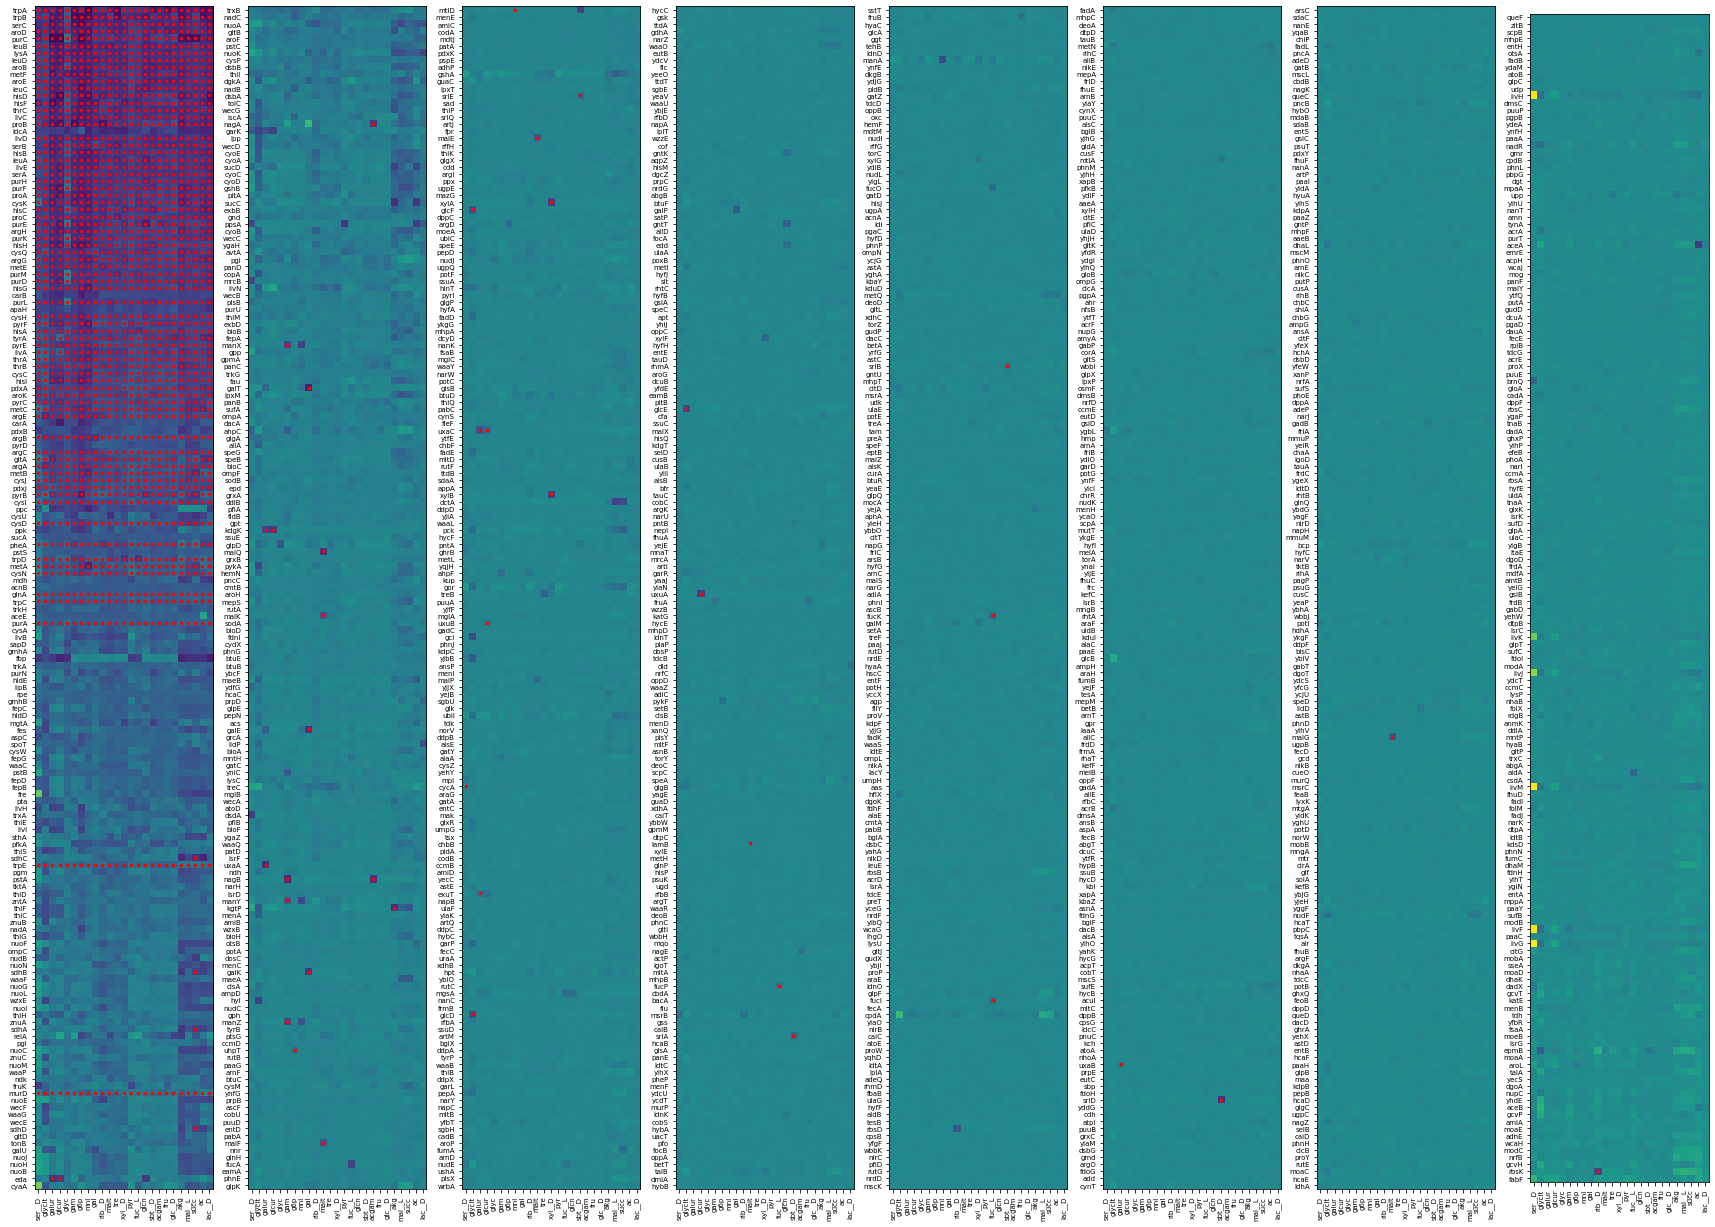

In [18]:
fig, axs = plt.subplots(1,8,figsize = [30,30])
for a in range(len(axs)):
    i1 = a
    i2 = a+1
    n = 166
    inds = np.arange(n*i1,n*i2)
    if n*i2 > data_fitness_sim_sort.shape[0]:
        inds = np.arange(n*i1,data_fitness_sim_sort.shape[0])
    p=axs[a].imshow(data_fitness_sort[inds,:],vmin=vmi,vmax=vma,cmap='viridis')
    axs[a].set_yticks(range(len(name_genes_data_sort[inds])));
    axs[a].set_yticklabels(np.array(name_genes_model_sort)[inds],fontsize=7);
    axs[a].set_xticks(range(len(name_carbon_sort)));
    axs[a].set_xticklabels(name_carbon_sort,rotation=90,fontsize=7);
    for i in inds:
        for j in range(data_fitness_sim_sort.shape[1]):
            if data_fitness_sim_sort[i,j]<=0.001:
                axs[a].plot(j,i-n*i1,'r.',markersize=5)
#fig.colorbar(p,location='right',anchor=(0,1),shrink=0.06);
# save figure
image_format = 'svg'
image_name = 'plots/'+model_name+'_all_corrections_results_matrix.svg'
fig.savefig(image_name, format=image_format, dpi=900)

In [19]:
# List False Positives (low fitness, simulated growth) to help understand ML results

fit_thresh = -2
sim_thresh = 0.001
count = 0
count_g = 0

import csv
with open('false_positives.tsv','w',newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
    writer.writerow(['gene_id','gene_name','carbon_id','fitness','fba growth'])
    for i in range(data_fitness_sort.shape[0]):
        for j in range(data_fitness_sort.shape[1]):
            tmp = 0
            if data_fitness_sort[i,j] < fit_thresh:
                if data_fitness_sim_sort[i,j] >= sim_thresh:
                    count = count + 1
                    tmp = 1
                    writer.writerow([name_genes_data_sort[i],name_genes_model_sort[i],name_carbon_sort[j],data_fitness_sort[i,j],data_fitness_sim_sort[i,j]])
                    print(name_genes_data_sort[i],name_genes_model_sort[i],name_carbon_sort[j],data_fitness_sort[i,j],data_fitness_sim_sort[i,j])
        count_g = count_g + tmp    
            

b0907 serC ser__D -5.086 0.3184406057757408
b1192 ldcA ser__D -4.3885000000000005 0.3184654040592426
b1192 ldcA glyclt -4.3735 0.1532860260610444
b1192 ldcA galur -4.857 0.7055851648110836
b1192 ldcA glcur -4.477 0.7055851648110881
b1192 ldcA glyc -5.2775 0.495339375930067
b1192 ldcA gam -4.343999999999999 0.8784204366462547
b1192 ldcA g6p -2.7795 0.9063561214037628
b1192 ldcA mnl -5.9765 0.9440205213956097
b1192 ldcA gal -4.789 0.8686917214119129
b1192 ldcA rib__D -5.734 0.6897858214506496
b1192 ldcA malt -5.443 1.7820534212141623
b1192 ldcA tre -5.7165 1.7820534212141579
b1192 ldcA xyl__D -5.9465 0.7180341214445365
b1192 ldcA pyr -4.526 0.3143558608810614
b1192 ldcA fuc__L -4.736 0.8632243728905069
b1192 ldcA glcn -3.8259999999999996 0.7981455601649246
b1192 ldcA sbt__D -5.3100000000000005 0.9440205213956075
b1192 ldcA acgam -4.7275 1.1327456467072514
b1192 ldcA fru -3.995 0.8781078214098783
b1192 ldcA glc__D -3.9905 0.8781078214098806
b1192 ldcA akg -5.5855 0.5480882528341482
b1192 

In [20]:
print(count)
print(count_g)

1249
63


## Part 11: Carbon Source Specific Predictions

In [61]:
# load data
model_name = 'iML1515'
model = cobra.io.read_sbml_model(model_name+'_model_adjusted_all_corrections.xml')
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_all_corrections.npy')
data_fitness_unique = np.load(model_name+'_fitness.npy')
name_carbon_unique = np.load(model_name+'_names_carbon_model.npy')
name_genes_data = np.load(model_name+'_names_genes.npy')

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


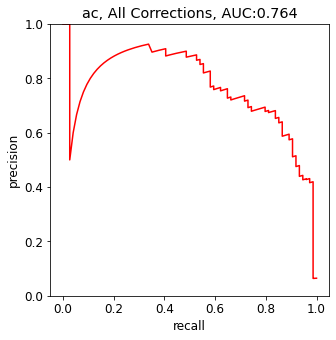

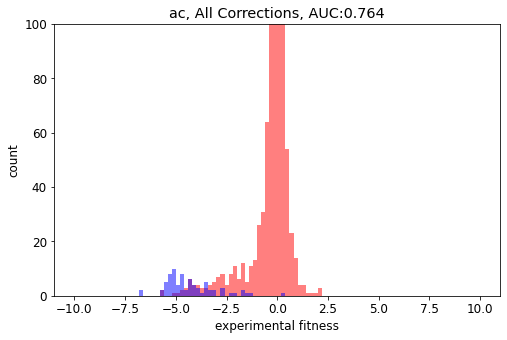

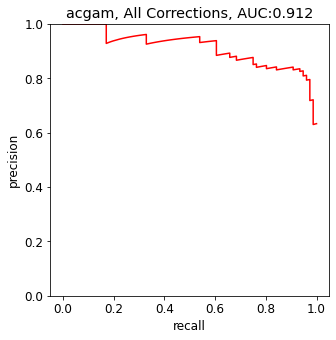

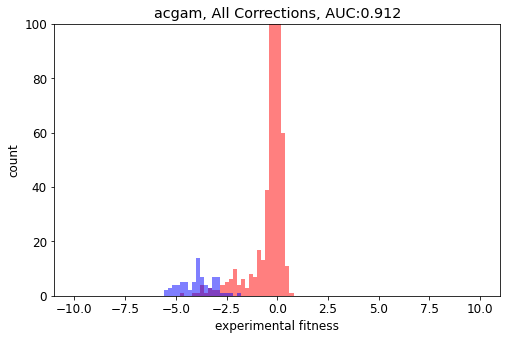

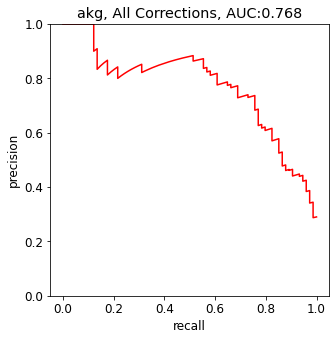

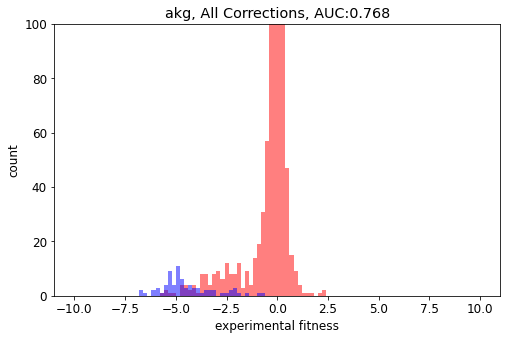

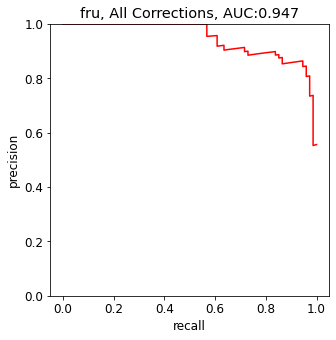

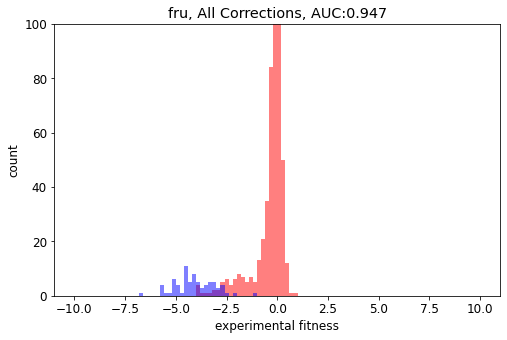

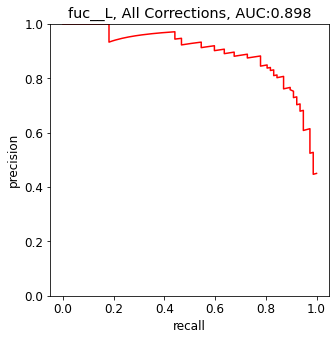

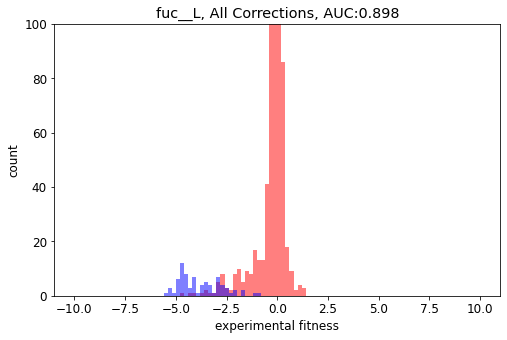

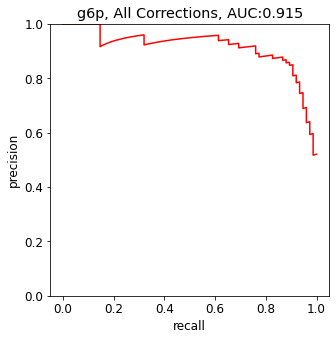

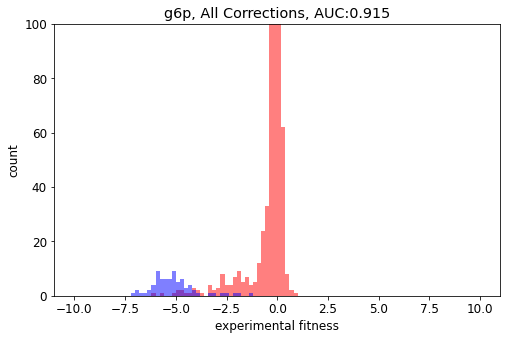

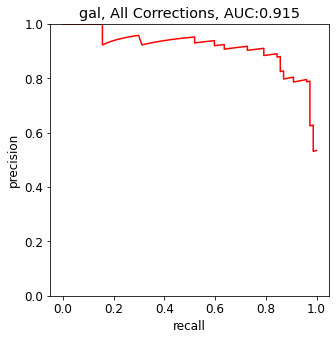

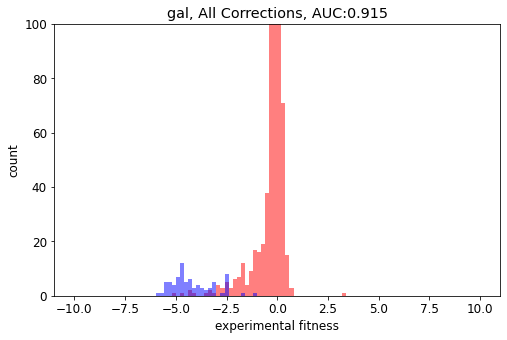

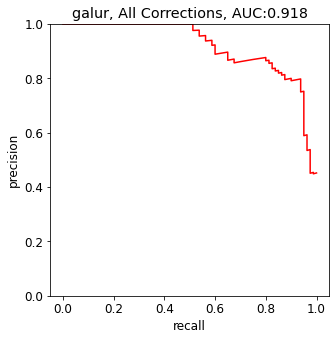

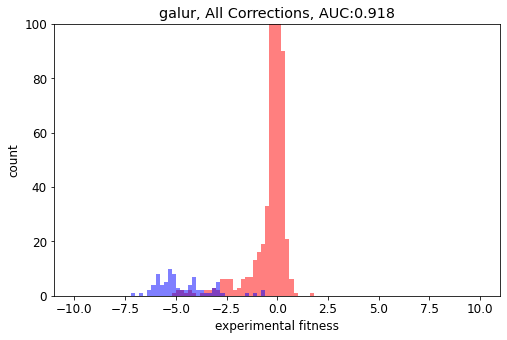

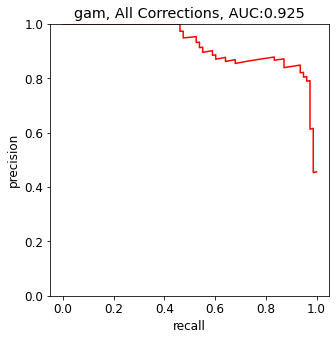

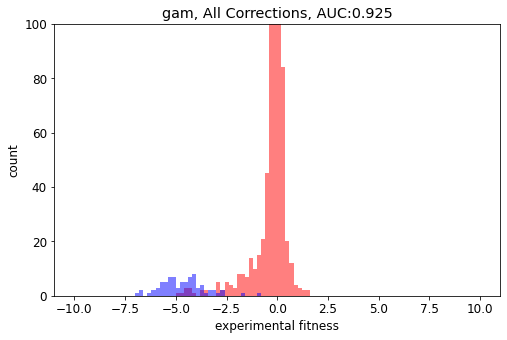

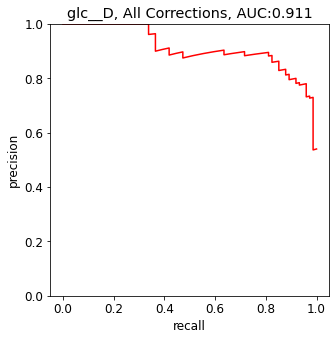

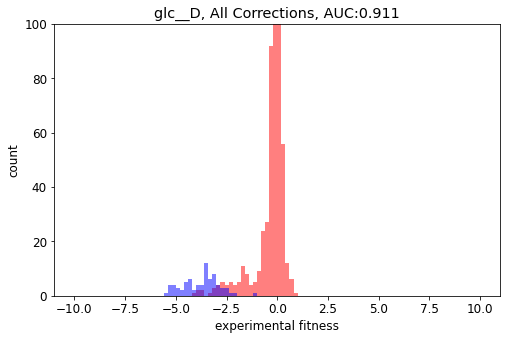

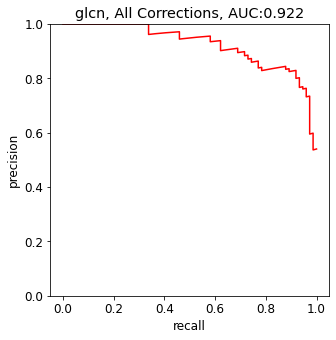

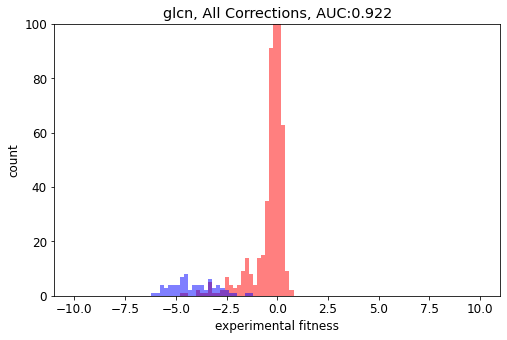

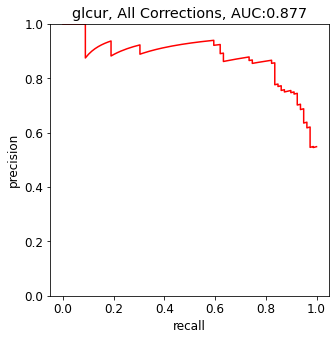

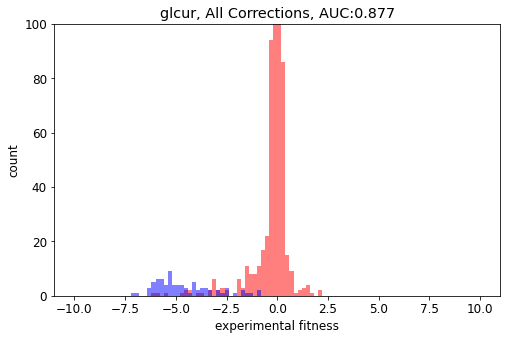

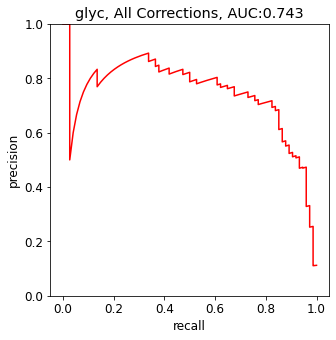

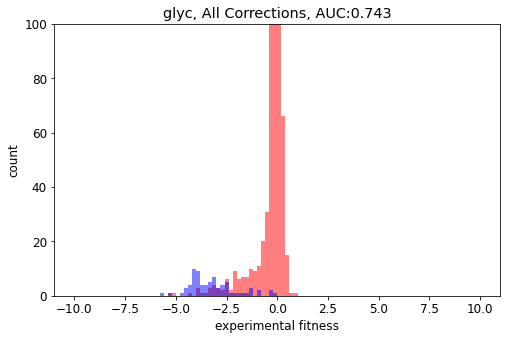

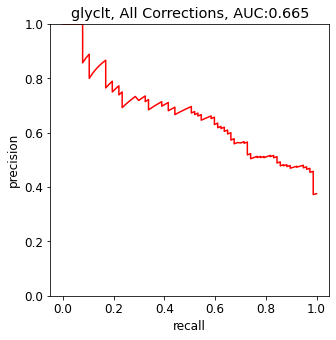

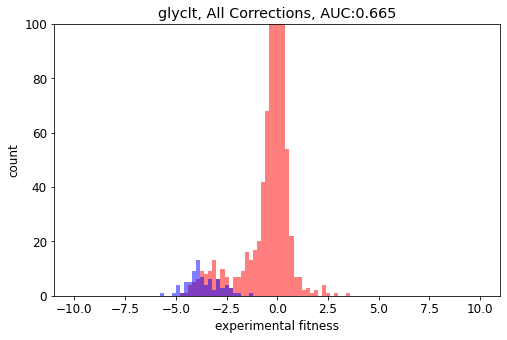

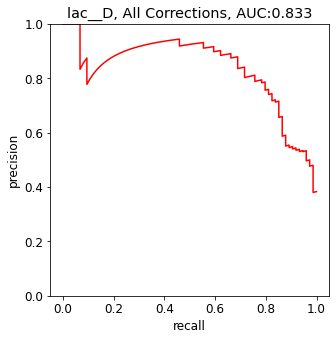

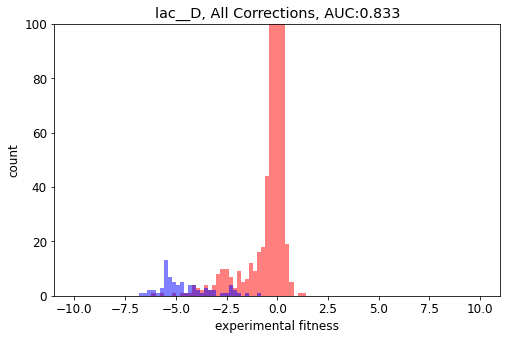

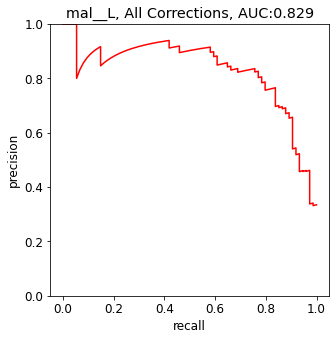

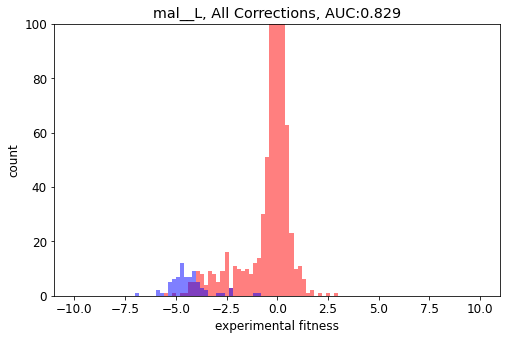

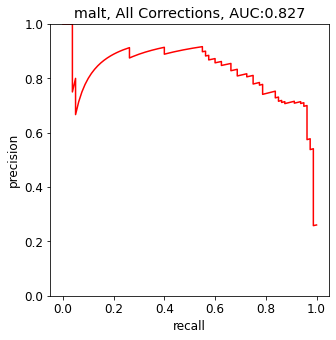

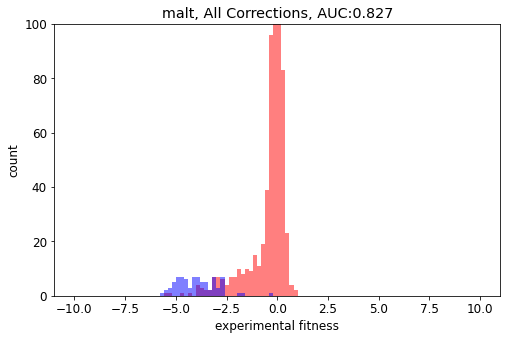

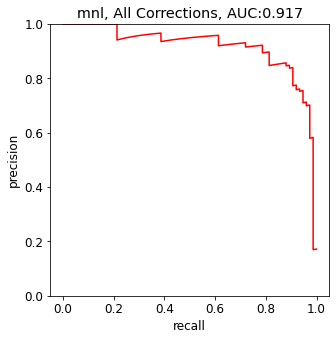

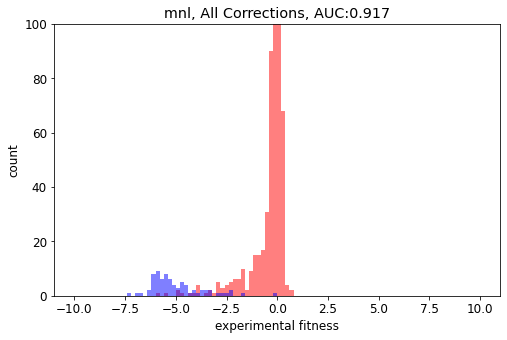

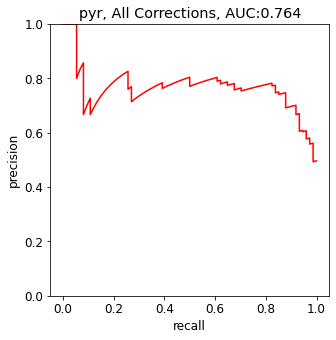

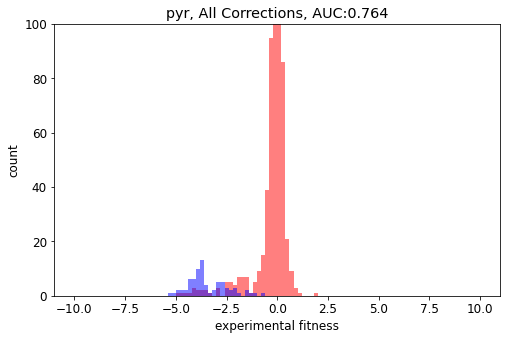

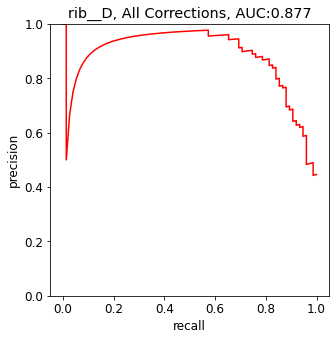

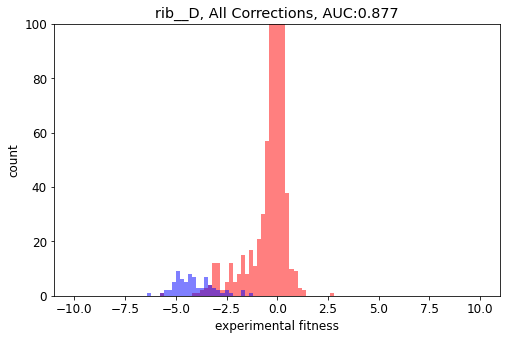

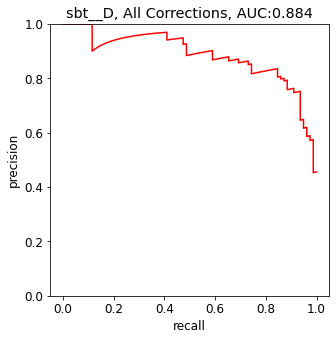

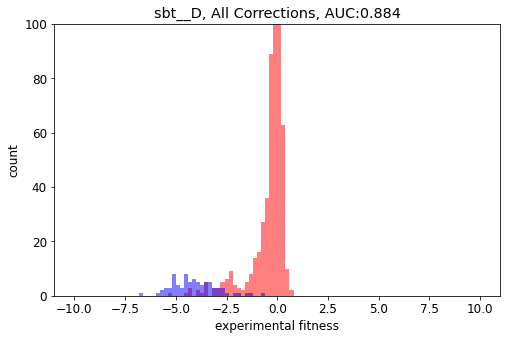

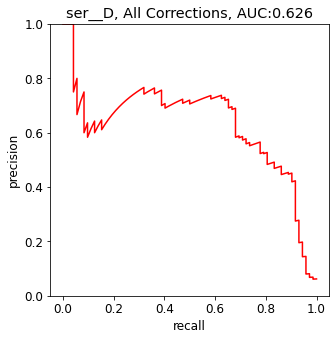

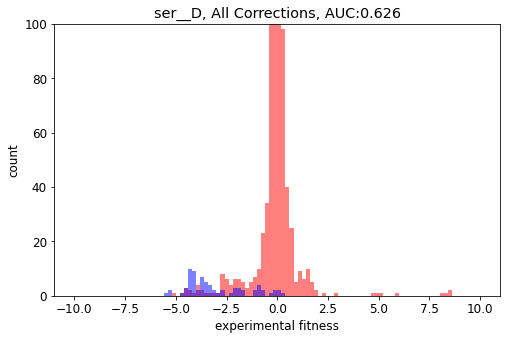

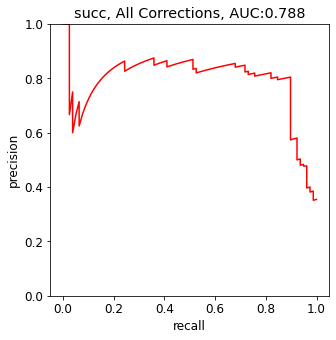

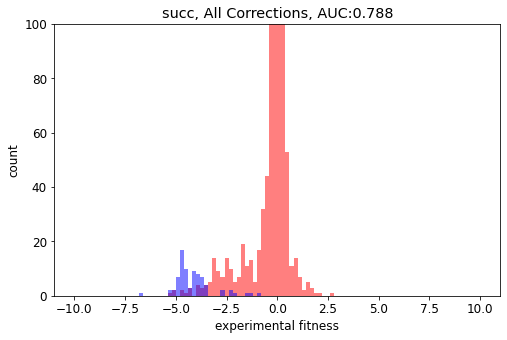

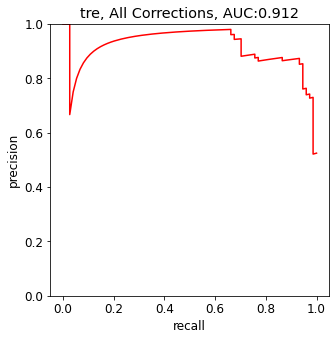

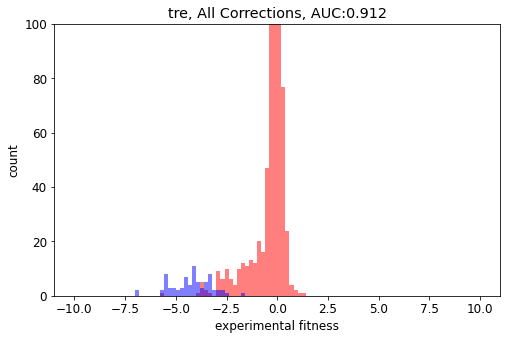

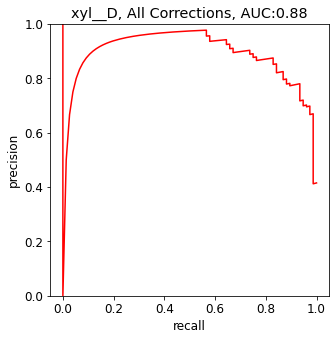

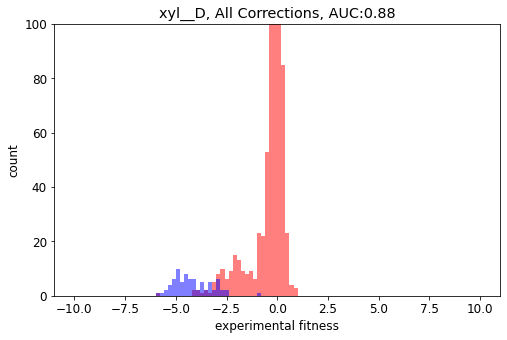

In [20]:
# calculate precision recall AUC for each carbon source individually
C_AUC = np.zeros(name_carbon_unique.shape)
ylim = [0,100]
for i in range(len(C_AUC)):
    [fig,axs,C_AUC[i]] = plot_precision_recall_curve(model_name,data_fitness_sim_unique[:,i],data_fitness_unique[:,i])
    axs.set_title(name_carbon_unique[i]+', All Corrections, AUC:'+str(np.round(C_AUC[i],3)))
    [fig,axs,_,_] = plot_histogram(model_name,data_fitness_sim_unique[:,i],data_fitness_unique[:,i],ylim)
    axs.set_title(name_carbon_unique[i]+', All Corrections, AUC:'+str(np.round(C_AUC[i],3)))

    

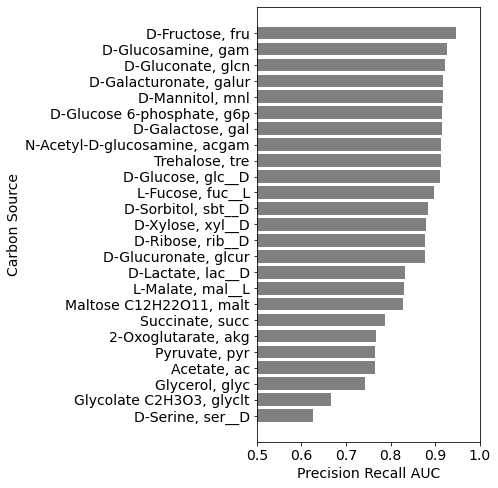

In [21]:
# Plot precision recall AUC for each carbon source
plt.rcParams['font.size'] = 14

tmp = []
for i in range(len(name_carbon_unique)):
    tmp.append(model.metabolites.get_by_id(name_carbon_unique[i]+'_e').name+', '+name_carbon_unique[i])
name_carbon_model = np.array(tmp)
sort_inds = np.argsort(C_AUC)
fig, axs = plt.subplots(1,1,figsize=[4,8])
axs.barh(np.arange(0,len(C_AUC)),C_AUC[sort_inds],color=[0.5,0.5,0.5])
axs.set_xlim([0.5,1])
axs.set_ylabel('Carbon Source')
axs.set_xlabel('Precision Recall AUC')
axs.set_yticks(np.arange(0,len(C_AUC)));
axs.set_yticklabels(name_carbon_model[sort_inds]);


fig = plt.gcf()
image_format = 'svg'
image_name = 'plots/'+model_name+'_carbon_accuracy.svg'
fig.savefig(image_name, format=image_format, dpi=900)

In [22]:
# Calculate Distance of Gene KOs from Carbon Source
# Get model S Matrix
S = cobra.util.array.create_stoichiometric_matrix(model)
# Convert to binary
S[S!=0]=1

# Conver to Adjacency Matrix
tmp1 = np.concatenate((np.zeros([S.shape[0],S.shape[0]]),S),axis=1)
tmp2 = np.concatenate((np.transpose(S),np.zeros([S.shape[1],S.shape[1]])),axis=1)
A = np.concatenate((tmp1,tmp2),axis=0)
met_list = []
for i in range(len(model.metabolites)):
    met_list.append(model.metabolites[i].id)
rxn_list = []
for i in range(len(model.reactions)):
    rxn_list.append(model.reactions[i].id)
A_list = met_list+rxn_list


In [23]:
# Calculate gene to reaction essentiality matrix
gene_list = []
for i in range(len(model.genes)):
    gene_list.append(model.genes[i].id)
    exec(model.genes[i].id+'=True')
E = np.zeros([len(model.reactions),len(model.genes)])
for i in range(len(model.reactions)):
    # get gene reaction mapping
    gpr = model.reactions[i]._gene_reaction_rule
    for g in model.reactions[i].genes:
        # set gene off
        exec(g.id+'=False')
        # test gpr
        if eval(model.reactions[i]._gene_reaction_rule) == False:
            E[i,gene_list.index(g.id)] = 1
        # set gene back on
        exec(g.id+'=True')

In [24]:
# Remove hub nodes
degree = np.sum(A,0)
sort_inds = np.argsort(degree*-1)
for i in range(30):
    print(A_list[sort_inds[i]],degree[sort_inds[i]])
hubs = ['h_c', #Hubs are all nodes with more than 50 edges unless they are a carbon source (pyruvate)
        'h2o_c',
        'atp_c',
        'pi_c',
        'h_p',
        'adp_c',
        'h2o_p',
        'nad_c',
        'ppi_c',
        'nadh_c',
        'nadph_c',
        'nadp_c',
        'BIOMASS_Ec_iML1515_WT_75p37M',
        'co2_c',
        'coa_c',
        'amp_c',
        #'pyr_c',
        'BIOMASS_Ec_iML1515_core_75p37M',
        'ACP_c',
        'pi_p',
        'nh4_c',
        'glu__L_c'
       ]

hub_index = []
for i in range(len(hubs)):
    hub_index.append(A_list.index(hubs[i]))
A_no_hubs = np.delete(A, hub_index, axis=0)
A_no_hubs = np.delete(A_no_hubs, hub_index, axis=1)

A_list_no_hubs = A_list.copy()
for hub in hubs:
    A_list_no_hubs.remove(hub)
    

h_c 1079.0
h2o_c 616.0
atp_c 349.0
pi_c 324.0
h_p 312.0
adp_c 287.0
h2o_p 170.0
nad_c 132.0
ppi_c 128.0
nadh_c 127.0
nadph_c 113.0
nadp_c 113.0
BIOMASS_Ec_iML1515_WT_75p37M 99.0
co2_c 80.0
coa_c 80.0
amp_c 74.0
pyr_c 70.0
BIOMASS_Ec_iML1515_core_75p37M 70.0
ACP_c 61.0
pi_p 54.0
nh4_c 54.0
glu__L_c 51.0
glyc3p_c 41.0
accoa_c 41.0
o2_c 41.0
fe2_c 36.0
pep_c 34.0
cmp_c 33.0
fad_c 29.0
akg_c 28.0


In [25]:
dist_matrix = shortest_path(A_no_hubs,method='D')

In [26]:
# Calculate distance from carbon source to gene for each data point
dist_c = np.zeros(data_fitness_unique.shape)
for i in range(data_fitness_unique.shape[1]):
    c_ind = A_list_no_hubs.index(name_carbon_unique[i]+'_e')
    for j in range(data_fitness_unique.shape[0]):
        g_ind = gene_list.index(name_genes_data[j])
        g_r_tmp = np.where(E[:,g_ind]==1)[0]
        d = []
        if len(g_r_tmp) > 0:
            for di in range(len(g_r_tmp)):
                g_r_ind = A_list_no_hubs.index(rxn_list[g_r_tmp[di]])
                d.append(dist_matrix[g_r_ind,c_ind])
            dist_c[j,i]=np.min(np.array(d))
        else:
            dist_c[j,i]=50
dist_c = (dist_c-1)/2

In [27]:
# Look at carbon source specific predictions
data_fit_sim_b = (data_fitness_sim_unique < 0.001).astype(int)
dist_list = []
for i in range(data_fit_sim_b.shape[0]): #each gene
    if np.sum(data_fit_sim_b[i,:]) > 0: #at least 1 essential prediction
        if np.sum(data_fit_sim_b[i,:]) < 0.8*data_fit_sim_b.shape[1]: #prediction is specific to less than 80% of carbon sources
            for j in range(data_fit_sim_b.shape[1]):
                if data_fit_sim_b[i,j] == 1:
                    gene = name_genes_data[i]
                    carbon = name_carbon_unique[j]
                    fitness = data_fitness_unique[i,j]
                    carbon_ind = A_list_no_hubs.index(carbon+'_e')
                    g_ind = gene_list.index(gene)
                    rxn_inds = np.where(E[:,g_ind]==1)[0]
                    d=[]
                    if len(rxn_inds) > 0:
                        for di in range(len(rxn_inds)):
                            rxn_ind = A_list_no_hubs.index(rxn_list[rxn_inds[di]])
                            d.append(dist_matrix[rxn_ind,carbon_ind])
                        distance=np.min(np.array(d))
                    print(gene,model.genes.get_by_id(gene).name,carbon,np.round(fitness,3),(distance-1)/2)
                    dist_list.append((distance-1)/2)

b0677 nagA acgam -4.716 2.0
b0678 nagB acgam -4.986 3.0
b0678 nagB gam -5.223 2.0
b0721 sdhC succ -5.21 2.0
b0722 sdhD succ -4.02 2.0
b0723 sdhA succ -4.256 2.0
b0724 sdhB succ -4.13 2.0
b0757 galK gal -4.716 2.0
b0758 galT gal -5.954 3.0
b0759 galE gal -4.934 4.0
b1817 manX gam -3.79 1.0
b1818 manY gam -2.792 1.0
b1819 manZ gam -3.626 1.0
b1850 eda galur -5.014 6.0
b1850 eda glcur -4.692 4.0
b2587 kgtP akg -5.036 1.0
b2704 srlB sbt__D -0.774 1.0
b2705 srlD sbt__D -5.034 2.0
b2801 fucP fuc__L -1.176 1.0
b2802 fucI fuc__L -1.708 2.0
b2803 fucK fuc__L -2.006 3.0
b2979 glcD glyclt -3.486 2.0
b3091 uxaA galur -5.07 4.0
b3092 uxaC galur -3.282 2.0
b3092 uxaC glcur -1.616 2.0
b3093 exuT galur -1.098 1.0
b3416 malQ malt -5.006 2.0
b3526 kdgK galur -4.054 5.0
b3526 kdgK glcur -4.544 5.0
b3564 xylB xyl__D -4.112 6.0
b3565 xylA xyl__D -4.352 2.0
b3600 mtlD mnl -0.105 2.0
b3666 uhpT g6p -1.347 1.0
b3752 rbsK rib__D -4.023 2.0
b4032 malG malt -2.684 1.0
b4033 malF malt -3.013 1.0
b4034 malE malt -

t-test 1,2 1.38704448417695e-09
t-test 1,3 4.0748088746291166e-16
t-test 2,3 8.160211343694739e-15
mann-whitney u-test 1,2 9.856363308540138e-09
mann-whitney u-test 1,3 2.1715947815164356e-20
mann-whitney u-test 2,3 5.573023051075324e-19


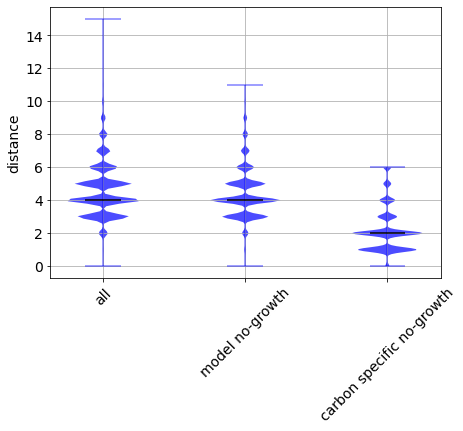

In [28]:
# Plot Distance Comparison
dist1 = dist_c.flatten()[dist_c.flatten()<24]
dist2 = dist_c.flatten()[data_fitness_sim_unique.flatten()<0.001]
dist3 = np.array(dist_list)

plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(7)

plt.grid()

vp = axs.violinplot([dist1,dist2,dist3],showmeans=False,showextrema=True,bw_method=0.1,showmedians=True)

axs.set_ylabel('distance');
axs.set_xticks([1,2,3])
axs.set_xticklabels(['all','model no-growth','carbon specific no-growth'],rotation=45)

for pc in vp['bodies']:
    pc.set_facecolor('b')
    pc.set_alpha(0.7)
vp['cbars'].set_color('b')
vp['cbars'].set_alpha(0.5)
vp['cmins'].set_color('b')
vp['cmins'].set_alpha(0.5)
vp['cmaxes'].set_color('b')
vp['cmaxes'].set_alpha(0.5)
vp['cmedians'].set_color('k')
vp['cmedians'].set_alpha(1)

# statistical tests
p_t12 = ttest_ind(dist1,dist2,equal_var=False,alternative='greater').pvalue
print('t-test 1,2',p_t12)
p_t13 = ttest_ind(dist1,dist3,equal_var=False,alternative='greater').pvalue
print('t-test 1,3',p_t13)
p_t23 = ttest_ind(dist2,dist3,equal_var=False,alternative='greater').pvalue
print('t-test 2,3',p_t23)

p_w12 = mannwhitneyu(dist1,dist2).pvalue
print('mann-whitney u-test 1,2',p_w12)
p_w13 = mannwhitneyu(dist1,dist3).pvalue
print('mann-whitney u-test 1,3',p_w13)
p_w23 = mannwhitneyu(dist2,dist3).pvalue
print('mann-whitney u-test 2,3',p_w23)


fig = plt.gcf()
image_format = 'svg'
image_name = 'plots/'+model_name+'_carbon_distance.svg'
fig.savefig(image_name, format=image_format, dpi=900)

In [29]:
print(np.mean(dist1))
print(np.mean(dist2))
print(np.mean(dist3))

4.636616454229432
4.419440042260962
2.2127659574468086


In [62]:
# Look at gluconeogenic fluxes for D serine
# set up model
# turn off exchange reactions by setting lower and upper bounds to 0/1000 respectively
for ex in model.exchanges:
    ex.lower_bound = 0
    ex.upper_bound = 1000

# Adjust Model for Strain BW25113
strain_gene_remove = ['araA','araB','valX','rhaA','rhaB','araD','lacZ','rhaD']
# ID's of the genes to be removed were found through search at http://bigg.ucsd.edu/models/iML1515/genes
# Genome variations from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4200154/ and https://bioinfo.ccs.usherbrooke.ca/BW25113.html
strain_gene_remove_id = ['b0062','b0063','b3903','b3904','b0061','b0344','b3902']
model_adj = copy.deepcopy(model)
#Knocking out the genes from the model
for i in range(len(strain_gene_remove_id)):
    model_adj.genes.get_by_id(strain_gene_remove_id[i]).knock_out()

# Loading the base medium
df_med = pd.read_table(base_directory+'Fitness_Data/E_coli_BW25113/exp_organism_Keio_Mapped_Media.txt', encoding='latin-1')    
med = df_med.loc[1,'M9 minimal media_noCarbon']
name_medium_model = med.split('; ')

# add base media
for e in range(len(name_medium_model)):
    model_adj.exchanges.get_by_id('EX_'+name_medium_model[e]+'_e').lower_bound = -1000

# add D-serine
model_adj.exchanges.get_by_id('EX_ser__D_e').lower_bound = -10

# No knockout
WT_sol = cobra.flux_analysis.pfba(model_adj) # simulate growth


Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmpkhuzyf6t.lp
Reading time = 0.02 seconds
: 1877 rows, 5428 columns, 21154 nonzeros


In [63]:
sol = WT_sol
met = 'ser__D_c'
for reaction in  model_adj.metabolites.get_by_id(met).reactions:
    if reaction.metabolites[model_adj.metabolites.get_by_id(met)] * sol.fluxes[reaction.id] != 0:
        print(reaction.id,reaction.name,reaction._gene_reaction_rule,sol.fluxes[reaction.id])

SERD_D D-serine deaminase b2366 9.436075416667489
DSERt2pp D-serine transport in via proton symport (periplasm) b4208 10.0
DSERDHr D-serine dehydrogenase b1539 0.563924583332511


In [64]:
met = 'pyr_c'
for reaction in  model_adj.metabolites.get_by_id(met).reactions:
    if reaction.metabolites[model_adj.metabolites.get_by_id(met)] * sol.fluxes[reaction.id] != 0:
        print(reaction.id,reaction.name,reaction._gene_reaction_rule,sol.fluxes[reaction.id])

POR5 Pyruvate synthase ( b1378 and b0684 ) or ( b1378 and b2895 ) 0.03462702350865488
DXPS 1-deoxy-D-xylulose 5-phosphate synthase b0420 0.0009026491807000663
CYSTL Cystathionine b-lyase b3008 0.049004457866218404
PDH Pyruvate dehydrogenase b0115 and b0116 and b0114 7.719889321492664
ACHBS 2-aceto-2-hydroxybutanoate synthase ( b3670 and b3671 ) or ( b0077 and b0078 ) 0.09250291492755273
ANS Anthranilate synthase b1263 and b1264 0.018098514066502414
PPS Phosphoenolpyruvate synthase b1702 0.7951754063259682
ALATA_L L-alanine transaminase b2290 or b2379 -0.18525608814647412
CHRPL Chorismate pyruvate lyase b4039 or b1096 7.100203431961786e-05
DHDPS Dihydrodipicolinate synthase b2478 0.11810822255079789
ACLS Acetolactate synthase ( b0077 and b0078 ) or ( b3670 and b3671 ) 0.27839388225085826
SERD_D D-serine deaminase b2366 9.436075416667489


In [65]:
met = 'pep_c'
for reaction in  model_adj.metabolites.get_by_id(met).reactions:
    if reaction.metabolites[model_adj.metabolites.get_by_id(met)] * sol.fluxes[reaction.id] != 0:
        print(reaction.id,reaction.name,reaction._gene_reaction_rule,sol.fluxes[reaction.id])

KDOPS 3-deoxy -D-manno-octulosonic -acid 8-phosphate synthase b1215 0.012389377396614219
DDPA 3-deoxy-D-arabino-heptulosonate 7-phosphate synthetase b2601 or b0754 or b1704 0.12113329128654089
PPS Phosphoenolpyruvate synthase b1702 0.7951754063259682
UAGCVT UDP-N-acetylglucosamine 1-carboxyvinyltransferase b3189 0.0088475539447244
PSCVT 3-phosphoshikimate 1-carboxyvinyltransferase b0908 0.12113329128654089
ENO Enolase b2779 -0.7623380170674289
PPCK Phosphoenolpyruvate carboxykinase b3403 0.2306661246558812


In [66]:
met = '2pg_c'
for reaction in  model_adj.metabolites.get_by_id(met).reactions:
    if reaction.metabolites[model_adj.metabolites.get_by_id(met)] * sol.fluxes[reaction.id] != 0:
        print(reaction.id,reaction.name,reaction._gene_reaction_rule,sol.fluxes[reaction.id])

ENO Enolase b2779 -0.7623380170674289
PGM Phosphoglycerate mutase b0755 or b3612 0.7623380170674289


In [67]:
met = '3pg_c'
for reaction in  model_adj.metabolites.get_by_id(met).reactions:
    if reaction.metabolites[model_adj.metabolites.get_by_id(met)] * sol.fluxes[reaction.id] != 0:
        print(reaction.id,reaction.name,reaction._gene_reaction_rule,sol.fluxes[reaction.id])

PGM Phosphoglycerate mutase b0755 or b3612 0.7623380170674289
PGK Phosphoglycerate kinase b2926 0.7623380170674289


In [68]:
met = '13dpg_c'
for reaction in  model_adj.metabolites.get_by_id(met).reactions:
    if reaction.metabolites[model_adj.metabolites.get_by_id(met)] * sol.fluxes[reaction.id] != 0:
        print(reaction.id,reaction.name,reaction._gene_reaction_rule,sol.fluxes[reaction.id])

GAPD Glyceraldehyde-3-phosphate dehydrogenase b1779 -0.7623380170674289
PGK Phosphoglycerate kinase b2926 0.7623380170674289


In [69]:
met = 'g3p_c'
for reaction in  model_adj.metabolites.get_by_id(met).reactions:
    if reaction.metabolites[model_adj.metabolites.get_by_id(met)] * sol.fluxes[reaction.id] != 0:
        print(reaction.id,reaction.name,reaction._gene_reaction_rule,sol.fluxes[reaction.id])

TRPS1 Tryptophan synthase (indoleglycerol phosphate) b1260 and b1261 0.018098514066502414
TPI Triose-phosphate isomerase b3919 -0.3200634797375957
F6PA Fructose 6-phosphate aldolase b0825 or b3946 -0.27594033213215785
GAPD Glyceraldehyde-3-phosphate dehydrogenase b1779 -0.7623380170674289
TKT2 Transketolase b2935 or b2465 -0.18353007008347766
TALA Transaldolase b0008 or b2464 -0.062325776762617156
DXPS 1-deoxy-D-xylulose 5-phosphate synthase b0420 0.0009026491807000663
TKT1 Transketolase b2935 or b2465 -0.062325776762617156


In [70]:
model.reactions.get_by_id('TPI')

<Reaction TPI at 0x7f851e135610>

## Part 12: iML1515 All Corrections Reaction Flux

### Part 12a: Run pFBA and Record Flux

In [146]:
# Run pFBA and Record Flux with All Corrections

# Re run FBA (each vitamin individually)
vitamins = ['btn','pnto__R','thm','thf','nad']

# List of all isoenzymes and associated reactions that had an impact on the prediction AUC (b3008, CYSDS was not included)
iso_genes = ['b0073','b3281','b2414','b3829','b3772','b0002','b0002','b3390','b3008']
iso_reactions = ['IPMD','SHK3Dr','CYSS','METS','THRD_L','ASPK','HSDy','SHKK','CYSTL']

model_names = ['iML1515']

# Load environment
[name_medium_model, name_carbon_model, name_carbon_experiment] = load_environment(base_directory)

# Load Data
[data_experiments,data_genes,data_fitness] = load_data(base_directory)

model_name = 'iML1515'
print(model_name)

# load model
print('loading model')
model = load_model(model_name,base_directory)
# optional printout check
print(str(len(model.genes))+' total genes in model')

# match model to data
print('matching model and data')
[name_genes_matched,name_carbon_experiment_matched,name_carbon_model_matched,data_fitness_matched] = match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness)
# optional printout checks
print(str(len(name_genes_matched))+' genes matched')
print(str(len(name_carbon_model_matched))+' carbon matched')

# adjust model
print('adjusting model')
adj_strain = 1
adj_essential = 1
adj_carbon = 1
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# optional printout checks
print(str(len(name_genes_matched_adj)),' adjusted genes matched')
print(str(len(name_carbon_model_matched_adj)),' adjusted carbon matched')
print(str(data_fitness_matched_adj.shape),' data shape')

# get medium and carbon exchange indicies
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
print(f'\n')

# Reset model exchanges
# turn off all exchange reactions (these should be off but just to make sure)
for ex in model_adj.exchanges:
    ex.lower_bound = 0
    ex.upper_bound = 1000
    
# Add vitamins
for i in range(3):
    # add vitamin
    #turn on exchange
    model_adj.exchanges.get_by_id('EX_'+vitamins[i]+'_e').lower_bound = -1000
for i in range(3,5):
    # add vitamin
    # add exchange directly to intracellular metabolite
    rxn = cobra.Reaction('EX_'+vitamins[i]+'_c')
    rxn.name = 'EX_'+vitamins[i]+'_c'
    rxn.lower_bound = -1000
    rxn.upper_bound = 1000
    rxn.add_metabolites({model_adj.metabolites.get_by_id(vitamins[i]+'_c'): -1.0})
    model_adj.add_reactions([rxn])    

# Adjust L-serine reaction reversibility
model_adj.reactions.get_by_id('GHMT2r').lower_bound = 0
    
# Adjust isoenzymes
for i in range(len(iso_genes)):
    # adjust isoenzyme reaction
    tmp_gpr = model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule
    model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule = iso_genes[i]

# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_flux_matched_adj = simulate_phenotype_flux(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)

# save data
np.save(model_name+'_fitness_sim_flux_all_corrections.npy',np.asarray(data_fitness_simulated_flux_matched_adj,dtype=np.double))

iML1515
loading model
1516 total genes in model
matching model and data
1339 genes matched
27 carbon matched
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmph70k39c7.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
removing genes (strain):
b0061
b0344
b3902
removing genes (essential):
b0142
b0641
b0908
b2329
b2687
b3040
b3196
b3198
b3199
b3368
removing carbon sources:
man
sucr
1326  adjusted genes matched
25  adjusted carbon matched
(1326, 25)  data shape
checking environment
medium components not found in model:
carbon components not found in model:




NameError: name 'cb' is not defined

### Part 12b: Run Wild Type (no-knockout) Flux

In [870]:
# Calculate Wild Type (no-knockout) flux for each carbon source

# Re run FBA (each vitamin individually)
vitamins = ['btn','pnto__R','thm','thf','nad']

# List of all isoenzymes and associated reactions that had an impact on the prediction AUC (b3008, CYSDS was not included)
iso_genes = ['b0073','b3281','b2414','b3829','b3772','b0002','b0002','b3390','b3008']
iso_reactions = ['IPMD','SHK3Dr','CYSS','METS','THRD_L','ASPK','HSDy','SHKK','CYSTL']

model_names = ['iML1515']

# Load environment
[name_medium_model, name_carbon_model, name_carbon_experiment] = load_environment(base_directory)

# Load Data
[data_experiments,data_genes,data_fitness] = load_data(base_directory)

model_name = 'iML1515'
print(model_name)

# load model
print('loading model')
model = load_model(model_name,base_directory)
# optional printout check
print(str(len(model.genes))+' total genes in model')

# match model to data
print('matching model and data')
[name_genes_matched,name_carbon_experiment_matched,name_carbon_model_matched,data_fitness_matched] = match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness)
# optional printout checks
print(str(len(name_genes_matched))+' genes matched')
print(str(len(name_carbon_model_matched))+' carbon matched')

# adjust model
print('adjusting model')
adj_strain = 1
adj_essential = 1
adj_carbon = 1
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# optional printout checks
print(str(len(name_genes_matched_adj)),' adjusted genes matched')
print(str(len(name_carbon_model_matched_adj)),' adjusted carbon matched')
print(str(data_fitness_matched_adj.shape),' data shape')

# get medium and carbon exchange indicies
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
print(f'\n')

# Reset model exchanges
# turn off all exchange reactions (these should be off but just to make sure)
for ex in model_adj.exchanges:
    ex.lower_bound = 0
    ex.upper_bound = 1000
    
# Add vitamins
for i in range(3):
    # add vitamin
    #turn on exchange
    model_adj.exchanges.get_by_id('EX_'+vitamins[i]+'_e').lower_bound = -1000
for i in range(3,5):
    # add vitamin
    # add exchange directly to intracellular metabolite
    rxn = cobra.Reaction('EX_'+vitamins[i]+'_c')
    rxn.name = 'EX_'+vitamins[i]+'_c'
    rxn.lower_bound = -1000
    rxn.upper_bound = 1000
    rxn.add_metabolites({model_adj.metabolites.get_by_id(vitamins[i]+'_c'): -1.0})
    model_adj.add_reactions([rxn])    

# Adjust L-serine reaction reversibility
model_adj.reactions.get_by_id('GHMT2r').lower_bound = 0
    
# Adjust isoenzymes
for i in range(len(iso_genes)):
    # adjust isoenzyme reaction
    tmp_gpr = model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule
    model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule = iso_genes[i]

# add base media
for e in range(len(medium_ex_inds)):
    if medium_ex_inds[e] != -1:
        model_adj.exchanges[medium_ex_inds[e]].lower_bound = -1000
            
print('running FBA')
# Re-Run FBA and Save Fluxes
WT_carbon_fluxes = np.zeros([len(name_carbon_model_matched_adj),len(model_adj.reactions)])
for c in range(len(name_carbon_model_matched_adj)):
    # turn on carbon source
    model_adj.exchanges.get_by_id('EX_'+name_carbon_model_matched_adj[c]+'_e').lower_bound = -10
    pfba_solution = cobra.flux_analysis.pfba(model_adj) # simulate growth
    WT_carbon_fluxes[c,:] = np.array(pfba_solution.fluxes)
    # turn off carbon source
    model_adj.exchanges.get_by_id('EX_'+name_carbon_model_matched_adj[c]+'_e').lower_bound = 0
    
# save data
np.save(model_name+'_wild_type_sim_flux_all_corrections.npy',np.asarray(WT_carbon_fluxes,dtype=np.double))

iML1515
loading model
1516 total genes in model
matching model and data
1339 genes matched
27 carbon matched
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmpl44w3l3k.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
removing genes (strain):
b0061
b0344
b3902
removing genes (essential):
b0142
b0641
b0908
b2329
b2687
b3040
b3196
b3198
b3199
b3368
removing carbon sources:
man
sucr
1326  adjusted genes matched
25  adjusted carbon matched
(1326, 25)  data shape
checking environment
medium components not found in model:
carbon components not found in model:


running FBA


Infeasible: None (infeasible).

### Part 12c: Visualize Flux Data

In [244]:
# Visualize Flux Data

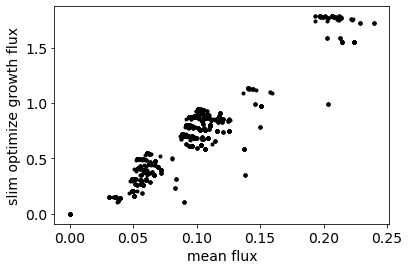

In [245]:
# Visualize Fluxes (mean flux vs biomass flux)
model_name = 'iML1515'

data_fluxes = np.load(model_name+'_fitness_sim_flux_all_corrections.npy')
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_all_corrections.npy')
plt.plot(np.mean(data_fluxes,2),data_fitness_sim_unique,'k.')
plt.xlabel('mean flux');
plt.ylabel('slim optimize growth flux');

In [246]:
# Visualize Fluxes (Wild Type PCA)
WT_carbon_fluxes = np.load(model_name+'_wild_type_sim_flux_all_corrections.npy')
data_fitness_unique = np.load(model_name+'_fitness.npy')

X = data_fluxes.reshape(data_fluxes.shape[0]*data_fluxes.shape[1],data_fluxes.shape[2])
y = data_fitness_unique.reshape(data_fluxes.shape[0]*data_fluxes.shape[1])
z = data_fitness_sim_unique.reshape(data_fluxes.shape[0]*data_fluxes.shape[1])

# only include samples with simulated growth
X1 = X[z>0.001,:]
y1 = y[z>0.001]

# add wild type flux
X2 = np.concatenate([WT_carbon_fluxes,X1])

pca = PCA(n_components=2)
pca.fit(X2)
C = pca.transform(X2)

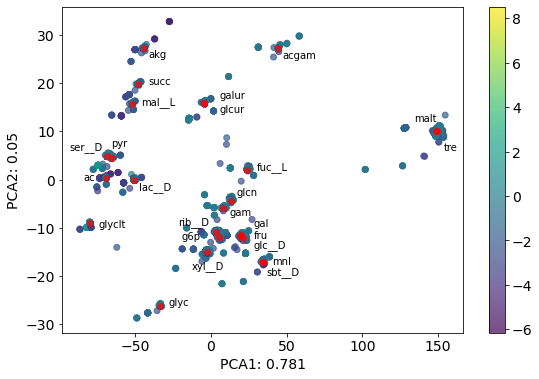

In [247]:

plt.scatter(C[25:,0],C[25:,1],c=y1,alpha=0.7,cmap='viridis')
plt.colorbar()
plt.scatter(C[:25,0],C[:25,1],c='r',alpha=0.7)
plt.xlabel('PCA1: '+str(np.round(pca.explained_variance_ratio_[0],3)))
plt.ylabel('PCA2: '+str(np.round(pca.explained_variance_ratio_[1],3)))
names_c = np.load('iML1515_names_carbon_model.npy')
shift = np.zeros([25,2])
shift[0,:] = [-15,-0.5]
shift[1,:] = [3,-2]
shift[2,:] = [3,-2]
shift[3,:] = [9,-0.5]
shift[4,:] = [6,0]
shift[5,:] = [-25,-0.5]
shift[6,:] = [7,2.5]
shift[7,:] = [10,1]
shift[8,:] = [4,-1.5]
shift[9,:] = [8,-2.5]
shift[10,:] = [4,1]
shift[11,:] = [10,-2]
shift[12,:] = [6,0]
shift[13,:] = [6,-1]
shift[14,:] = [3,-2]
shift[15,:] = [6,0]
shift[16,:] = [-15,2]
shift[17,:] = [6,-0.5]
shift[18,:] = [0,2.5]
shift[19,:] = [-25,1.5]
shift[20,:] = [2.5,-2.5]
shift[21,:] = [-25,1.5]
shift[22,:] = [7,0]
shift[23,:] = [5,-4]
shift[24,:] = [-10,-3.5]

for i,s in enumerate(names_c):
#    print(i,s)
    plt.text(C[i,0]+shift[i,0],C[i,1]+shift[i,1],s,fontsize=10)

fig = plt.gcf()
fig.set_size_inches(9, 6)
image_format = 'png'
image_name = 'plots/'+model_name+'_flux_PCA.png'
fig.savefig(image_name, format=image_format, dpi=900)

In [248]:
# Visualize FLuxes (Distance from Wild Type)

In [249]:
flux_distance = np.zeros([data_fluxes.shape[0],data_fluxes.shape[1]])
for c in range(WT_carbon_fluxes.shape[0]):
    flux_distance[:,c] = np.linalg.norm(np.squeeze(data_fluxes[:,c,:])-np.tile(WT_carbon_fluxes[c,:],(data_fluxes.shape[0],1)),2,1)
    

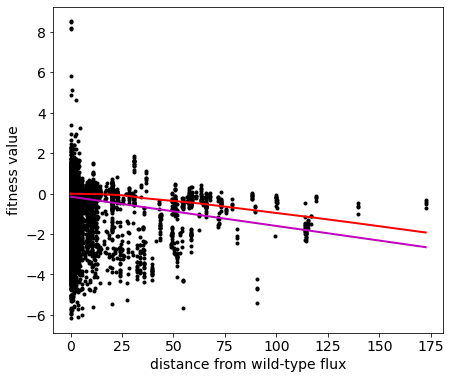

In [250]:
y = data_fitness_unique.reshape(data_fitness_unique.shape[0]*data_fitness_unique.shape[1])
x = flux_distance.reshape(data_fitness_unique.shape[0]*data_fitness_unique.shape[1])
z = data_fitness_sim_unique.reshape(data_fitness_unique.shape[0]*data_fitness_unique.shape[1])

# only include samples with simulated growth
thresh = 0.001
x1 = x[z>thresh]
y1 = y[z>thresh]

plt.plot(x1,y1,'k.')
plt.ylabel('fitness value');
plt.xlabel('distance from wild-type flux');

fit_p = np.polyfit(x1,y1,1);
x_fit = [np.min(x1),np.max(x1)]
y_fit = fit_p[0]*np.array(x_fit)+fit_p[1]
plt.plot(x_fit,y_fit,'m',linewidth=2)

lws = lowess(y1,x1,frac=0.5)
plt.plot(lws[:,0],lws[:,1],'r',linewidth=2)

r,p = pearsonr(x1,y1)

#plt.text(80,7.5,'pearson rho:'+str(np.round(r,3)))
#plt.text(80,6,'pearson p-val:'+str(np.round(p,3)))

plt.rcParams['font.size'] = 14

fig = plt.gcf()
fig.set_size_inches(7, 6)
image_format = 'png'
image_name = 'plots/'+model_name+'_flux_distance.png'
fig.savefig(image_name, format=image_format, dpi=900)

In [251]:
print(r,p)

-0.17538648560712491 2.3051571220035815e-214


### Part 12d: Machine Learning on Flux

Here we will train a machine learning model to predict the fitness value from the flux. We will investigate the feature importance in this model to see if there are any additional patterns in the data that we can learn from. We will calculate the test performance of this model using cross-validation on a test set of all samples not used in the training data, a test set of samples with completely new carbon sources and genes (not seen in the training data), and a test set with randomized flux indices (as a baseline).

In [15]:
model_name = 'iML1515'

data_fluxes = np.load(model_name+'_fitness_sim_flux_all_corrections.npy')
data_fitness_unique = np.load(model_name+'_fitness.npy')
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_all_corrections.npy')

x = data_fluxes.reshape(data_fluxes.shape[0]*data_fluxes.shape[1],data_fluxes.shape[2])
y = data_fitness_unique.reshape(data_fluxes.shape[0]*data_fluxes.shape[1])
z = data_fitness_sim_unique.reshape(data_fluxes.shape[0]*data_fluxes.shape[1])

c = np.tile(np.arange(data_fluxes.shape[1]),(data_fluxes.shape[0],1)).reshape(data_fluxes.shape[0]*data_fluxes.shape[1])
g = np.transpose(np.tile(np.transpose(np.arange(data_fluxes.shape[0])),(data_fluxes.shape[1],1))).reshape(data_fluxes.shape[0]*data_fluxes.shape[1])

# only include samples with simulated growth
thresh = 0.001
x1 = x[z>thresh]
y1 = y[z>thresh]
c1 = c[z>thresh]
g1 = g[z>thresh]


In [16]:
# flux labels
model_name_load = 'iML1515_model_adjusted_all_corrections'
model_adj = cobra.io.read_sbml_model(model_name_load+'.xml')
reaction_ids = []
for i in range(len(model_adj.reactions)):
    reaction_ids.append(model_adj.reactions[i].id)

Academic license - for non-commercial use only - expires 2023-09-03
Using license file /Users/david/gurobi.lic


In [17]:
# remove all fluxes with variance below a certain threshold (same value across all simulations)
x1_t = np.transpose(x1)

var_thresh = 1e-7

x1_t_noZ = x1_t[np.argwhere(x1_t.var(1)>var_thresh)[:,0]]
reaction_ids_noZ = np.array(reaction_ids)[np.argwhere(x1_t.var(1)>var_thresh)[:,0]]

In [18]:
print(x1_t_noZ.shape[0],'variable fluxes remaining')

579 variable fluxes remaining


In [19]:
# Assign clusters based on correlation threshold
corr_matrix = np.corrcoef(x1_t_noZ)
corr_thresh = 0.99
corr_matrix_adj = (np.abs(corr_matrix)>=corr_thresh).astype(int)
cc = connected_components(corr_matrix_adj)
x_cluster = np.zeros([cc[0],x1_t_noZ.shape[1]])
for i in range(cc[0]):
    x_cluster[i,:] = x1_t_noZ[np.argwhere(cc[1]==i)[0,0],:]

In [20]:
print(cc[0],'variable flux clusters')

172 variable flux clusters


In [21]:
# Initialize Variables
fit_thresh = -2
y1_b = (y1<fit_thresh).astype(int) #1 case is fitness less than threshold (false positive)

X = np.transpose(x_cluster)

n = 100
#repeated train/test splits
feature_importance = np.zeros([n,X.shape[1]])
feature_importance_shap = np.zeros([n,X.shape[1]])
test_score_rocauc = np.zeros(n)
test_score_prerec = np.zeros(n)
test_score_rocauc_2 = np.zeros(n)
test_score_prerec_2 = np.zeros(n)
test_score_rocauc_P = np.zeros(n)
test_score_prerec_P = np.zeros(n)

# Save predictions
test_c_n = []
test_g_n = []
test_y_n = []
test_y_p_n = []

test_c_n_2 = []
test_g_n_2 = []
test_y_n_2 = []
test_y_p_n_2 = []

shap_vals_0 = np.zeros([n,X.shape[0],X.shape[1]])
shap_vals_1 = np.zeros([n,X.shape[0],X.shape[1]])

n_leaves = 5

In [22]:
### Skip this part if ML results are being loaded below ###
# ML classification
for n1 in range(n):
    print(n1)
    # intialize lightgbm model
    ml_model = lgbm.LGBMClassifier(importance_type='gain',num_leaves=n_leaves)
    
    # random train/test split
    # Randomly choose p = 20% of carbon sources and genes (Note: this will lead to p**2 of the data in the test set, (1-p)**2 in the train set, and 2(p(1-p)) tossed for each split)
    p = 0.2
    test_g = np.random.choice(range(data_fluxes.shape[0]),size=int(np.floor(data_fluxes.shape[0]*p)),replace=False)
    test_c = np.random.choice(range(data_fluxes.shape[1]),size=int(np.floor(data_fluxes.shape[1]*p)),replace=False)
    train_g = np.array([i for i in range(data_fluxes.shape[0]) if i not in test_g])
    train_c = np.array([i for i in range(data_fluxes.shape[1]) if i not in test_c])
    test_g_inds = np.nonzero(np.in1d(g1,test_g))[0]
    test_c_inds = np.nonzero(np.in1d(c1,test_c))[0]
    train_g_inds = np.nonzero(np.in1d(g1,train_g))[0]
    train_c_inds = np.nonzero(np.in1d(c1,train_c))[0]
    test_inds = np.intersect1d(test_g_inds,test_c_inds) #from chosen genes and carbon sources
    train_inds = np.intersect1d(train_g_inds,train_c_inds) #not includeing genes or carbon sources
    test_inds_2 = np.array([i for i in range(X.shape[0]) if i not in train_inds])#other data points that include the same genes and carbon sources
    x_test = X[test_inds,:]
    x_train = X[train_inds,:]
    y_test = y1_b[test_inds]
    y_train = y1_b[train_inds]
    x_test_2 = X[test_inds_2,:]
    y_test_2 = y1_b[test_inds_2]
    print(len(y_test),'test samples')
    print(len(y_train),'train samples')
    print(len(y_test_2),'test 2 samples')
    
    # train and validate
    ml_model.fit(x_train,y_train)
    feature_importance[n1,:] = ml_model.feature_importances_
    y_pred = ml_model.predict_proba(x_test)[:,1]
    y_pred_ = ml_model.predict(x_test)
    # Cross-validate new genes/carbon sources
    test_score_rocauc[n1] = roc_auc_score(y_test,y_pred)
    test_score_prerec[n1] = average_precision_score(y_test,y_pred)
    # Cross-valdiate new samples
    y_pred_2 = ml_model.predict_proba(x_test_2)[:,1]
    y_pred_2_ = ml_model.predict(x_test_2)
    test_score_rocauc_2[n1] = roc_auc_score(y_test_2,y_pred_2)
    test_score_prerec_2[n1] = average_precision_score(y_test_2,y_pred_2)
    # Cross-validate Permutation (baseline performance)
    y_test_P = np.random.permutation(y_test_2)
    test_score_rocauc_P[n1] = roc_auc_score(y_test_P,y_pred_2)
    test_score_prerec_P[n1] = average_precision_score(y_test_P,y_pred_2)
    
    # shap
    explainer = shap.TreeExplainer(ml_model)
    shap_vals_0[n1,:,:] = explainer.shap_values(X)[0]
    shap_vals_1[n1,:,:] = explainer.shap_values(X)[1]

    test_c_n.append(c1[test_inds])
    test_g_n.append(g1[test_inds])
    test_y_n.append(y_pred_)
    test_y_p_n.append(y_pred)
    
    test_c_n_2.append(c1[test_inds_2])
    test_g_n_2.append(g1[test_inds_2])
    test_y_n_2.append(y_pred_2_)
    test_y_p_n_2.append(y_pred_2)

0
1238 test samples
20054 train samples
11203 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


1
1232 test samples
20078 train samples
11179 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


2
1250 test samples
20007 train samples
11250 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


3
1255 test samples
19990 train samples
11267 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


4
1240 test samples
20057 train samples
11200 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


5
1255 test samples
19992 train samples
11265 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


6
1237 test samples
20053 train samples
11204 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


7
1262 test samples
19950 train samples
11307 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


8
1244 test samples
20034 train samples
11223 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


9
1269 test samples
19935 train samples
11322 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


10
1269 test samples
19941 train samples
11316 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


11
1219 test samples
20134 train samples
11123 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


12
1248 test samples
20017 train samples
11240 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


13
1263 test samples
19948 train samples
11309 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


14
1247 test samples
20016 train samples
11241 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


15
1241 test samples
20050 train samples
11207 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


16
1248 test samples
20012 train samples
11245 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


17
1240 test samples
20054 train samples
11203 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


18
1263 test samples
19954 train samples
11303 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


19
1259 test samples
19970 train samples
11287 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


20
1260 test samples
19954 train samples
11303 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


21
1254 test samples
19994 train samples
11263 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


22
1239 test samples
20045 train samples
11212 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


23
1249 test samples
20007 train samples
11250 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


24
1264 test samples
19952 train samples
11305 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


25
1265 test samples
19932 train samples
11325 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


26
1253 test samples
19989 train samples
11268 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


27
1272 test samples
19919 train samples
11338 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


28
1269 test samples
19929 train samples
11328 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


29
1247 test samples
20019 train samples
11238 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


30
1245 test samples
20026 train samples
11231 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


31
1259 test samples
19978 train samples
11279 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


32
1257 test samples
19971 train samples
11286 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


33
1246 test samples
20013 train samples
11244 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


34
1248 test samples
20013 train samples
11244 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


35
1234 test samples
20069 train samples
11188 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


36
1246 test samples
20018 train samples
11239 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


37
1290 test samples
19845 train samples
11412 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


38
1250 test samples
20004 train samples
11253 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


39
1241 test samples
20053 train samples
11204 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


40
1279 test samples
19898 train samples
11359 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


41
1222 test samples
20117 train samples
11140 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


42
1225 test samples
20106 train samples
11151 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


43
1279 test samples
19893 train samples
11364 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


44
1269 test samples
19932 train samples
11325 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


45
1250 test samples
20010 train samples
11247 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


46
1239 test samples
20051 train samples
11206 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


47
1224 test samples
20115 train samples
11142 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


48
1195 test samples
20232 train samples
11025 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


49
1238 test samples
20045 train samples
11212 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


50
1259 test samples
19973 train samples
11284 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


51
1221 test samples
20119 train samples
11138 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


52
1232 test samples
20064 train samples
11193 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


53
1244 test samples
20030 train samples
11227 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


54
1257 test samples
19978 train samples
11279 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


55
1221 test samples
20119 train samples
11138 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


56
1253 test samples
19988 train samples
11269 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


57
1259 test samples
19966 train samples
11291 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


58
1270 test samples
19927 train samples
11330 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


59
1234 test samples
20068 train samples
11189 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


60
1230 test samples
20095 train samples
11162 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


61
1270 test samples
19924 train samples
11333 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


62
1276 test samples
19894 train samples
11363 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


63
1233 test samples
20069 train samples
11188 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


64
1270 test samples
19914 train samples
11343 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


65
1260 test samples
19968 train samples
11289 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


66
1269 test samples
19934 train samples
11323 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


67
1269 test samples
19931 train samples
11326 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


68
1258 test samples
19972 train samples
11285 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


69
1232 test samples
20070 train samples
11187 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


70
1233 test samples
20079 train samples
11178 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


71
1265 test samples
19931 train samples
11326 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


72
1271 test samples
19908 train samples
11349 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


73
1215 test samples
20143 train samples
11114 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


74
1244 test samples
20032 train samples
11225 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


75
1240 test samples
20050 train samples
11207 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


76
1250 test samples
20013 train samples
11244 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


77
1264 test samples
19953 train samples
11304 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


78
1250 test samples
20009 train samples
11248 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


79
1255 test samples
19991 train samples
11266 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


80
1252 test samples
19989 train samples
11268 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


81
1245 test samples
20030 train samples
11227 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


82
1268 test samples
19932 train samples
11325 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


83
1253 test samples
19992 train samples
11265 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


84
1244 test samples
20037 train samples
11220 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


85
1252 test samples
19994 train samples
11263 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


86
1245 test samples
20034 train samples
11223 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


87
1249 test samples
20008 train samples
11249 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


88
1254 test samples
19995 train samples
11262 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


89
1274 test samples
19909 train samples
11348 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


90
1226 test samples
20094 train samples
11163 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


91
1257 test samples
19976 train samples
11281 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


92
1259 test samples
19981 train samples
11276 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


93
1260 test samples
19976 train samples
11281 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


94
1259 test samples
19967 train samples
11290 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


95
1264 test samples
19955 train samples
11302 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


96
1262 test samples
19952 train samples
11305 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


97
1228 test samples
20095 train samples
11162 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


98
1238 test samples
20048 train samples
11209 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


99
1253 test samples
19995 train samples
11262 test 2 samples


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [24]:
### Skip if loading results below ###
# Save Results
np.save(model_name+'_ML_'+str(n_leaves)+'_shap_vals_0.npy',np.asarray(shap_vals_0,dtype=np.double))
np.save(model_name+'_ML_'+str(n_leaves)+'_shap_vals_1.npy',np.asarray(shap_vals_1,dtype=np.double))
np.save(model_name+'_ML_'+str(n_leaves)+'_test_score_rocauc.npy',np.asarray(test_score_rocauc,dtype=np.double))
np.save(model_name+'_ML_'+str(n_leaves)+'_test_score_prerec.npy',np.asarray(test_score_prerec,dtype=np.double))
np.save(model_name+'_ML_'+str(n_leaves)+'_test_score_rocauc_2.npy',np.asarray(test_score_rocauc_2,dtype=np.double))
np.save(model_name+'_ML_'+str(n_leaves)+'_test_score_prerec_2.npy',np.asarray(test_score_prerec_2,dtype=np.double))
np.save(model_name+'_ML_'+str(n_leaves)+'_test_score_rocauc_P.npy',np.asarray(test_score_rocauc_P,dtype=np.double))
np.save(model_name+'_ML_'+str(n_leaves)+'_test_score_prerec_P.npy',np.asarray(test_score_prerec_P,dtype=np.double))

np.save(model_name+'_ML_'+str(n_leaves)+'_test_g_n.npy',np.array(test_g_n,dtype=object))
np.save(model_name+'_ML_'+str(n_leaves)+'_test_c_n.npy',np.array(test_c_n,dtype=object))
np.save(model_name+'_ML_'+str(n_leaves)+'_test_y_n.npy',np.array(test_y_n,dtype=object))
np.save(model_name+'_ML_'+str(n_leaves)+'_test_y_p_n.npy',np.array(test_y_p_n,dtype=object))
np.save(model_name+'_ML_'+str(n_leaves)+'_test_g_n_2.npy',np.array(test_g_n_2,dtype=object))
np.save(model_name+'_ML_'+str(n_leaves)+'_test_c_n_2.npy',np.array(test_c_n_2,dtype=object))
np.save(model_name+'_ML_'+str(n_leaves)+'_test_y_n_2.npy',np.array(test_y_n_2,dtype=object))
np.save(model_name+'_ML_'+str(n_leaves)+'_test_y_p_n_2.npy',np.array(test_y_p_n_2,dtype=object))

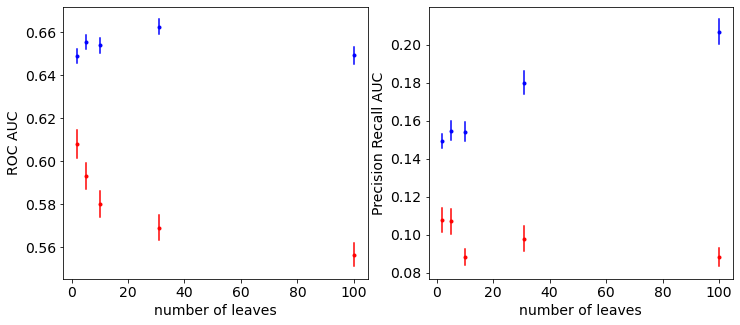

In [22]:
# Plot comparison of accuracy for different num_leaves
plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(12)
# Plot comparisons with different num_leaves
nums = np.array([2,5,10,31,100])
for i in range(len(nums)):
    rocauc = np.load(model_name+'_ML_'+str(nums[i])+'_test_score_rocauc.npy')
    rocauc2 = np.load(model_name+'_ML_'+str(nums[i])+'_test_score_rocauc_2.npy')
    prerec = np.load(model_name+'_ML_'+str(nums[i])+'_test_score_prerec.npy')
    prerec2 = np.load(model_name+'_ML_'+str(nums[i])+'_test_score_prerec_2.npy')
    axs[0].plot(nums[i],np.mean(rocauc),'r.')
    axs[0].plot([nums[i],nums[i]],[np.mean(rocauc)+np.std(rocauc)/10,np.mean(rocauc)-np.std(rocauc)/10],'r')
    axs[0].plot(nums[i],np.mean(rocauc2),'b.')
    axs[0].plot([nums[i],nums[i]],[np.mean(rocauc2)+np.std(rocauc2)/10,np.mean(rocauc2)-np.std(rocauc2)/10],'b')
    
    axs[1].plot(nums[i],np.mean(prerec),'r.')
    axs[1].plot([nums[i],nums[i]],[np.mean(prerec)+np.std(prerec)/10,np.mean(prerec)-np.std(prerec)/10],'r')
    axs[1].plot(nums[i],np.mean(prerec2),'b.')
    axs[1].plot([nums[i],nums[i]],[np.mean(prerec2)+np.std(prerec2)/10,np.mean(prerec2)-np.std(prerec2)/10],'b')
axs[0].set_xlabel('number of leaves')
axs[1].set_xlabel('number of leaves')
axs[0].set_ylabel('ROC AUC')
axs[1].set_ylabel('Precision Recall AUC')

fig = plt.gcf()
image_format = 'svg'
image_name = 'plots/'+model_name+'_flux_ML_accuracy_vs_Leaves.svg'
fig.savefig(image_name, format=image_format, dpi=900)

In [23]:
# Load Results
n_leaves = 5
n = 100
test_score_rocauc = np.load(model_name+'_ML_'+str(n_leaves)+'_test_score_rocauc.npy')
test_score_rocauc_2 = np.load(model_name+'_ML_'+str(n_leaves)+'_test_score_rocauc_2.npy')
test_score_rocauc_P = np.load(model_name+'_ML_'+str(n_leaves)+'_test_score_rocauc_P.npy')
test_score_prerec = np.load(model_name+'_ML_'+str(n_leaves)+'_test_score_prerec.npy')
test_score_prerec_2 = np.load(model_name+'_ML_'+str(n_leaves)+'_test_score_prerec_2.npy')
test_score_prerec_P = np.load(model_name+'_ML_'+str(n_leaves)+'_test_score_prerec_P.npy')
shap_vals_0 = np.load(model_name+'_ML_'+str(n_leaves)+'_shap_vals_0.npy')
shap_vals_1 = np.load(model_name+'_ML_'+str(n_leaves)+'_shap_vals_1.npy')

test_g_n = np.load(model_name+'_ML_'+str(n_leaves)+'_test_g_n.npy',allow_pickle=True)
test_c_n = np.load(model_name+'_ML_'+str(n_leaves)+'_test_c_n.npy',allow_pickle=True)
test_y_n = np.load(model_name+'_ML_'+str(n_leaves)+'_test_y_n.npy',allow_pickle=True)
test_y_p_n = np.load(model_name+'_ML_'+str(n_leaves)+'_test_y_p_n.npy',allow_pickle=True)
test_g_n_2 = np.load(model_name+'_ML_'+str(n_leaves)+'_test_g_n_2.npy',allow_pickle=True)
test_c_n_2 = np.load(model_name+'_ML_'+str(n_leaves)+'_test_c_n_2.npy',allow_pickle=True)
test_y_n_2 = np.load(model_name+'_ML_'+str(n_leaves)+'_test_y_n_2.npy',allow_pickle=True)
test_y_p_n_2 = np.load(model_name+'_ML_'+str(n_leaves)+'_test_y_p_n_2.npy',allow_pickle=True)

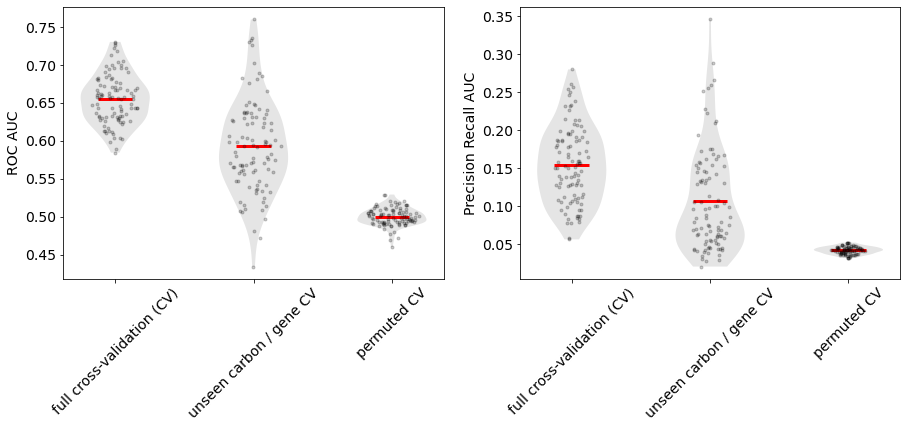

In [24]:
# Plot ML Performance Metrics

plt.rcParams['font.size'] = 14

fig, axs = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)

scores = np.array([test_score_rocauc_2,test_score_rocauc,test_score_rocauc_P])
scores_d = np.abs(scores - np.matmul(np.transpose(np.array([np.median(scores,1),])),np.ones([1,scores.shape[1]])))
scores_d1 = 1-np.matmul(1/np.max(scores_d,1)*np.eye(3),scores_d)
axs[0].plot([np.ones(n),2*np.ones(n),3*np.ones(n)]+0.4*(np.random.rand(3,n)-0.5)*scores_d1,[test_score_rocauc_2,test_score_rocauc,test_score_rocauc_P],'k.',alpha=0.2)
vp = axs[0].violinplot([test_score_rocauc_2,test_score_rocauc,test_score_rocauc_P],showmeans=True,showextrema=False)
for pc in vp['bodies']:
    pc.set_facecolor('k')
    pc.set_alpha(0.1)
vp['cmeans'].set_edgecolor('r')
vp['cmeans'].set_linewidth(3)

axs[0].set_ylabel('ROC AUC')
axs[0].set_xticks([1,2,3])
axs[0].set_xticklabels(['full cross-validation (CV)','unseen carbon / gene CV','permuted CV'],rotation=45)

scores = np.array([test_score_prerec_2,test_score_prerec,test_score_prerec_P])
scores_d = np.abs(scores - np.matmul(np.transpose(np.array([np.median(scores,1),])),np.ones([1,scores.shape[1]])))
scores_d1 = 1-np.matmul(1/np.max(scores_d,1)*np.eye(3),scores_d)
axs[1].plot([np.ones(n),2*np.ones(n),3*np.ones(n)]+0.3*(np.random.rand(3,n)-0.5)*scores_d1,[test_score_prerec_2,test_score_prerec,test_score_prerec_P],'k.',alpha=0.2)
vp = axs[1].violinplot([test_score_prerec_2,test_score_prerec,test_score_prerec_P],showmeans=True,showextrema=False)
for pc in vp['bodies']:
    pc.set_facecolor('k')
    pc.set_alpha(0.1)
vp['cmeans'].set_edgecolor('r')
vp['cmeans'].set_linewidth(3)

axs[1].set_ylabel('Precision Recall AUC')
axs[1].set_xticks([1,2,3])
axs[1].set_xticklabels(['full cross-validation (CV)','unseen carbon / gene CV','permuted CV'],rotation=45);

fig = plt.gcf()
image_format = 'svg'
image_name = 'plots/'+model_name+'_flux_ML_accuracy.svg'
fig.savefig(image_name, format=image_format, dpi=900)

In [25]:
feature_names = []
for i in range(X.shape[1]):
    feature_names.append(str(i)+', '+reaction_ids_noZ[np.argwhere(cc[1]==i)[:,0]][0]+', '+model_adj.reactions.get_by_id(reaction_ids_noZ[np.argwhere(cc[1]==i)[:,0]][0]).name)

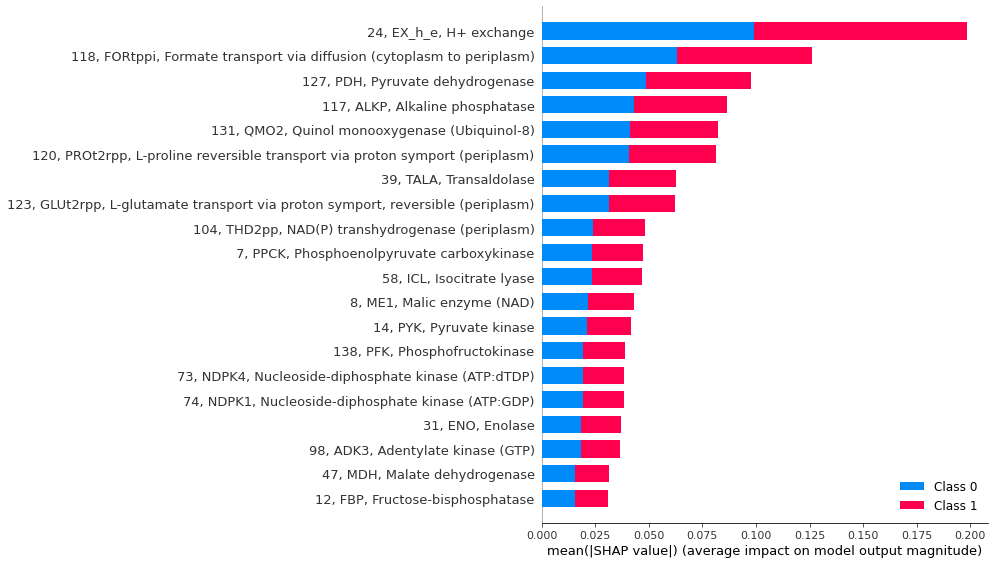

In [26]:
shap.summary_plot([np.mean(shap_vals_0,0),np.mean(shap_vals_1,0)],X,max_display=20,feature_names=feature_names)

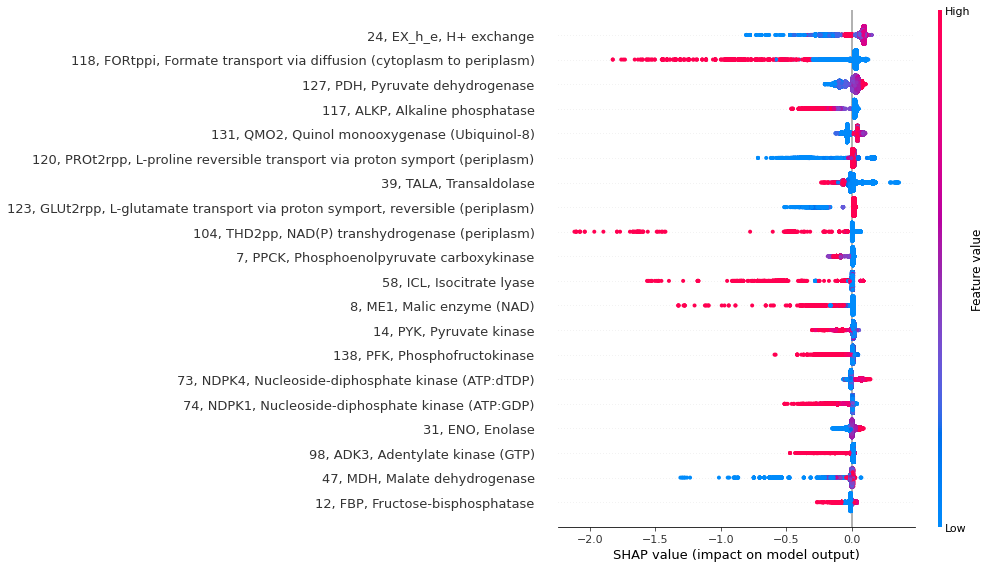

In [27]:
shap.summary_plot(np.mean(shap_vals_0,0),X,max_display=20,feature_names=feature_names,show=False)

fig = plt.gcf()
image_format = 'svg'
image_name = 'plots/'+model_name+'_flux_ML_shap.svg'
fig.savefig(image_name, format=image_format, dpi=900)

plt.show()

In [36]:
feature_ind = 120
for i,ID in enumerate(reaction_ids_noZ[np.argwhere(cc[1]==feature_ind)[:,0]]):
    print(model_adj.reactions.get_by_id(ID).name,model_adj.reactions.get_by_id(ID).id)

L-proline reversible transport via proton symport (periplasm) PROt2rpp
Na+/Proline-L symporter (periplasm) PROt4pp


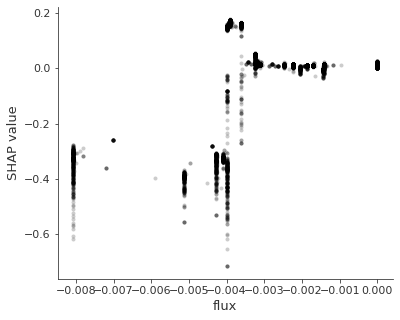

In [37]:
rank = 5
shap.dependence_plot('rank('+str(rank)+')',np.mean(shap_vals_0,0),X,interaction_index=None,color='k',alpha=0.2,show=False)
plt.xlabel('flux')
plt.ylabel('SHAP value')

fig = plt.gcf()
image_format = 'svg'
image_name = 'plots/'+model_name+'_flux_ML_shap_'+str(rank)+'.svg'
fig.savefig(image_name, format=image_format, dpi=900)

plt.show()

In [62]:
# Data printout (for escher visualization)
shap_vals_0_m = np.mean(shap_vals_0,0)
# Sort
sort_inds = np.argsort(np.mean(np.abs(shap_vals_0_m),0)*-1)
m = 20
# Print top m reactions, shap values, correlation between shap and flux
for m1 in range(m):
    feature_ind = sort_inds[m1]
    shap_v = np.mean(np.abs(shap_vals_0_m),0)[feature_ind]
    shap_c = spearmanr(shap_vals_0_m[:,feature_ind],X[:,feature_ind]).correlation
    #ID = reaction_ids_noZ[np.argwhere(cc[1]==feature_ind)[:,0]][0]
    for i,ID in enumerate(reaction_ids_noZ[np.argwhere(cc[1]==feature_ind)[:,0]]):
        if i == 0:
            print(str(m1)+','+model_adj.reactions.get_by_id(ID).id+','+model_adj.reactions.get_by_id(ID).name.replace(',','')+','+str(shap_v)+','+str(shap_c)) 
        if i != 0:
            ind1 = reaction_ids.index(reaction_ids_noZ[np.argwhere(cc[1]==feature_ind)[:,0]][0])
            ind2 = reaction_ids.index(ID)
            flux_c = np.round(pearsonr(x1[:,ind1],x1[:,ind2])[0],0)
            print(str(m1)+','+model_adj.reactions.get_by_id(ID).id+','+model_adj.reactions.get_by_id(ID).name.replace(',','')+','+str(shap_v)+','+str(flux_c*shap_c)) 
            

0,EX_h_e,H+ exchange,0.09918824550983217,0.5805344622141692
0,Htex,Proton transport via diffusion (extracellular to periplasm),0.09918824550983217,-0.5805344622141692
1,FORtppi,Formate transport via diffusion (cytoplasm to periplasm),0.06309347353888972,-0.6940261332173298
1,FDH4pp,Formate dehydrogenase (quinone-8) (periplasm),0.06309347353888972,-0.6940261332173298
2,PDH,Pyruvate dehydrogenase,0.048885442252106726,0.9536297744829134
3,ALKP,Alkaline phosphatase,0.04324576544434225,-0.5388414233922884
4,QMO2,Quinol monooxygenase (Ubiquinol-8),0.04104738457279002,0.7582610742421975
5,PROt2rpp,L-proline reversible transport via proton symport (periplasm),0.04070099715827922,-0.17805526791494097
5,PROt4pp,Na+/Proline-L symporter (periplasm),0.04070099715827922,0.17805526791494097
6,TALA,Transaldolase,0.03134885815210482,-0.948139491004572
7,GLUt2rpp,L-glutamate transport via proton symport reversible (periplasm),0.03118961773268728,0.41094320885349594
7,GLUt4pp,Na+/glutamate symport (perip

(0.11837928289863066, 0.12194708078300633)

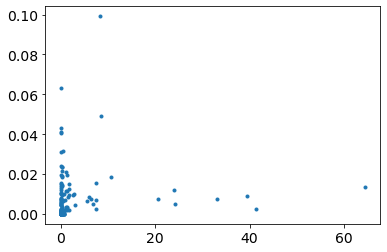

In [63]:
# total flux
t_flux = np.mean(np.abs(X),0)
t_shap = np.mean(np.abs(shap_vals_0_m),0)
plt.plot(t_flux,t_shap,'.')
pearsonr(t_flux,t_shap)

In [64]:
# Model Overall Performance with ML

# load data
model_name = 'iML1515'
model = cobra.io.read_sbml_model(base_directory+'Models/'+model_name+'.xml')
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_all_corrections.npy')
data_fitness_unique = np.load(model_name+'_fitness.npy')
name_carbon_unique = np.load(model_name+'_names_carbon_model.npy')
name_genes_data = np.load(model_name+'_names_genes.npy')

In [65]:
# Update data_fitness_sim_unique with ML results
sum_ML_yps = np.zeros(data_fitness_sim_unique.shape)
sum_ML_yps_2 = np.zeros(data_fitness_sim_unique.shape)

ones_ML_yps = np.zeros(data_fitness_sim_unique.shape)
ones_ML_yps_2 = np.zeros(data_fitness_sim_unique.shape)

for i in range(n):
    cs = test_c_n[i]
    gs = test_g_n[i]
    yps = test_y_p_n[i]
    
    cs_2 = test_c_n_2[i]
    gs_2 = test_g_n_2[i]
    yps_2 = test_y_p_n_2[i]
    
    for j in range(len(cs)):
        sum_ML_yps[gs[j],cs[j]] = sum_ML_yps[gs[j],cs[j]] + yps[j]
        sum_ML_yps_2[gs_2[j],cs_2[j]] = sum_ML_yps_2[gs_2[j],cs_2[j]] + yps_2[j]
        
        ones_ML_yps[gs[j],cs[j]] = ones_ML_yps[gs[j],cs[j]] + 1
        ones_ML_yps_2[gs_2[j],cs_2[j]] = ones_ML_yps_2[gs_2[j],cs_2[j]] + 1

avg_ML_yps = sum_ML_yps/ones_ML_yps
avg_ML_yps_2 = sum_ML_yps_2/ones_ML_yps_2

data_fitness_sim_unique_ML = data_fitness_sim_unique.copy()
data_fitness_sim_unique_ML_2 = data_fitness_sim_unique.copy()

print('new gene/carbon CV')
for g in range(data_fitness_sim_unique.shape[0]):
    for c in range(data_fitness_sim_unique.shape[1]):
        if avg_ML_yps[g,c] > 0.5:
            print(g,c,avg_ML_yps[g,c],data_fitness_sim_unique[g,c],data_fitness_unique[g,c])
            data_fitness_sim_unique_ML[g,c] = 0

print('full CV')
for g in range(data_fitness_sim_unique.shape[0]):
    for c in range(data_fitness_sim_unique.shape[1]):
        if avg_ML_yps_2[g,c] > 0.5:
            print(g,c,avg_ML_yps_2[g,c],data_fitness_sim_unique[g,c],data_fitness_unique[g,c])
            data_fitness_sim_unique_ML_2[g,c] = 0

invalid value encountered in true_divide
invalid value encountered in true_divide


new gene/carbon CV
4 10 0.7219329940888113 0.7981455601649275 -0.255
9 2 0.5381837407764687 0.5480882528341527 -3.554
9 10 0.7372412523439988 0.7981455601649248 -3.5305
10 10 0.715509822130195 0.7981455601649248 -3.972
11 10 0.8438215467155242 0.7981455601649248 -0.021
12 10 0.5444698000153321 0.7981455601649248 -0.033
14 10 0.6212192143038503 0.7981455601649248 -0.0125
15 10 0.5548601275938908 0.7981455601649248 -0.087
17 10 0.5693667906833013 0.7981455601649248 -4.4455
20 10 0.638702811114896 0.7980545217241922 -0.2895
20 21 0.5885805198257124 0.31842734685231067 -0.1175
21 10 0.56555926495013 0.7980545217241922 -0.3945
21 21 0.5090593555840427 0.31842734685231067 -0.009000000000000001
26 10 0.5736685705313281 0.7981455601649323 -3.298
30 10 0.6748579519759942 0.7981455601649308 -0.1865
31 10 0.6596935201867055 0.7981455601649308 -0.8089999999999999
32 10 0.7091003788841286 0.7981455601649308 -0.263
38 2 0.5275789609217226 0.548088252834153 0.307
39 10 0.5220648262267811 0.7981455601

(0.0, 1100.0)

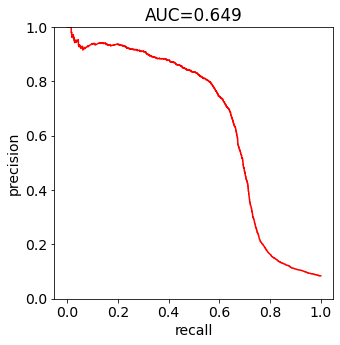

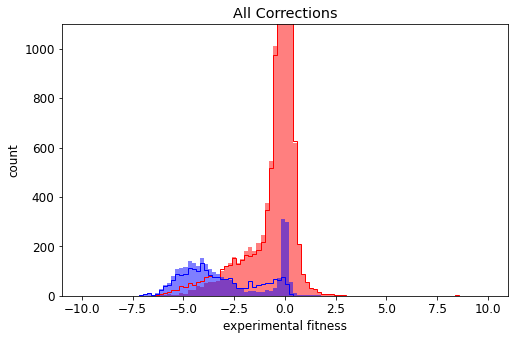

In [66]:
# Visualize results
    
# plot precision recall curve
[fig,axs,AUC] = plot_precision_recall_curve(model_name,data_fitness_sim_unique_ML,data_fitness_unique)
#image_format = 'svg'
#image_name = 'plots/all_corrections_prerec.svg'
#fig.savefig(image_name, format=image_format, dpi=1200)

# plot histogram
ylim = [0,1100]
[fig,axs,_,_] = plot_histogram(model_name,data_fitness_sim_unique_ML,data_fitness_unique,ylim)
axs.set_title('All Corrections')

# add old data outline to plot
data_fitness_sim_unique_orig = np.load(model_name+'_fitness_sim.npy')
sim_thresh = 0.001
data_sim_b = (data_fitness_sim_unique_orig > sim_thresh).astype(int)
# plot histogram
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==1],bins=100,range=(-10,10),histtype=u'step',edgecolor='r',lw=1)
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==0],bins=100,range=(-10,10),histtype=u'step',edgecolor='b',lw=1)
axs.set_ylim(ylim)

#image_format = 'svg'
#image_name = 'plots/all_corrections_hist.svg'
#fig.savefig(image_name, format=image_format, dpi=1200)

(0.0, 1100.0)

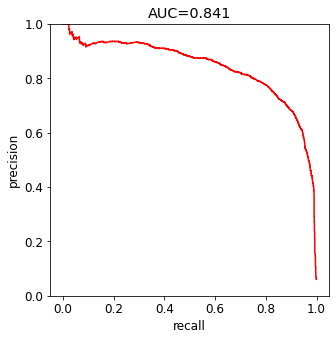

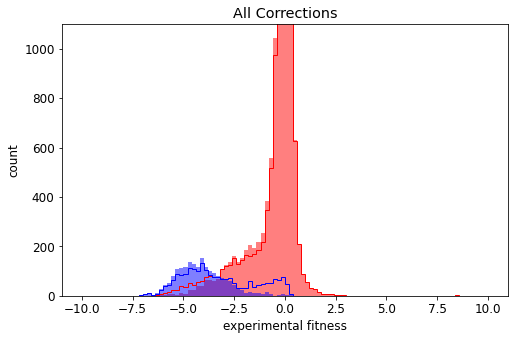

In [67]:
# plot precision recall curve
[fig,axs,AUC] = plot_precision_recall_curve(model_name,data_fitness_sim_unique_ML_2,data_fitness_unique)
#image_format = 'svg'
#image_name = 'plots/all_corrections_prerec.svg'
#fig.savefig(image_name, format=image_format, dpi=1200)

# plot histogram
ylim = [0,1100]
[fig,axs,_,_] = plot_histogram(model_name,data_fitness_sim_unique_ML_2,data_fitness_unique,ylim)
axs.set_title('All Corrections')

# add old data outline to plot
data_fitness_sim_unique_orig = np.load(model_name+'_fitness_sim.npy')
sim_thresh = 0.001
data_sim_b = (data_fitness_sim_unique_orig > sim_thresh).astype(int)
# plot histogram
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==1],bins=100,range=(-10,10),histtype=u'step',edgecolor='r',lw=1)
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==0],bins=100,range=(-10,10),histtype=u'step',edgecolor='b',lw=1)
axs.set_ylim(ylim)

#image_format = 'svg'
#image_name = 'plots/all_corrections_hist.svg'
#fig.savefig(image_name, format=image_format, dpi=1200)

In [68]:
# load data
name_carbon_unique = np.load(model_name+'_names_carbon_model.npy')
name_genes_data = np.load(model_name+'_names_genes.npy')

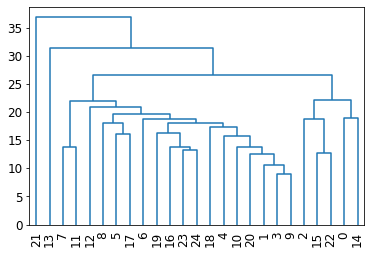

In [69]:
# Visualize the data
g_mean_data_f = np.mean(data_fitness_unique,1)
g_sortinds = np.argsort(g_mean_data_f)

#c_mean_data_f = np.mean(data_fitness_unique,0)
#c_mean_data_f_sortinds = np.argsort(c_mean_data_f)
Z = linkage(np.transpose(data_fitness_unique),'average')
D = dendrogram(Z,leaf_rotation=90,leaf_font_size=12,color_threshold=0)
D_inds = D['leaves']
c_sortinds = D_inds

data_fitness_sort = data_fitness_unique[g_sortinds,:][:,c_sortinds]
data_fitness_sim_sort = data_fitness_sim_unique_ML[g_sortinds,:][:,c_sortinds]
data_fitness_sim_sort_1 = data_fitness_sim_unique[g_sortinds,:][:,c_sortinds]

name_genes_data_sort = name_genes_data[g_sortinds]
name_carbon_sort = np.array(name_carbon_unique)[c_sortinds]

name_genes_model_sort = []
for i in range(len(name_genes_data_sort)):
    name_genes_model_sort.append(model_adj.genes.get_by_id(name_genes_data_sort[i]).name)

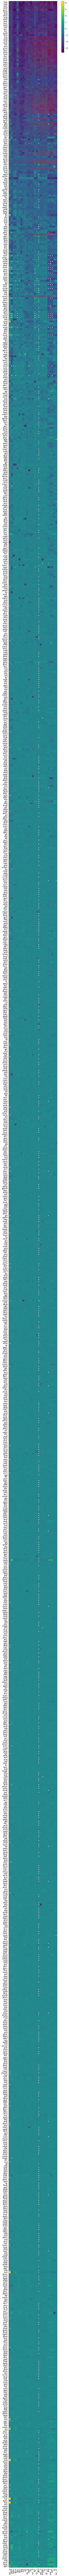

In [70]:
fig, ax = plt.subplots(figsize = [10,300])
vma = np.max(data_fitness_sort)
vmi = np.min(data_fitness_sort)
p=ax.imshow(data_fitness_sort,vmin=vmi,vmax=vma,cmap='viridis')
ax.set_yticks(range(len(name_genes_data_sort)));
ax.set_yticklabels(np.array(name_genes_model_sort));
ax.set_xticks(range(len(name_carbon_sort)));
ax.set_xticklabels(name_carbon_sort);
plt.xticks(rotation=90);
for i in range(data_fitness_sim_sort.shape[0]):
    for j in range(data_fitness_sim_sort.shape[1]):
        if data_fitness_sim_sort[i,j]<=0.001:
            ax.plot(j,i,'r.')
            if data_fitness_sim_sort_1[i,j]>0.001:
                ax.plot(j,i,'.',color=[1,1,1])
fig.colorbar(p,location='right',anchor=(0,1),shrink=0.02);

## Part 13: Hydrogen Ion Exchange

### Part 13a: Charge Balance (Run FBA)

In [398]:
# Coppied from part 9a
# Re run FBA (each vitamin individually)
vitamins = ['btn','pnto__R','thm','thf','nad']

# List of all isoenzymes and associated reactions that had an impact on the prediction AUC (b3008, CYSDS was not included)
iso_genes = ['b0073','b3281','b2414','b3829','b3772','b0002','b0002','b3390','b3008']
iso_reactions = ['IPMD','SHK3Dr','CYSS','METS','THRD_L','ASPK','HSDy','SHKK','CYSTL']

# Load environment
[name_medium_model, name_carbon_model, name_carbon_experiment] = load_environment(base_directory)

# Load Data
[data_experiments,data_genes,data_fitness] = load_data(base_directory)

model_name = 'iML1515'
print(model_name)

# load model
print('loading model')
model = load_model(model_name,base_directory)
# optional printout check
print(str(len(model.genes))+' total genes in model')

# match model to data
print('matching model and data')
[name_genes_matched,name_carbon_experiment_matched,name_carbon_model_matched,data_fitness_matched] = match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness)
# optional printout checks
print(str(len(name_genes_matched))+' genes matched')
print(str(len(name_carbon_model_matched))+' carbon matched')

# adjust model
print('adjusting model')
adj_strain = 1
adj_essential = 1
adj_carbon = 1
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# optional printout checks
print(str(len(name_genes_matched_adj)),' adjusted genes matched')
print(str(len(name_carbon_model_matched_adj)),' adjusted carbon matched')
print(str(data_fitness_matched_adj.shape),' data shape')

# get medium and carbon exchange indicies
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
print(f'\n')

# Reset model exchanges
# turn off all exchange reactions (these should be off but just to make sure)
for ex in model_adj.exchanges:
    ex.lower_bound = 0
    ex.upper_bound = 1000
    
# Add vitamins
for i in range(3):
    # add vitamin
    #turn on exchange
    model_adj.exchanges.get_by_id('EX_'+vitamins[i]+'_e').lower_bound = -1000
for i in range(3,5):
    # add vitamin
    # add exchange directly to intracellular metabolite
    rxn = cobra.Reaction('EX_'+vitamins[i]+'_c')
    rxn.name = 'EX_'+vitamins[i]+'_c'
    rxn.lower_bound = -1000
    rxn.upper_bound = 1000
    rxn.add_metabolites({model_adj.metabolites.get_by_id(vitamins[i]+'_c'): -1.0})
    model_adj.add_reactions([rxn])    

# Adjust L-serine reaction reversibility
model_adj.reactions.get_by_id('GHMT2r').lower_bound = 0
    
# Adjust isoenzymes
for i in range(len(iso_genes)):
    # adjust isoenzyme reaction
    tmp_gpr = model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule
    model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule = iso_genes[i]


iML1515
loading model
1516 total genes in model
matching model and data
1339 genes matched
27 carbon matched
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmpxu_wiuit.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
removing genes (strain):
b0061
b0344
b3902
removing genes (essential):
b0142
b0641
b0908
b2329
b2687
b3040
b3196
b3198
b3199
b3368
removing carbon sources:
man
sucr
1326  adjusted genes matched
25  adjusted carbon matched
(1326, 25)  data shape
checking environment
medium components not found in model:
carbon components not found in model:




In [399]:
# Update model for compartmental charge balance
# Add a metabolite to each compartment representing the charge which must be balanced
charge_c = cobra.Metabolite('charge_c',name='charge_c',compartment='c')
charge_p = cobra.Metabolite('charge_p',name='charge_p',compartment='p')
charge_e = cobra.Metabolite('charge_e',name='charge_e',compartment='e')

for rxn in model_adj.reactions:
    net_charge = 0
    net_charge_c = 0
    net_charge_p = 0
    net_charge_e = 0
    for met in rxn.metabolites:
        net_charge = net_charge + rxn.metabolites[met]*met.charge
        if met.compartment == 'c':
            net_charge_c = net_charge_c + rxn.metabolites[met]*met.charge
        elif met.compartment == 'p':
            net_charge_p = net_charge_p + rxn.metabolites[met]*met.charge
        elif met.compartment == 'e':
            net_charge_e = net_charge_e + rxn.metabolites[met]*met.charge
    
    # Add charge metabolite to reactions
    if net_charge_c != 0:
        rxn.add_metabolites({charge_c: net_charge_c})
    if net_charge_p != 0:
        rxn.add_metabolites({charge_p: net_charge_p})
    if net_charge_e != 0:
        rxn.add_metabolites({charge_e: net_charge_e})

In [400]:
# simulate phenotype
print('simulating phenotype')
data_fitness_simulated_matched_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)

# save data
np.save(model_name+'_fitness_sim_all_corrections_charge_balance.npy',np.asarray(data_fitness_simulated_matched_adj,dtype=np.double))

simulating phenotype


### Part 13b: Charge Balance (Plot Results)

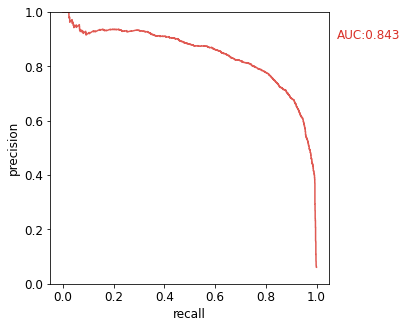

In [401]:
# Load Data# Load data and visualize results

# Precision recall curves
fig, axs = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(5)

# Load fitness data
data_fitness_unique = np.load(model_name+'_fitness.npy')
data_fit_V = data_fitness_unique.flatten()
sim_thresh = 0.001

model_name = 'iML1515'

p1 = -0.02
p2 = 0
alph = 0.8

# All corrections
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_all_corrections_charge_balance.npy')
# Precision Recall Curve
data_sim_b = (data_fitness_sim_unique > sim_thresh).astype(int)
data_sim_b_V = data_sim_b.flatten()
pre, rec, thresholds = pre_rec(data_sim_b_V*-1,data_fit_V*-1,pos_label=0)
c = np.array([215,48,39])/253
axs.plot(rec,pre,color=c,alpha=alph)
AUC = sk_auc(rec,pre)
AUC1 = AUC
axs.text(1.1+p1,0.9+p2,'AUC:'+str(np.round(AUC,3)),color=c)

# Format plot
axs.set_ylim([0, 1])
axs.set_xlabel('recall')
axs.set_ylabel('precision')
plt.rcParams['font.size'] = 12

# Save plot
#image_format = 'svg'
#image_name = 'plots/'+model_name+'_all_corrections_prerec.svg'
#fig.savefig(image_name, format=image_format, dpi=1200)



(0.0, 1100.0)

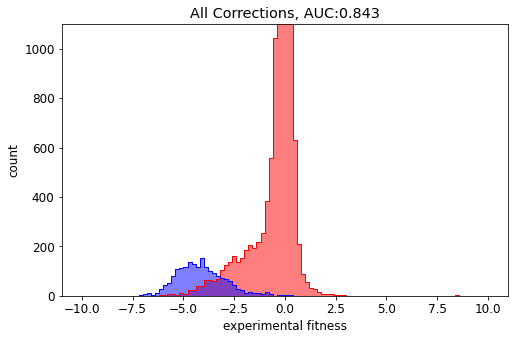

In [402]:
# plot histogram
data_fitness_sim_unique = np.load(model_name+'_fitness_sim_all_corrections_charge_balance.npy')

ylim = [0,1100]

[fig,axs,_,_] = plot_histogram(model_name,data_fitness_sim_unique,data_fitness_unique,ylim)
axs.set_title('All Corrections, AUC:'+str(np.round(AUC1,3)))

# add old data outline to plot
data_fitness_sim_unique_orig = np.load(model_name+'_fitness_sim_all_corrections.npy')
sim_thresh = 0.001
data_sim_b = (data_fitness_sim_unique_orig > sim_thresh).astype(int)
# plot histogram
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==1],bins=100,range=(-10,10),histtype=u'step',edgecolor='r',lw=1)
axs.hist(data_fitness_unique.flatten()[data_sim_b.flatten()==0],bins=100,range=(-10,10),histtype=u'step',edgecolor='b',lw=1)
axs.set_ylim(ylim)

#image_format = 'svg'
#image_name = 'plots/'+model_name+'_all_corrections_hist.svg'
#fig.savefig(image_name, format=image_format, dpi=900)


In [403]:
# Comparison of results
data_fitness_sim_H = data_fitness_sim_unique
data_fitness_sim = data_fitness_sim_unique_orig
data_fitness = data_fitness_unique

model_name = 'iML1515'
model = cobra.io.read_sbml_model(model_name+'_model_adjusted_all_corrections.xml')
name_carbon_unique = np.load(model_name+'_names_carbon_model.npy')
name_genes_data = np.load(model_name+'_names_genes.npy')

name_genes_model = []
for i in range(len(name_genes_data)):
    name_genes_model.append(model.genes.get_by_id(name_genes_data[i]).name)

sim_thresh = 0.001
fit_thresh = -2
# Print Corrected predictions
for i in range(data_fitness_sim_H.shape[0]):
    for j in range(data_fitness_sim_H.shape[1]):
        if data_fitness[i,j] < fit_thresh:
            if data_fitness_sim[i,j] < sim_thresh:
                if data_fitness_sim_H[i,j] >= sim_thresh:
                    print('error',name_genes_data[i],name_genes_model[i],name_carbon_unique[j],data_fitness[i,j],data_fitness_sim[i,j],data_fitness_sim_H[i,j])
            else:
                if data_fitness_sim_H[i,j] < sim_thresh:
                    print('correction',name_genes_data[i],name_genes_model[i],name_carbon_unique[j],data_fitness[i,j],data_fitness_sim[i,j],data_fitness_sim_H[i,j])
                
        else:
            if data_fitness_sim[i,j] < sim_thresh:
                if data_fitness_sim_H[i,j] >= sim_thresh:
                    print('correction',name_genes_data[i],name_genes_model[i],name_carbon_unique[j],data_fitness[i,j],data_fitness_sim[i,j],data_fitness_sim_H[i,j])
            else:
                if data_fitness_sim_H[i,j] < sim_thresh:
                    print('error',name_genes_data[i],name_genes_model[i],name_carbon_unique[j],data_fitness[i,j],data_fitness_sim[i,j],data_fitness_sim_H[i,j])
                

### Part 13c: H+ Fix Exchange (Run FBA)

In [360]:
# Coppied from part 9a
# Re run FBA (each vitamin individually)
vitamins = ['btn','pnto__R','thm','thf','nad']

# List of all isoenzymes and associated reactions that had an impact on the prediction AUC (b3008, CYSDS was not included)
iso_genes = ['b0073','b3281','b2414','b3829','b3772','b0002','b0002','b3390','b3008']
iso_reactions = ['IPMD','SHK3Dr','CYSS','METS','THRD_L','ASPK','HSDy','SHKK','CYSTL']

# Load environment
[name_medium_model, name_carbon_model, name_carbon_experiment] = load_environment(base_directory)

# Load Data
[data_experiments,data_genes,data_fitness] = load_data(base_directory)

model_name = 'iML1515'
print(model_name)

# load model
print('loading model')
model = load_model(model_name,base_directory)
# optional printout check
print(str(len(model.genes))+' total genes in model')

# match model to data
print('matching model and data')
[name_genes_matched,name_carbon_experiment_matched,name_carbon_model_matched,data_fitness_matched] = match_model_data(model,name_carbon_model,name_carbon_experiment,data_experiments,data_genes,data_fitness)
# optional printout checks
print(str(len(name_genes_matched))+' genes matched')
print(str(len(name_carbon_model_matched))+' carbon matched')

# adjust model
print('adjusting model')
adj_strain = 1
adj_essential = 1
adj_carbon = 1
[model_adj,name_genes_matched_adj,name_carbon_experiment_matched_adj,name_carbon_model_matched_adj,data_fitness_matched_adj] = model_adjustments(adj_strain, adj_essential, adj_carbon, model, name_genes_matched, name_carbon_experiment_matched, name_carbon_model_matched, data_fitness_matched)
# optional printout checks
print(str(len(name_genes_matched_adj)),' adjusted genes matched')
print(str(len(name_carbon_model_matched_adj)),' adjusted carbon matched')
print(str(data_fitness_matched_adj.shape),' data shape')

# get medium and carbon exchange indicies
print('checking environment')
[medium_ex_inds,carbon_ex_inds] = check_environment(model_adj,name_medium_model,name_carbon_model_matched_adj)
print(f'\n')

# Reset model exchanges
# turn off all exchange reactions (these should be off but just to make sure)
for ex in model_adj.exchanges:
    ex.lower_bound = 0
    ex.upper_bound = 1000
    
# Add vitamins
for i in range(3):
    # add vitamin
    #turn on exchange
    model_adj.exchanges.get_by_id('EX_'+vitamins[i]+'_e').lower_bound = -1000
for i in range(3,5):
    # add vitamin
    # add exchange directly to intracellular metabolite
    rxn = cobra.Reaction('EX_'+vitamins[i]+'_c')
    rxn.name = 'EX_'+vitamins[i]+'_c'
    rxn.lower_bound = -1000
    rxn.upper_bound = 1000
    rxn.add_metabolites({model_adj.metabolites.get_by_id(vitamins[i]+'_c'): -1.0})
    model_adj.add_reactions([rxn])    

# Adjust L-serine reaction reversibility
model_adj.reactions.get_by_id('GHMT2r').lower_bound = 0
    
# Adjust isoenzymes
for i in range(len(iso_genes)):
    # adjust isoenzyme reaction
    tmp_gpr = model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule
    model_adj.reactions.get_by_id(iso_reactions[i])._gene_reaction_rule = iso_genes[i]


iML1515
loading model
1516 total genes in model
matching model and data
1339 genes matched
27 carbon matched
adjusting model
Read LP format model from file /var/folders/yp/dx3zqgf139ndbl_1xyc8_nf00000gn/T/tmpc3zo43fg.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
removing genes (strain):
b0061
b0344
b3902
removing genes (essential):
b0142
b0641
b0908
b2329
b2687
b3040
b3196
b3198
b3199
b3368
removing carbon sources:
man
sucr
1326  adjusted genes matched
25  adjusted carbon matched
(1326, 25)  data shape
checking environment
medium components not found in model:
carbon components not found in model:




In [361]:
Hs = np.append(np.array([0,1,2,3,4,5]),np.arange(5.25,10.25,0.25))

# remove hydrogen ion from medium
medium_ex_inds=np.delete(medium_ex_inds,3)

for H in Hs:
    # Set hydrogen ion exchange
    model_adj.reactions.get_by_id('EX_h_e').upper_bound = H
    model_adj.reactions.get_by_id('EX_h_e').lower_bound = H
    
    # simulate phenotype
    print('simulating phenotype')
    data_fitness_simulated_matched_adj = simulate_phenotype(model_adj,name_genes_matched_adj,name_carbon_model_matched_adj,medium_ex_inds,carbon_ex_inds)

    # save data
    np.save(model_name+'_fitness_sim_all_corrections_H_Exchange_'+str(np.round(H,3))+'.npy',np.asarray(data_fitness_simulated_matched_adj,dtype=np.double))

simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype
simulating phenotype


### Part 13d: H+ Fix Exchange (Plot Results)

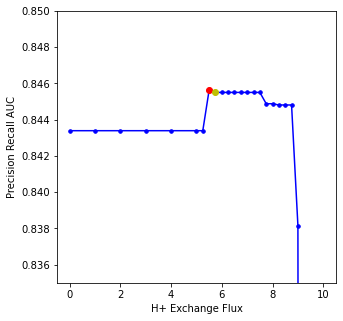

In [20]:
# Load Data# Load data and visualize results
Hs = np.append(np.array([0,1,2,3,4,5]),np.arange(5.25,10.25,0.25))

# Precision recall curves
fig, axs = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(5)

model_name = 'iML1515'

# Load fitness data
data_fitness_unique = np.load(model_name+'_fitness.npy')
data_fit_V = data_fitness_unique.flatten()
sim_thresh = 0.001

p1 = -0.02
p2 = 0
alph = 0.8

AUC_H = np.zeros(len(Hs))

for i in range(len(Hs)):
    H = Hs[i]
    # All corrections
    data_fitness_sim_unique = np.load(model_name+'_fitness_sim_all_corrections_H_Exchange_'+str(np.round(H,3))+'.npy')
    # Precision Recall Curve
    data_sim_b = (data_fitness_sim_unique > sim_thresh).astype(int)
    data_sim_b_V = data_sim_b.flatten()
    pre, rec, thresholds = pre_rec(data_sim_b_V*-1,data_fit_V*-1,pos_label=0)
    AUC = sk_auc(rec,pre)
    AUC_H[i] = AUC
    
plt.plot(Hs,AUC_H,'b')
plt.plot(Hs,AUC_H,'b.',markersize=7)
plt.plot(Hs[7],AUC_H[7],'r.',markersize=12)
plt.plot(Hs[8],AUC_H[8],'y.',markersize=12)
plt.ylim([0.835,0.85])
plt.xlabel('H+ Exchange Flux')
plt.ylabel('Precision Recall AUC')

image_format = 'svg'
image_name = 'plots/'+model_name+'_H_exchange.svg'
fig.savefig(image_name, format=image_format, dpi=900)

In [21]:
# Comparison of results
data_fitness_sim_H = np.load(model_name+'_fitness_sim_all_corrections_H_Exchange_6.0.npy')
data_fitness_sim = np.load(model_name+'_fitness_sim_all_corrections.npy')
data_fitness = np.load(model_name+'_fitness.npy')

model_name = 'iML1515'
model = cobra.io.read_sbml_model(model_name+'_model_adjusted_all_corrections.xml')
name_carbon_unique = np.load(model_name+'_names_carbon_model.npy')
name_genes_data = np.load(model_name+'_names_genes.npy')

name_genes_model = []
for i in range(len(name_genes_data)):
    name_genes_model.append(model.genes.get_by_id(name_genes_data[i]).name)

sim_thresh = 0.001
fit_thresh = -2
# Print Corrected predictions
for i in range(data_fitness_sim_H.shape[0]):
    for j in range(data_fitness_sim_H.shape[1]):
        if data_fitness[i,j] < fit_thresh:
            if data_fitness_sim[i,j] < sim_thresh:
                if data_fitness_sim_H[i,j] >= sim_thresh:
                    print('error',name_genes_data[i],name_genes_model[i],name_carbon_unique[j],data_fitness[i,j],data_fitness_sim[i,j],data_fitness_sim_H[i,j])
            else:
                if data_fitness_sim_H[i,j] < sim_thresh:
                    print('correction',name_genes_data[i],name_genes_model[i],name_carbon_unique[j],data_fitness[i,j],data_fitness_sim[i,j],data_fitness_sim_H[i,j])
                
        else:
            if data_fitness_sim[i,j] < sim_thresh:
                if data_fitness_sim_H[i,j] >= sim_thresh:
                    print('correction',name_genes_data[i],name_genes_model[i],name_carbon_unique[j],data_fitness[i,j],data_fitness_sim[i,j],data_fitness_sim_H[i,j])
            else:
                if data_fitness_sim_H[i,j] < sim_thresh:
                    print('error',name_genes_data[i],name_genes_model[i],name_carbon_unique[j],data_fitness[i,j],data_fitness_sim[i,j],data_fitness_sim_H[i,j])
                

Academic license - for non-commercial use only - expires 2023-09-03
Using license file /Users/david/gurobi.lic
correction b0429 cyoD glyclt -2.3295 0.11405077096675816 0.0
correction b0430 cyoC glyclt -3.0324999999999998 0.11405077096675816 0.0
correction b0431 cyoB glyclt -2.7615 0.11405077096675816 0.0
correction b0432 cyoA glyclt -2.7874999999999996 0.11405077096675816 0.0
correction b0721 sdhC ac -5.682 0.10593240203592098 0.0
correction b0722 sdhD ac -4.306 0.10593240203592098 0.0
correction b0723 sdhA ac -4.3025 0.10593240203592098 0.0
correction b0724 sdhB ac -4.252000000000001 0.10593240203592098 0.0
